<a href="https://colab.research.google.com/github/ykitaguchi77/statistics_for_articles/blob/main/Blepharoptosis_dryeye.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: gdrive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


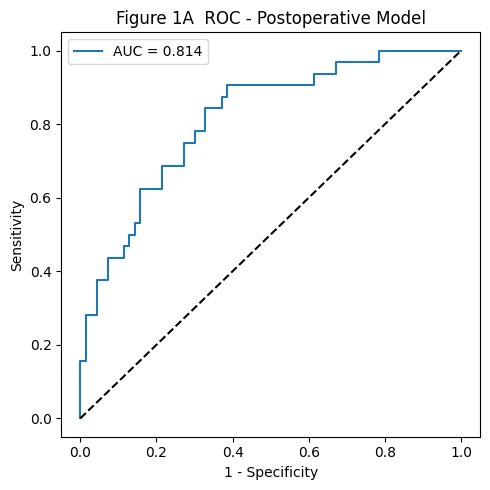

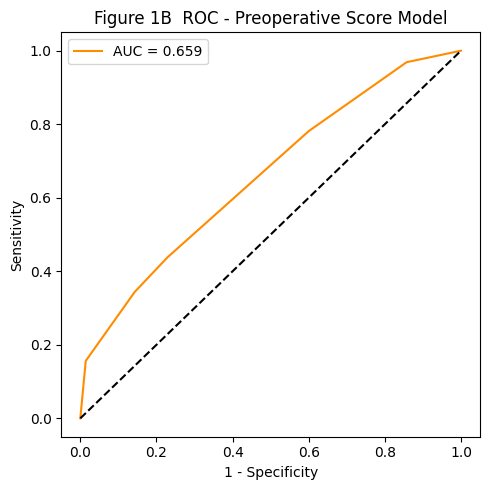

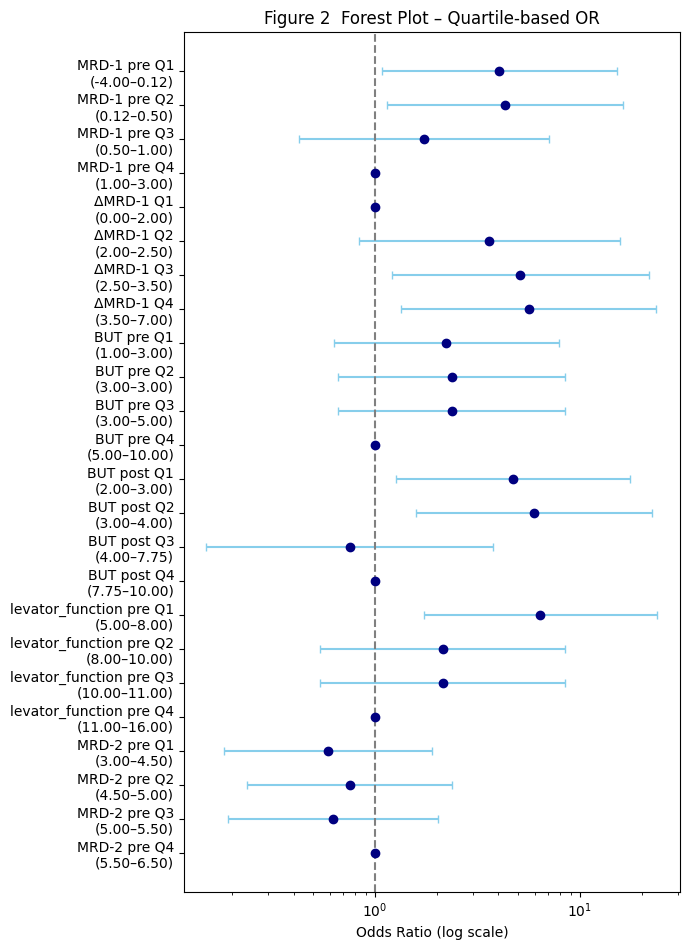

In [ ]:
# Google Colabで動作する完全版スクリプト（日本語コメント付き）
# 保存先: /content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ.xlsx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from statsmodels.stats.contingency_tables import Table2x2

# Excelファイルの読み込み
file_path = "/content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ_kit.xlsx"
df_all = pd.read_excel(file_path, sheet_name="対象症例sides", header=0)

# ΔMRD-1を追加
df_all["ΔMRD-1"] = df_all["MRD-1 3M"] - df_all["MRD-1 pre"]

# 術前SPKが無い症例のみ抽出
df = df_all[df_all["SPK pre"] == 0].copy()

# ===============================
# Figure 1A：術後モデルのROC曲線
# ===============================
# 使用する変数（欠損除外）
post_cols = ["MRD-1 pre", "ΔMRD-1", "levator_function pre", "MRD-2 pre", "BUT pre", "BUT post"]
df_post = df[["SPK post"] + post_cols].dropna()

X_post = sm.add_constant(df_post[post_cols])
y_post = df_post["SPK post"]

# ロジスティック回帰モデルの構築
post_model = sm.Logit(y_post, X_post).fit(disp=False)

# 予測確率とROC曲線
y_prob_post = post_model.predict(X_post)
fpr_p, tpr_p, _ = roc_curve(y_post, y_prob_post)
auc_p = roc_auc_score(y_post, y_prob_post)

# グラフ出力
plt.figure(figsize=(5, 5))
plt.plot(fpr_p, tpr_p, label=f"AUC = {auc_p:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.title("Figure 1A  ROC - Postoperative Model")
plt.legend()
plt.tight_layout()
plt.savefig("Fig1A_ROC_postop.png", dpi=350)

# ===============================
# Figure 1B：スコアモデルのROC曲線
# ===============================
# スコア定義関数
def calc_score(row):
    score = 0
    if row["MRD-1 pre"] < 0.5:
        score += 2
    if row["ΔMRD-1"] >= 2.0:
        score += 1
    if row["BUT pre"] < 5:
        score += 1
    if row["levator_function pre"] < 8:
        score += 1
    return score

df["score"] = df.apply(calc_score, axis=1)
df_score = df[["score", "SPK post"]].dropna()

# モデル構築とROC
X_score = df_score[["score"]]
y_score = df_score["SPK post"]
model_score = LogisticRegression().fit(X_score, y_score)
y_prob_score = model_score.predict_proba(X_score)[:, 1]
fpr_s, tpr_s, _ = roc_curve(y_score, y_prob_score)
auc_s = roc_auc_score(y_score, y_prob_score)

# グラフ出力
plt.figure(figsize=(5, 5))
plt.plot(fpr_s, tpr_s, label=f"AUC = {auc_s:.3f}", color="darkorange")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.title("Figure 1B  ROC - Preoperative Score Model")
plt.legend()
plt.tight_layout()
plt.savefig("Fig1B_ROC_preop.png", dpi=350)

# ===============================
# Figure 2：フォレストプロット（四分位OR）
# ===============================
# 対象変数
predictors = ["MRD-1 pre", "ΔMRD-1", "BUT pre", "BUT post", "levator_function pre", "MRD-2 pre"]

forest_data = []

for var in predictors:
    df_q = df[[var, "SPK post"]].dropna().copy()
    df_q["quartile"] = pd.qcut(df_q[var].rank(method="first"), 4, labels=["Q1", "Q2", "Q3", "Q4"])

    q_vals = df_q[var].quantile([0, 0.25, 0.5, 0.75, 1]).values
    ranges = {
        "Q1": f"{q_vals[0]:.2f}–{q_vals[1]:.2f}",
        "Q2": f"{q_vals[1]:.2f}–{q_vals[2]:.2f}",
        "Q3": f"{q_vals[2]:.2f}–{q_vals[3]:.2f}",
        "Q4": f"{q_vals[3]:.2f}–{q_vals[4]:.2f}"
    }

    # 基準群（リスク最小）を指定
    ref_q = "Q4" if var != "ΔMRD-1" else "Q1"

    for q in ["Q1", "Q2", "Q3", "Q4"]:
        if q == ref_q:
            forest_data.append((var, q, ranges[q], 1.0, 1.0, 1.0))
        else:
            a = ((df_q["quartile"] == q) & (df_q["SPK post"] == 1)).sum()
            b = ((df_q["quartile"] == q) & (df_q["SPK post"] == 0)).sum()
            c = ((df_q["quartile"] == ref_q) & (df_q["SPK post"] == 1)).sum()
            d = ((df_q["quartile"] == ref_q) & (df_q["SPK post"] == 0)).sum()
            # 0セル補正
            if 0 in [a, b, c, d]:
                a += 0.5; b += 0.5; c += 0.5; d += 0.5
            table = Table2x2([[a, b], [c, d]])
            or_val = table.oddsratio
            ci_low, ci_high = table.oddsratio_confint()
            forest_data.append((var, q, ranges[q], or_val, ci_low, ci_high))

# データフレーム化
forest_df = pd.DataFrame(forest_data, columns=["Variable", "Quartile", "Range", "OR", "CI_low", "CI_high"])
forest_df["Label"] = forest_df["Variable"] + " " + forest_df["Quartile"] + "\n(" + forest_df["Range"] + ")"

# プロット
plt.figure(figsize=(7, len(forest_df) * 0.4))
y_pos = np.arange(len(forest_df))[::-1]
plt.errorbar(forest_df["OR"], y_pos,
             xerr=[forest_df["OR"] - forest_df["CI_low"], forest_df["CI_high"] - forest_df["OR"]],
             fmt='o', color='navy', ecolor='skyblue', capsize=3)
plt.axvline(1, color='gray', linestyle='--')
plt.yticks(y_pos, forest_df["Label"])
plt.xscale("log")
plt.xlabel("Odds Ratio (log scale)")
plt.title("Figure 2  Forest Plot – Quartile-based OR")
plt.tight_layout()
plt.savefig("Fig2_Forest.png", dpi=350)


Libraries loaded.

--- 2. Loading and Basic Preprocessing ---
Excel file '眼瞼下垂★ドライアイ_kit.xlsx' (Sheet: '対象症例sides') loaded successfully.
Original data shape: (172, 32)
Converting key columns to numeric...
ΔMRD-1 calculated (using MRD-1 3M).
ΔMRD-2 calculated (using MRD-2 3M).
Filtered data for 'SPK pre == 0'. Shape of 'df': (102, 32)

--- 3. Generating Figure 1A: Post-operative model ROC ---
Predictors for Post-operative model: MRD-1 pre, ΔMRD-1, levator_function pre, MRD-2 pre, BUT pre, BUT post
Data for Post-op model ROC (after dropna): (102, 7)

--- Logistic Regression Summary (Post-operative Model) ---

Coefficients (log-odds):
const                   0.966430
MRD-1 pre               0.443148
ΔMRD-1                  0.367889
levator_function pre   -0.451663
MRD-2 pre               0.657377
BUT pre                -0.040483
BUT post               -0.369842
dtype: float64

P-values:
const                   0.642979
MRD-1 pre               0.162513
ΔMRD-1                  0.176999
lev

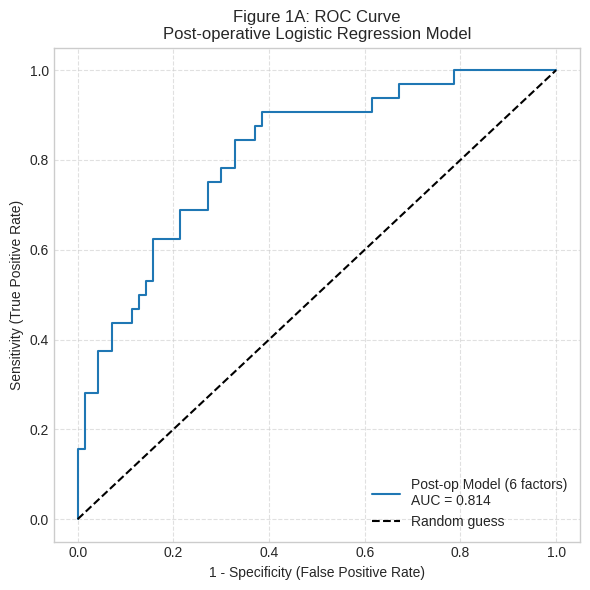


--- 4. Generating Figure 1B: Pre-operative score ROC vs. Pre-operative direct model ROC ---

--- 4a. Pre-operative Score Model (Original Method) ---
Pre-operative score calculated.
Data for Score model ROC (after dropna): (102, 6)

--- Logistic Regression Summary (Pre-operative Score Model) ---

Coefficients (log-odds):
const         -1.826749
preop_score    0.464164
dtype: float64

P-values:
const          0.000052
preop_score    0.005159
dtype: float64

Confidence Intervals (log-odds):
                    0         1
const       -2.711614 -0.941883
preop_score  0.138898  0.789430

Odds Ratios:
const          0.160936
preop_score    1.590684
dtype: float64

Confidence Intervals (Odds Ratio):
                    0         1
const        0.066429  0.389893
preop_score  1.149007  2.202142
AUC for Score Model = 0.659

--- 4b. Pre-operative Direct Model (Using 4 factors directly) ---
Data for Pre-op Direct model ROC (after dropna): (102, 5)

--- Logistic Regression Summary (Pre-operative 

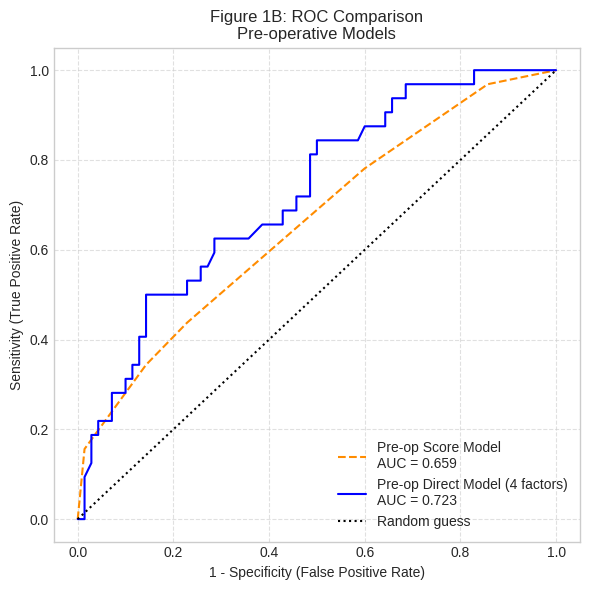


--- 4d. Comparing Pre-operative Model Accuracies ---
AUC (Score Model): 0.659
AUC (Direct Model): 0.723
結果: 術前の4因子を直接ロジスティック回帰に使用した方が、スコア化するよりも精度 (AUC) が向上しました。
考察: スコア化の過程で、各因子の連続的な情報や相互作用の一部が失われた可能性があります。直接モデルは各因子の重みをデータから最適に学習するため、より高い予測性能を示すことがあります。

--- 5. Generating Figure 2: Forest plot (Quartile OR) ---
Data for Forest Plot: (102, 33)
Processing MRD-1 pre: 102 non-NaN rows.
 - Ref quartile for MRD-1 pre: Q4
Processing ΔMRD-1: 102 non-NaN rows.
 - Ref quartile for ΔMRD-1: Q1
Processing MRD-1 3M: 102 non-NaN rows.
 - Ref quartile for MRD-1 3M: Q4
Processing MRD-2 pre: 102 non-NaN rows.
 - Ref quartile for MRD-2 pre: Q1
Processing ΔMRD-2: 102 non-NaN rows.
 - Ref quartile for ΔMRD-2: Q1
Processing MRD-2 3M: 102 non-NaN rows.
 - Ref quartile for MRD-2 3M: Q1
Processing levator_function pre: 102 non-NaN rows.
 - Ref quartile for levator_function pre: Q4
Processing BUT pre: 102 non-NaN rows.
 - Ref quartile for BUT pre: Q4
Processing BUT post: 102 non-NaN rows.
 - Ref quartile for B

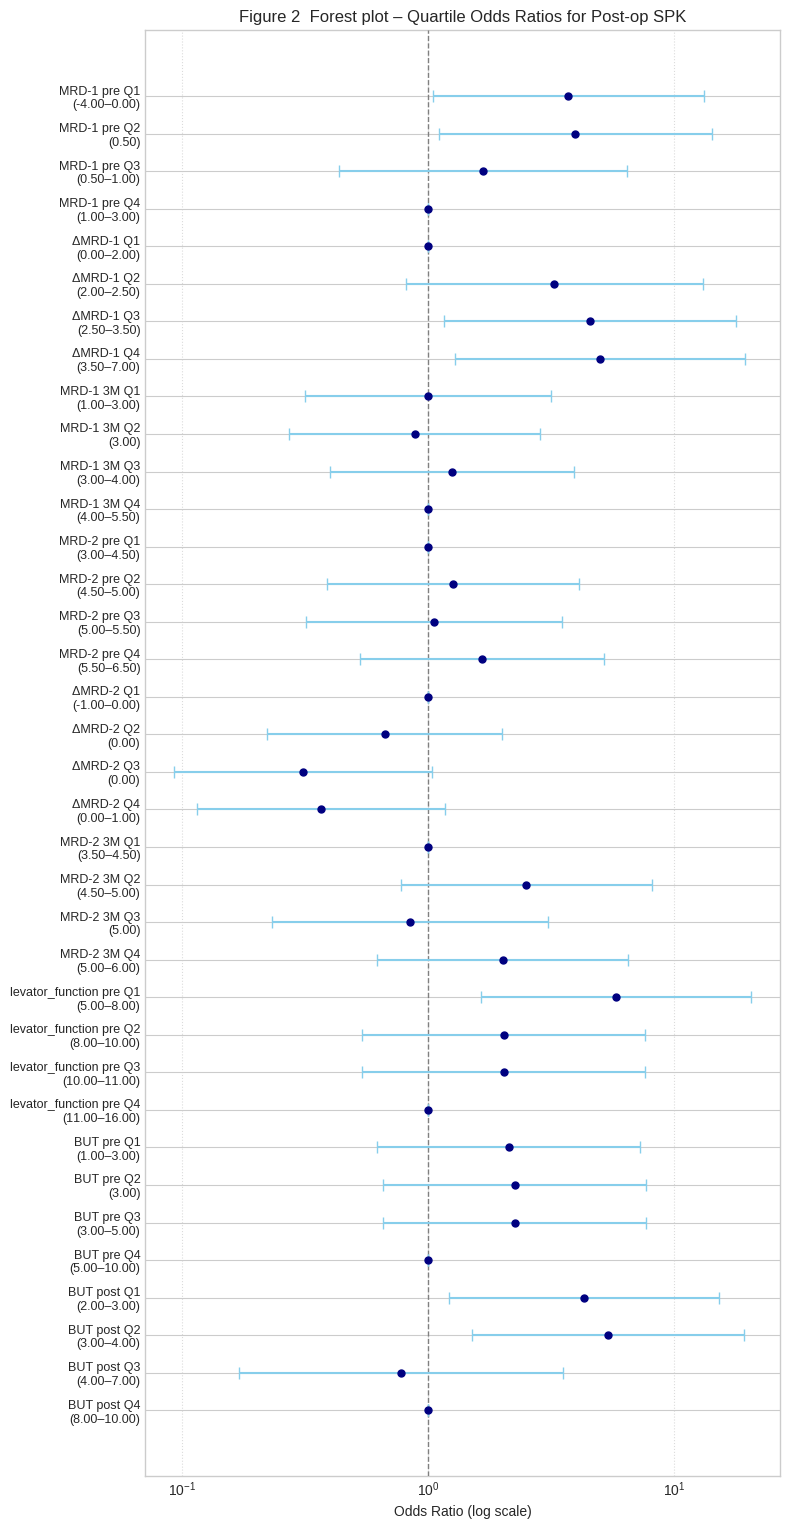


--- 6. Generating Table 1: Baseline characteristics ---

=== Table 1: Summary statistics (for subjects with SPK pre = 0) ===


Total N (SPK pre=0)      N  Missing  Mean    SD  Min  \
MRD-1 pre                             102  102.0        0  0.50  1.19 -4.0   
ΔMRD-1                                102  102.0        0  2.74  1.33  0.0   
MRD-1 3M                              102  102.0        0  3.24  0.97  1.0   
MRD-2 pre                             102  102.0        0  4.86  0.69  3.0   
ΔMRD-2                                102  102.0        0  0.01  0.39 -1.0   
MRD-2 3M                              102  102.0        0  4.87  0.60  3.5   
levator_function pre                  102  102.0        0  9.53  2.20  5.0   
BUT pre                               102  102.0        0  4.57  2.75  1.0   
BUT post                              102  102.0        0  5.48  2.70  2.0   

                        Q1  Median     Q3   Max  
MRD-1 pre             0.12     0.5   1.00   3.0  
ΔMRD-1                2.00     2.5   3.50   7.0  
MRD-1 3M              3.00     3.0   4.00   5.5  
MRD-2 pre             4.50     5.0   5.50   6.5  
ΔMRD-2                0.00     0.0   0.00   1.0  
MRD-2 3M              4.50     5.0   5.00   6.0  
levator_function pre  8.00    10.0  11.00  16.0  
BUT pre               3.00     3.0   5.00  10.0  
BUT post              3.00     4.0   7.75  10.0


--- 7. Normality tests and Histograms ---
Shapiro-Wilk normality test (alpha = 0.05):
MRD-1 pre                 Samples=102  W=0.9111, p=0.0000 (Non-normal)


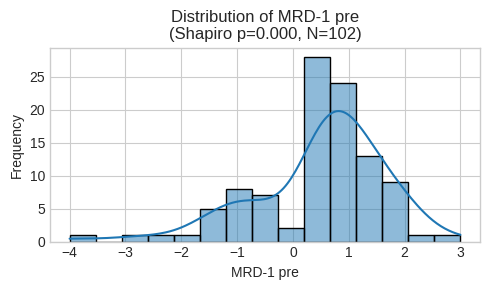

ΔMRD-1                    Samples=102  W=0.9725, p=0.0314 (Non-normal)


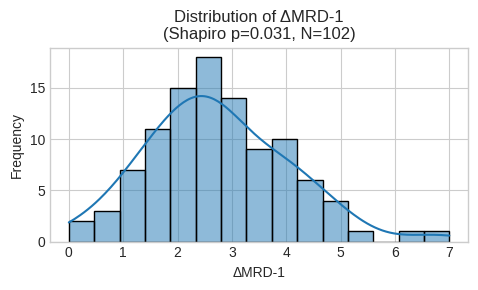

MRD-1 3M                  Samples=102  W=0.9517, p=0.0009 (Non-normal)


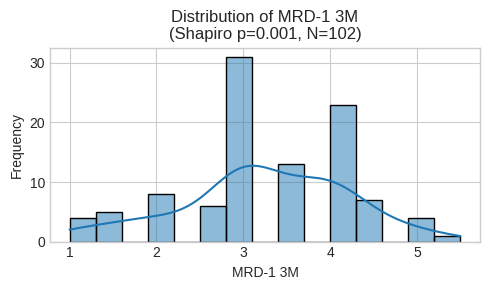

MRD-2 pre                 Samples=102  W=0.9464, p=0.0004 (Non-normal)


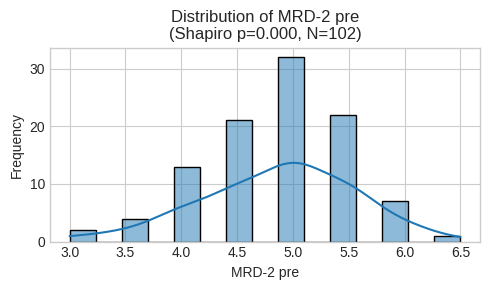

ΔMRD-2                    Samples=102  W=0.8284, p=0.0000 (Non-normal)


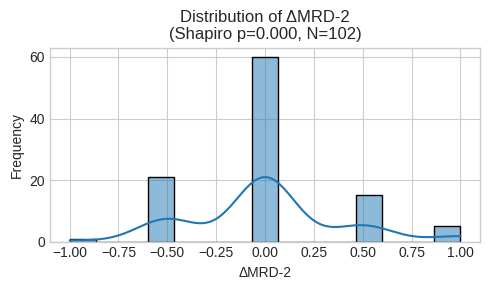

MRD-2 3M                  Samples=102  W=0.9200, p=0.0000 (Non-normal)


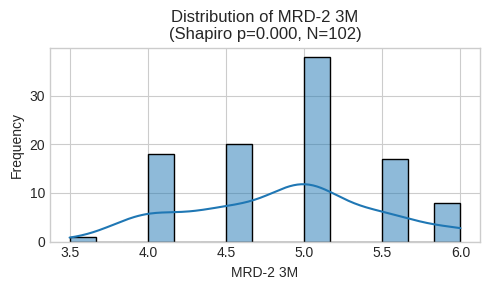

levator_function pre      Samples=102  W=0.9723, p=0.0304 (Non-normal)


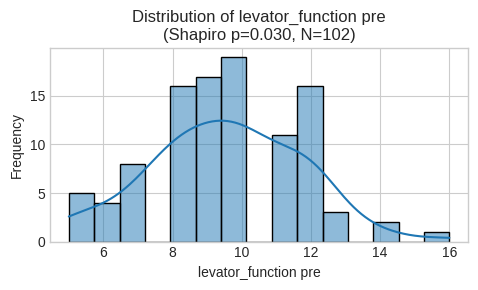

BUT pre                   Samples=102  W=0.7982, p=0.0000 (Non-normal)


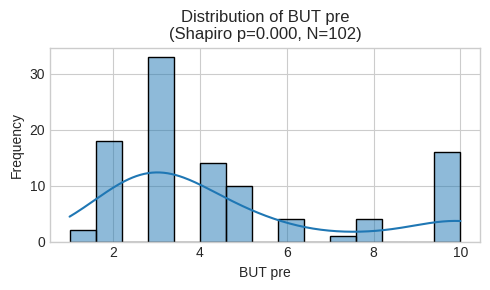

BUT post                  Samples=102  W=0.8251, p=0.0000 (Non-normal)


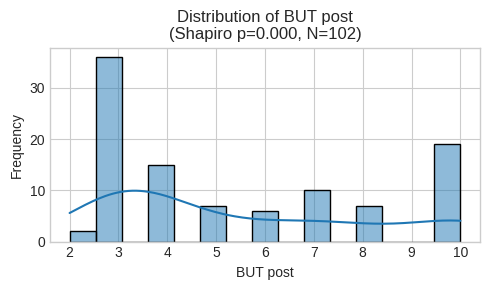


--- 8. Table 2: Univariate comparison and Multivariate logistic regression ---
Created 'df_analysis' for Table 2. Shape: (102, 33)

=== Univariate Analysis ===

--- Univariate Analysis Summary ---


Variable  N (SPK=0)  Mean (0)  SD (0)  N (SPK=1)  Mean (1)  \
0             MRD-1 pre         70      0.64    1.20         32      0.17   
1                ΔMRD-1         70      2.54    1.41         32      3.17   
2              MRD-1 3M         70      3.19    1.01         32      3.34   
3             MRD-2 pre         70      4.80    0.66         32      5.00   
4                ΔMRD-2         70      0.04    0.34         32     -0.05   
5              MRD-2 3M         70      4.84    0.60         32      4.95   
6  levator_function pre         70     10.01    2.05         32      8.47   
7               BUT pre         70      4.81    2.91         32      4.03   
8              BUT post         70      6.03    2.66         32      4.28   

   SD (1)         Test  p-value  
0    1.11  M-Whitney U   0.0198  
1    1.03  M-Whitney U   0.0065  
2    0.89  M-Whitney U   0.6292  
3    0.74  M-Whitney U   0.1626  
4    0.46  M-Whitney U   0.1765  
5    0.59  M-Whitney U   0.2684  
6    2.17    Welch's t   0.0013  
7    2.32  M-Whitney U   0.2942  
8    2.41  M-Whitney U   0.0007


=== Multivariate Logistic Regression ===
Data for Multivariate model (after dropna): (102, 10)
                   Multivariate Logistic Regression Results                   
Dep. Variable:               SPK post   No. Observations:                  102
Model:                          Logit   Df Residuals:                       94
Method:                           MLE   Df Model:                            7
Date:                Mon, 12 May 2025   Pseudo R-squ.:                  0.2359
Time:                        13:44:44   Log-Likelihood:                -48.479
converged:                       True   LL-Null:                       -63.449
Covariance Type:            nonrobust   LLR p-value:                 9.740e-05
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.2205      2.164      0.102      0.919      -4.021       4.462
MRD-1

CI 2.5%  CI 97.5%  Odds Ratio
const                   0.018    86.666       1.247
MRD-1 pre                 NaN       NaN       1.168
ΔMRD-1                    NaN       NaN       1.089
MRD-1 3M                  NaN       NaN       1.271
MRD-2 pre               0.000       inf       1.359
ΔMRD-2                  0.000       inf       1.454
MRD-2 3M                0.000       inf       1.977
levator_function pre    0.450     0.811       0.604
BUT pre                 0.753     1.173       0.940
BUT post                0.518     0.864       0.669


--- 9. Stepwise variable selection based on AIC ---
Null model AIC = 128.90
Iter 1: Add levator_function pre      New AIC = 119.34
Iter 2: Add BUT post                  New AIC = 110.85
Iter 3: Add MRD-2 3M                  New AIC = 107.13

=== Final Selected Model (AIC) ===
                             Stepwise AIC Result                              
Dep. Variable:               SPK post   No. Observations:                  102
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            3
Date:                Mon, 12 May 2025   Pseudo R-squ.:                  0.2188
Time:                        13:44:45   Log-Likelihood:                -49.566
converged:                       True   LL-Null:                       -63.449
Covariance Type:            nonrobust   LLR p-value:                 4.069e-06
                           coef    std err          z      P>|z|      [0.025      0.975]
-

CI 2.5%  CI 97.5%     OR
const                   0.023    70.134  1.263
levator_function pre    0.483     0.810  0.625
BUT post                0.545     0.871  0.689
MRD-2 3M                1.169     7.166  2.895


Selected variables by AIC: ['levator_function pre', 'BUT post', 'MRD-2 3M']

--- 10. Forest Plot OR and p-value raw data ---
Displaying the data used for the Forest Plot (Figure 2):


Variable Quartile        Range     OR  CI_low  CI_high  \
0              MRD-1 pre       Q1   -4.00–0.00  3.710   1.045   13.175   
1              MRD-1 pre       Q2         0.50  3.966   1.109   14.179   
2              MRD-1 pre       Q3    0.50–1.00  1.667   0.434    6.405   
3              MRD-1 pre       Q4    1.00–3.00  1.000   1.000    1.000   
4                 ΔMRD-1       Q1    0.00–2.00  1.000   1.000    1.000   
5                 ΔMRD-1       Q2    2.00–2.50  3.261   0.812   13.095   
6                 ΔMRD-1       Q3    2.50–3.50  4.548   1.157   17.885   
7                 ΔMRD-1       Q4    3.50–7.00  4.982   1.282   19.361   
8               MRD-1 3M       Q1    1.00–3.00  1.000   0.317    3.154   
9               MRD-1 3M       Q2         3.00  0.882   0.273    2.856   
10              MRD-1 3M       Q3    3.00–4.00  1.253   0.401    3.913   
11              MRD-1 3M       Q4    4.00–5.50  1.000   1.000    1.000   
12             MRD-2 pre       Q1    3.00–4.50  1.000   1.000    1.000   
13             MRD-2 pre       Q2    4.50–5.00  1.263   0.390    4.089   
14             MRD-2 pre       Q3    5.00–5.50  1.054   0.319    3.484   
15             MRD-2 pre       Q4    5.50–6.50  1.655   0.527    5.192   
16                ΔMRD-2       Q1   -1.00–0.00  1.000   1.000    1.000   
17                ΔMRD-2       Q2         0.00  0.668   0.222    2.006   
18                ΔMRD-2       Q3         0.00  0.311   0.093    1.041   
19                ΔMRD-2       Q4    0.00–1.00  0.368   0.115    1.176   
20              MRD-2 3M       Q1    3.50–4.50  1.000   1.000    1.000   
21              MRD-2 3M       Q2    4.50–5.00  2.501   0.774    8.088   
22              MRD-2 3M       Q3         5.00  0.846   0.233    3.074   
23              MRD-2 3M       Q4    5.00–6.00  2.007   0.621    6.489   
24  levator_function pre       Q1    5.00–8.00  5.800   1.639   20.521   
25  levator_function pre       Q2   8.00–10.00  2.027   0.541    7.593   
26  levator_function pre       Q3  10.00–11.00  2.027   0.541    7.593   
27  levator_function pre       Q4  11.00–16.00  1.000   1.000    1.000   
28               BUT pre       Q1    1.00–3.00  2.122   0.623    7.225   
29               BUT pre       Q2         3.00  2.251   0.657    7.705   
30               BUT pre       Q3    3.00–5.00  2.251   0.657    7.705   
31               BUT pre       Q4   5.00–10.00  1.000   1.000    1.000   
32              BUT post       Q1    2.00–3.00  4.310   1.218   15.250   
33              BUT post       Q2    3.00–4.00  5.400   1.514   19.254   
34              BUT post       Q3    4.00–7.00  0.778   0.171    3.535   
35              BUT post       Q4   8.00–10.00  1.000   1.000    1.000   

    P_value  
0    0.0644  
1    0.0337  
2    0.4986  
3       NaN  
4       NaN  
5    0.0975  
6    0.0266  
7    0.0266  
8    1.0000  
9    1.0000  
10   0.7712  
11      NaN  
12      NaN  
13   0.7645  
14   1.0000  
15   0.5551  
16      NaN  
17   0.5725  
18   0.0746  
19   0.1441  
20      NaN  
21   0.1441  
22   1.0000  
23   0.3678  
24   0.0078  
25   0.3238  
26   0.3238  
27      NaN  
28   0.3487  
29   0.2203  
30   0.2203  
31      NaN  
32   0.0337  
33   0.0078  
34   1.0000  
35      NaN


--- 11. Risk Score Calculation and Evaluation ---
Risk score calculated and added.


SPK post  risk_score  MRD-1 pre  ΔMRD-1  BUT pre  levator_function pre
0         0           3       -0.5     2.5     10.0                   9.0
1         0           0        0.5     1.5     10.0                   9.0
3         0           4       -1.0     5.0      3.0                   9.0
4         1           3        0.5     4.0      4.0                   5.0
5         1           3        0.5     4.0      4.0                   5.0


=== SPK Incidence by Risk Score ===


risk_score  Total  SPK Cases  SPK Rate (%)
0           0     11          1           9.1
1           1     24          6          25.0
2           2     37         11          29.7
3           3      9          3          33.3
4           4     15          6          40.0
5           5      6          5          83.3

Score rate plot saved: ./Fig_Score_SPK_Rate.png


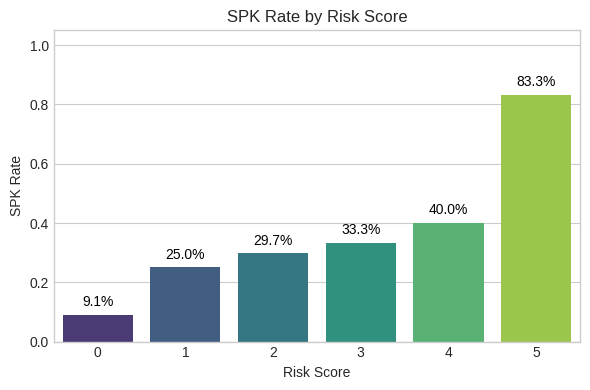


=== ROC Curve for the Risk Score ===
Score ROC curve saved: ./Fig_ROC_Score.png (AUC = 0.659)


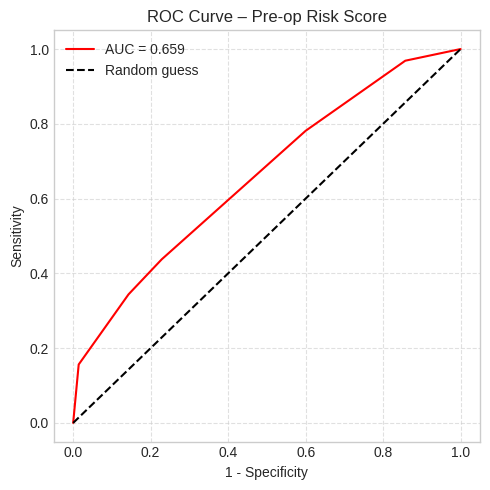


Optimal cutoff (Youden Index): Score >= 3.00 (Suggests >= 3) | Sens: 0.438, Spec: 0.771

==== 解析終了：図 (PNG) はフォルダ '.' に保存されました ====

--- 11-alt. New Scoring System including Post-operative Factors ---
New risk score (including BUT post) calculated and added.


SPK post  new_risk_score  risk_score  MRD-1 pre  ΔMRD-1  BUT pre  \
0         0               3           3       -0.5     2.5     10.0   
1         0               0           0        0.5     1.5     10.0   
3         0               5           4       -1.0     5.0      3.0   
4         1               3           3        0.5     4.0      4.0   
5         1               3           3        0.5     4.0      4.0   

   levator_function pre  BUT post  
0                   9.0      10.0  
1                   9.0      10.0  
3                   9.0       3.0  
4                   5.0      10.0  
5                   5.0       6.0


=== SPK Incidence by New Risk Score (0-6 points) ===


new_risk_score  Total  SPK Cases  SPK Rate (%)
0               0      8          0           0.0
1               1     17          2          11.8
2               2     36         11          30.6
3               3     18          8          44.4
4               4      8          1          12.5
5               5     12          7          58.3
6               6      3          3         100.0

New score rate plot saved: ./Fig_New_Score_SPK_Rate.png


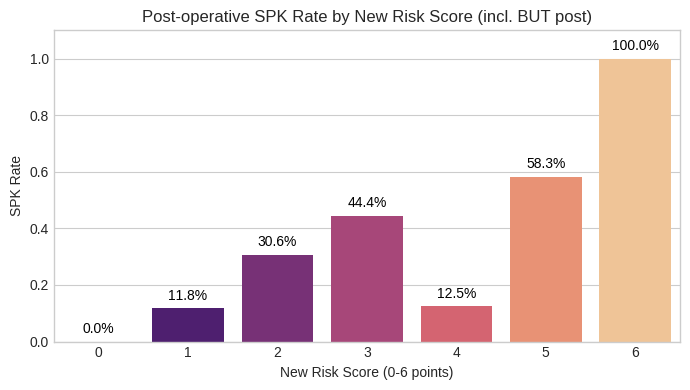


=== ROC Curve Comparison: New vs. Original Score ===
Score ROC comparison plot saved: ./Fig_ROC_Score_Comparison.png


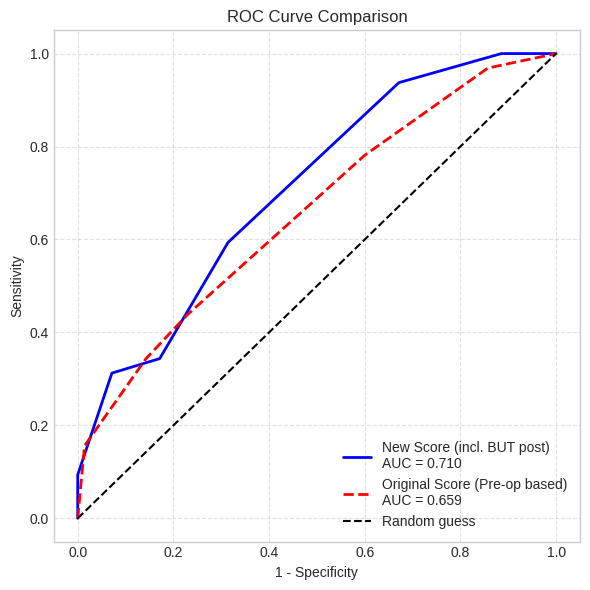


AUC Comparison: New Score = 0.710, Original Score = 0.659
The new score including BUT post shows improved discriminative ability.

Optimal cutoff for New Score (Youden Index): Score >= 3.00 (Suggests >= 3) | Sens: 0.594, Spec: 0.686

==== 解析終了：図 (PNG) はフォルダ '.' に保存されました ====


In [ ]:
# =============================================================
# 眼瞼下垂術後SPKリスク解析：Google Colab用フルスクリプト Ver.Corrected_3M
# （日本語コメント付き・350 dpiで図を保存・Forest Plot p値・単変量結果・スコアリング追加）
# =============================================================

# ───────────────────────────────────────────
# 0) Google Drive をマウント（既にマウント済ならスキップ）
# ───────────────────────────────────────────
# from google.colab import drive
# try:
#     drive.mount('/content/drive')
#     print("Google Drive mounted successfully.")
# except Exception as e:
#     print(f"Error mounting Google Drive: {e}")
#     # exit() # 必要なら中断

# ───────────────────────────────────────────
# 1) ライブラリ読み込み
# ───────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from statsmodels.stats.contingency_tables import Table2x2
from scipy.stats import shapiro, mannwhitneyu, ttest_ind, fisher_exact
from statsmodels.formula.api import logit
from IPython.display import display
import warnings
import os

# 計算中の警告を抑制
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', message="Maximum Likelihood optimization failed to converge")
warnings.filterwarnings('ignore', message="Method 'first' requires numeric dtype to function correctly")

print("Libraries loaded.")

# ───────────────────────────────────────────
# 2) Excel 読み込みと基本前処理
# ───────────────────────────────────────────
print("\n--- 2. Loading and Basic Preprocessing ---")
# ★ 注意: パス、シート名を確認してください
file_path = "/content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ_kit.xlsx"
sheet_name = "対象症例sides"
output_dir = "." # 図の保存先フォルダ

os.makedirs(output_dir, exist_ok=True)

try:
    df_all = pd.read_excel(file_path, sheet_name=sheet_name, header=0)
    print(f"Excel file '{os.path.basename(file_path)}' (Sheet: '{sheet_name}') loaded successfully.")
    print(f"Original data shape: {df_all.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    exit()
except Exception as e:
    print(f"Error loading Excel file: {e}")
    exit()

# --- 主要カラムを数値型に変換 ---
print("Converting key columns to numeric...")
# ★★★ 'MRD-1 post', 'MRD-2 post' を 'MRD-1 3M', 'MRD-2 3M' に修正 ★★★
cols_to_convert = [
    "MRD-1 pre", "MRD-1 3M",
    "MRD-2 pre", "MRD-2 3M",
    "levator_function pre",
    "BUT pre", "BUT post",
    "SPK pre", "SPK post"
]
converted_cols = []
missing_cols = []
for col in cols_to_convert:
    if col in df_all.columns:
        df_all[col] = pd.to_numeric(df_all[col], errors='coerce')
        converted_cols.append(col)
    else:
        print(f" - Warning: Column '{col}' not found, skipping conversion.")
        missing_cols.append(col)

if "SPK pre" not in converted_cols or "SPK post" not in converted_cols:
     print(f"Error: Required outcome columns ('SPK pre' or 'SPK post') are missing or failed conversion. Cannot proceed.")
     exit()

# --- ΔMRD を計算 ---
try:
    # ★★★ 計算に 'MRD-1 3M', 'MRD-2 3M' を使用するように修正 ★★★
    if "MRD-1 3M" in df_all.columns and "MRD-1 pre" in df_all.columns:
        df_all["ΔMRD-1"] = df_all["MRD-1 3M"] - df_all["MRD-1 pre"]
        print("ΔMRD-1 calculated (using MRD-1 3M).")
    else:
        print("Warning: Could not calculate ΔMRD-1 (MRD-1 3M or MRD-1 pre missing).")
        df_all["ΔMRD-1"] = np.nan

    if "MRD-2 3M" in df_all.columns and "MRD-2 pre" in df_all.columns:
        df_all["ΔMRD-2"] = df_all["MRD-2 3M"] - df_all["MRD-2 pre"]
        print("ΔMRD-2 calculated (using MRD-2 3M).")
    else:
        print("Warning: Could not calculate ΔMRD-2 (MRD-2 3M or MRD-2 pre missing).")
        df_all["ΔMRD-2"] = np.nan
except Exception as e:
    print(f"Error during ΔMRD calculation: {e}")
    df_all["ΔMRD-1"] = np.nan
    df_all["ΔMRD-2"] = np.nan

# --- 術前SPKなし症例のみ解析対象 ('df' を作成) ---
df = df_all[df_all["SPK pre"] == 0].copy()
print(f"Filtered data for 'SPK pre == 0'. Shape of 'df': {df.shape}")
if df.empty:
    print("Error: No data remaining after filtering for 'SPK pre == 0'. Cannot proceed.")
    exit()

# --- SPK post の存在確認 ---
if "SPK post" not in df.columns:
    print("Error: 'SPK post' column not found in the filtered data 'df'.")
    exit()

# ───────────────────────────────────────────
# 3) Figure 1A：術後モデル（BUT post 含む）ROC
# ───────────────────────────────────────────
print("\n--- 3. Generating Figure 1A: Post-operative model ROC ---")
# ★モデルに含める変数リスト (ΔMRDを使用し、3M値自体は含めない)
# 術後モデルで使用する説明変数:
post_cols = ["MRD-1 pre", "ΔMRD-1", "levator_function pre",
             "MRD-2 pre", "BUT pre", "BUT post"]
print(f"Predictors for Post-operative model: {', '.join(post_cols)}")

missing_cols_post = [col for col in post_cols + ["SPK post"] if col not in df.columns]
if missing_cols_post:
    print(f"Error for Figure 1A: Missing columns in 'df': {', '.join(missing_cols_post)}")
else:
    df_post_filt = df[df["SPK post"].isin([0, 1])].copy()
    df_post = df_post_filt[["SPK post"] + post_cols].dropna()
    print(f"Data for Post-op model ROC (after dropna): {df_post.shape}") # dropna後のサイズも表示

    if len(df_post) < 10 or df_post["SPK post"].nunique() < 2:
        print("Warning for Figure 1A: Insufficient data or only one class present. Skipping ROC.")
    else:
        y_post = df_post["SPK post"].astype(int)
        X_post = sm.add_constant(df_post[post_cols], has_constant='add')
        try:
            post_model = sm.Logit(y_post, X_post).fit(disp=False) # disp=Falseで収束メッセージ抑制

            # --- ロジスティック回帰の結果を表示 ---
            print("\n--- Logistic Regression Summary (Post-operative Model) ---")
            # 変数名リストを作成 (Intercept含む)
            # xname_list = ['Intercept'] + post_cols # summaryのxname引数はlist of strings
            # print(post_model.summary(xname=xname_list))
            # ↑↑↑ statsmodels のバージョンによっては nan があると summary でエラーになることがある
            # 代わりに params, pvalues, conf_int を個別に表示
            print("\nCoefficients (log-odds):")
            print(post_model.params)
            print("\nP-values:")
            print(post_model.pvalues)
            print("\nConfidence Intervals (log-odds):")
            print(post_model.conf_int())
            print("\nOdds Ratios:")
            print(np.exp(post_model.params))
            print("\nConfidence Intervals (Odds Ratio):")
            print(np.exp(post_model.conf_int()))


            # --- 回帰式の表示 ---
            print("\n--- Regression Equation (Post-operative Model) ---")
            coefs = post_model.params
            formula = f"log(p / (1-p)) = {coefs['const']:.4f}"
            for col in post_cols:
                 # coefs[col] が NaN でないことを確認
                 if pd.notna(coefs[col]):
                     formula += f" + ({coefs[col]:.4f} * {col})"
                 else:
                     formula += f" + (NaN * {col})" # NaN の場合も明記
            print(formula)
            print("where p is the probability of SPK post = 1.")


            # --- ROC曲線の描画 ---
            y_prob_post = post_model.predict(X_post)
            fpr_p, tpr_p, _ = roc_curve(y_post, y_prob_post)
            auc_p = roc_auc_score(y_post, y_prob_post)

            plt.figure(figsize=(6, 6)) # 少し大きく
            plt.plot(fpr_p, tpr_p, label=f"Post-op Model (6 factors)\nAUC = {auc_p:.3f}")
            plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
            plt.xlabel("1 - Specificity (False Positive Rate)")
            plt.ylabel("Sensitivity (True Positive Rate)")
            plt.title("Figure 1A: ROC Curve\nPost-operative Logistic Regression Model")
            plt.legend(loc='lower right') # 凡例の位置調整
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            fig1a_path = os.path.join(output_dir, "Fig1A_ROC_postop_detailed.png") # ファイル名変更
            plt.savefig(fig1a_path, dpi=350)
            print(f"\nFigure 1A saved as {fig1a_path}")
            plt.show()
        except Exception as e:
            print(f"Error during Figure 1A generation: {e}")
            # エラー詳細を表示するために traceback をインポート
            import traceback
            traceback.print_exc()

# ───────────────────────────────────────────
# 4) Figure 1B：術前4因子スコア ROC と 術前4因子直接モデル ROC の比較
# ───────────────────────────────────────────
print("\n--- 4. Generating Figure 1B: Pre-operative score ROC vs. Pre-operative direct model ROC ---")

# --- 4a) 既存の術前4因子スコアモデル ---
print("\n--- 4a. Pre-operative Score Model (Original Method) ---")
# ★スコア計算に使う術前因子リストを確認
score_cols = ["MRD-1 pre", "ΔMRD-1", "BUT pre", "levator_function pre"]
score_cols_req = score_cols + ["SPK post"]
missing_cols_score = [col for col in score_cols_req if col not in df.columns]

if missing_cols_score:
    print(f"Error for Pre-op Score Model: Missing columns for score calculation: {', '.join(missing_cols_score)}")
else:
    def calc_score(row): # スコアリングルールを確認
        score = 0
        # スコア計算に必要な因子が存在するか確認してから計算
        if all(pd.notna(row[col]) for col in score_cols):
            if row["MRD-1 pre"] < 0.5: score += 2
            if row["ΔMRD-1"]   >= 2.0: score += 1
            if row["BUT pre"]   < 5:   score += 1
            if row["levator_function pre"] < 8: score += 1
            return score
        else:
            return np.nan # 必要な因子が欠損している場合はスコアも NaN

    df["preop_score"] = df.apply(calc_score, axis=1)
    print("Pre-operative score calculated.")

    df_score_filt = df[df["SPK post"].isin([0, 1])].copy()
    # スコア計算に必要な因子、スコア、結果変数のいずれかがNaNの場合は除外
    df_score = df_score_filt[score_cols_req + ["preop_score"]].dropna()
    print(f"Data for Score model ROC (after dropna): {df_score.shape}")

    if len(df_score) < 10 or df_score["SPK post"].nunique() < 2:
         print("Warning for Score Model ROC: Insufficient data or only one class present. Skipping.")
         auc_s = np.nan
         fpr_s, tpr_s = None, None
    else:
        # statsmodels でスコアモデルを構築
        y_score = df_score["SPK post"].astype(int)
        X_score = sm.add_constant(df_score[["preop_score"]], has_constant='add')
        try:
            model_score_sm = sm.Logit(y_score, X_score).fit(disp=False)
            print("\n--- Logistic Regression Summary (Pre-operative Score Model) ---")
            # print(model_score_sm.summary(xname=['Intercept', 'preop_score']))
            # ↑ NaN があるとエラーになる可能性があるので個別表示
            print("\nCoefficients (log-odds):")
            print(model_score_sm.params)
            print("\nP-values:")
            print(model_score_sm.pvalues)
            print("\nConfidence Intervals (log-odds):")
            print(model_score_sm.conf_int())
            print("\nOdds Ratios:")
            print(np.exp(model_score_sm.params))
            print("\nConfidence Intervals (Odds Ratio):")
            print(np.exp(model_score_sm.conf_int()))

            y_prob_score = model_score_sm.predict(X_score)
            fpr_s, tpr_s, _ = roc_curve(y_score, y_prob_score)
            auc_s = roc_auc_score(y_score, y_prob_score)
            print(f"AUC for Score Model = {auc_s:.3f}")

        except Exception as e:
            print(f"Error during Score Model (statsmodels) generation: {e}")
            auc_s = np.nan
            fpr_s, tpr_s = None, None


# --- 4b) 術前4因子直接モデル ---
print("\n--- 4b. Pre-operative Direct Model (Using 4 factors directly) ---")
# 使用する術前因子リスト (スコア計算と同じ)
preop_direct_cols = score_cols
preop_direct_cols_req = preop_direct_cols + ["SPK post"]
missing_cols_direct = [col for col in preop_direct_cols_req if col not in df.columns]

if missing_cols_direct:
    print(f"Error for Pre-op Direct Model: Missing columns: {', '.join(missing_cols_direct)}")
    auc_preop_direct = np.nan
    fpr_d, tpr_d = None, None
else:
    df_preop_direct_filt = df[df["SPK post"].isin([0, 1])].copy()
    # 必要な因子と結果変数のいずれかがNaNの場合は除外
    df_preop_direct = df_preop_direct_filt[preop_direct_cols_req].dropna()
    print(f"Data for Pre-op Direct model ROC (after dropna): {df_preop_direct.shape}")

    if len(df_preop_direct) < 10 or df_preop_direct["SPK post"].nunique() < 2:
         print("Warning for Pre-op Direct Model ROC: Insufficient data or only one class present. Skipping.")
         auc_preop_direct = np.nan
         fpr_d, tpr_d = None, None
    else:
        y_preop_direct = df_preop_direct["SPK post"].astype(int)
        X_preop_direct = sm.add_constant(df_preop_direct[preop_direct_cols], has_constant='add')
        try:
            model_preop_direct = sm.Logit(y_preop_direct, X_preop_direct).fit(disp=False)
            print("\n--- Logistic Regression Summary (Pre-operative Direct Model) ---")
            # print(model_preop_direct.summary(xname=['Intercept'] + preop_direct_cols))
            # ↑ NaN があるとエラーになる可能性があるので個別表示
            print("\nCoefficients (log-odds):")
            print(model_preop_direct.params)
            print("\nP-values:")
            print(model_preop_direct.pvalues)
            print("\nConfidence Intervals (log-odds):")
            print(model_preop_direct.conf_int())
            print("\nOdds Ratios:")
            print(np.exp(model_preop_direct.params))
            print("\nConfidence Intervals (Odds Ratio):")
            print(np.exp(model_preop_direct.conf_int()))

            y_prob_preop_direct = model_preop_direct.predict(X_preop_direct)
            fpr_d, tpr_d, _ = roc_curve(y_preop_direct, y_prob_preop_direct)
            auc_preop_direct = roc_auc_score(y_preop_direct, y_prob_preop_direct)
            print(f"AUC for Direct Model = {auc_preop_direct:.3f}")

        except Exception as e:
            print(f"Error during Pre-op Direct Model generation: {e}")
            auc_preop_direct = np.nan
            fpr_d, tpr_d = None, None

# --- 4c) ROC 曲線の比較プロット ---
print("\n--- 4c. Plotting ROC Comparison for Pre-operative Models ---")
plt.figure(figsize=(6, 6)) # 少し大きく
plot_success_count = 0
if fpr_s is not None and tpr_s is not None and not np.isnan(auc_s):
    plt.plot(fpr_s, tpr_s, color="darkorange", linestyle='--', label=f"Pre-op Score Model\nAUC = {auc_s:.3f}")
    plot_success_count += 1
else:
    print("Skipping plot for Score Model due to previous errors or insufficient data.")

if fpr_d is not None and tpr_d is not None and not np.isnan(auc_preop_direct):
    plt.plot(fpr_d, tpr_d, color="blue", label=f"Pre-op Direct Model (4 factors)\nAUC = {auc_preop_direct:.3f}")
    plot_success_count += 1
else:
    print("Skipping plot for Direct Model due to previous errors or insufficient data.")

if plot_success_count > 0:
    plt.plot([0, 1], [0, 1], 'k:', label='Random guess') # 点線に変更
    plt.xlabel("1 - Specificity (False Positive Rate)")
    plt.ylabel("Sensitivity (True Positive Rate)")
    plt.title("Figure 1B: ROC Comparison\nPre-operative Models")
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    fig1b_path = os.path.join(output_dir, "Fig1B_ROC_preop_comparison.png") # ファイル名変更
    plt.savefig(fig1b_path, dpi=350)
    print(f"\nFigure 1B comparison plot saved as {fig1b_path}")
    plt.show()
else:
    print("\nCould not generate Figure 1B comparison plot.")


# --- 4d) 精度の比較と考察 ---
print("\n--- 4d. Comparing Pre-operative Model Accuracies ---")
if not np.isnan(auc_s) and not np.isnan(auc_preop_direct):
    print(f"AUC (Score Model): {auc_s:.3f}")
    print(f"AUC (Direct Model): {auc_preop_direct:.3f}")
    if auc_preop_direct > auc_s + 1e-6: # わずかな差も考慮
        print("結果: 術前の4因子を直接ロジスティック回帰に使用した方が、スコア化するよりも精度 (AUC) が向上しました。")
        print("考察: スコア化の過程で、各因子の連続的な情報や相互作用の一部が失われた可能性があります。直接モデルは各因子の重みをデータから最適に学習するため、より高い予測性能を示すことがあります。")
    elif auc_preop_direct < auc_s - 1e-6:
        print("結果: 術前の4因子をスコア化した方が、直接ロジスティック回帰に使用するよりも精度 (AUC) が向上しました。")
        print("考察: スコア化のルール（特にカットオフ値や点数配分）が、たまたまこのデータセットにおいてSPKリスクをうまく捉えていた可能性があります。あるいは、直接モデルの学習がうまくいかなかった（例：多重共線性など）可能性も考えられます。")
    else:
        print("結果: スコアモデルと直接モデルの精度 (AUC) はほぼ同等でした。")
        print("考察: このデータセットにおいては、スコア化による情報損失は比較的小さく、スコアモデルでも直接モデルに近い予測性能が得られたと考えられます。スコアモデルは解釈や運用が容易な場合があるため、精度が同等であればスコアモデルを選択する利点もあります。")
elif not np.isnan(auc_s):
    print(f"AUC (Score Model): {auc_s:.3f}")
    print("AUC (Direct Model): Calculation failed.")
    print("直接モデルのAUCが計算できなかったため、比較できません。")
elif not np.isnan(auc_preop_direct):
    print("AUC (Score Model): Calculation failed.")
    print(f"AUC (Direct Model): {auc_preop_direct:.3f}")
    print("スコアモデルのAUCが計算できなかったため、比較できません。")
else:
    print("両方の術前モデルでAUCを計算できませんでした。")




# ───────────────────────────────────────────
# 5) Figure 2：フォレストプロット（四分位 OR）
# ───────────────────────────────────────────
print("\n--- 5. Generating Figure 2: Forest plot (Quartile OR) ---")
# ★★★ predictors リストを '3M' に修正 ★★★
predictors = ["MRD-1 pre", "ΔMRD-1", "MRD-1 3M", "MRD-2 pre", "ΔMRD-2", "MRD-2 3M",
              "levator_function pre", "BUT pre", "BUT post"]

forest_rows = []
forest_df = pd.DataFrame() # 初期化
missing_cols_forest = [col for col in predictors + ["SPK post"] if col not in df.columns]
if missing_cols_forest:
    print(f"Error for Figure 2: Missing columns in 'df': {', '.join(missing_cols_forest)}")
else:
    df_forest_filt = df[df["SPK post"].isin([0, 1])].copy()
    df_forest_filt["SPK post"] = df_forest_filt["SPK post"].astype(int)
    print(f"Data for Forest Plot: {df_forest_filt.shape}")

    for var in predictors:
        if var not in df_forest_filt.columns: continue
        sub = df_forest_filt[[var, "SPK post"]].dropna()
        print(f"Processing {var}: {len(sub)} non-NaN rows.")
        if len(sub) < 4 or sub[var].nunique() < 2: continue

        try:
            n_quantiles = min(4, sub[var].nunique())
            if n_quantiles < 2: continue
            labels = [f"Q{i+1}" for i in range(n_quantiles)]
            sub["q"] = pd.qcut(sub[var].rank(method='first'), n_quantiles, labels=labels, duplicates='drop')
        except Exception as e:
            print(f" - Failed quartile creation for {var}: {e}.")
            continue

        existing_quartiles = sub["q"].cat.categories.tolist()
        ranges = {q_label: f"{sub[sub['q'] == q_label][var].min():.2f}–{sub[sub['q'] == q_label][var].max():.2f}"
                  if sub[sub['q'] == q_label][var].min() != sub[sub['q'] == q_label][var].max()
                  else f"{sub[sub['q'] == q_label][var].min():.2f}"
                  for q_label in existing_quartiles}

        # ★★★ 参照カテゴリ決定ロジックを '3M' に修正 ★★★
        ref_q = "Q1" if var in ["ΔMRD-1", "MRD-2 pre", "ΔMRD-2", "MRD-2 3M"] else existing_quartiles[-1]
        if ref_q not in existing_quartiles: ref_q = existing_quartiles[-1]
        print(f" - Ref quartile for {var}: {ref_q}")

        for q in existing_quartiles:
            range_str = ranges.get(q, "N/A")
            if q == ref_q:
                forest_rows.append((var, q, range_str, 1.0, 1.0, 1.0, np.nan))
                continue
            a_orig = ((sub["q"]==q) & (sub["SPK post"]==1)).sum()
            b_orig = ((sub["q"]==q) & (sub["SPK post"]==0)).sum()
            c_orig = ((sub["q"]==ref_q) & (sub["SPK post"]==1)).sum()
            d_orig = ((sub["q"]==ref_q) & (sub["SPK post"]==0)).sum()
            a, b, c, d = a_orig+0.5, b_orig+0.5, c_orig+0.5, d_orig+0.5
            or_val, ci_low, ci_high, p_val = np.nan, np.nan, np.nan, np.nan
            try:
                table = Table2x2([[a, b], [c, d]])
                or_val = table.oddsratio; ci_low, ci_high = table.oddsratio_confint()
                if np.sum([[a_orig, b_orig], [c_orig, d_orig]]) > 0:
                    _, p_val = fisher_exact([[a_orig, b_orig], [c_orig, d_orig]], alternative='two-sided')
            except Exception as e: pass
            forest_rows.append((var, q, range_str, or_val, ci_low, ci_high, p_val))

    if forest_rows:
        forest_df = pd.DataFrame(forest_rows, columns=["Variable", "Quartile", "Range", "OR", "CI_low", "CI_high", "P_value"])
        def create_label(row): return f"{row['Variable']} {row['Quartile']}\n({row['Range']})"
        forest_df["Label"] = forest_df.apply(create_label, axis=1)

        plt.figure(figsize=(8, max(5, len(forest_df) * 0.45)))
        y_pos = np.arange(len(forest_df))[::-1]
        plot_data = forest_df.dropna(subset=['OR', 'CI_low', 'CI_high']).copy()
        y_pos_plot = y_pos[forest_df[['OR', 'CI_low', 'CI_high']].notna().all(axis=1)]

        if not plot_data.empty:
            clip_min, clip_max = 1e-3, 1e3
            plot_data['OR_plot'] = np.clip(plot_data['OR'], clip_min, clip_max)
            plot_data['CI_low_plot'] = np.clip(plot_data['CI_low'], clip_min, clip_max)
            plot_data['CI_high_plot'] = np.clip(plot_data['CI_high'], clip_min, clip_max)
            xerr_low = np.maximum(plot_data['OR_plot'] - plot_data['CI_low_plot'], 0)
            xerr_high = np.maximum(plot_data['CI_high_plot'] - plot_data['OR_plot'], 0)

            plt.errorbar(plot_data['OR_plot'], y_pos_plot, xerr=[xerr_low, xerr_high],
                         fmt='o', color='navy', ecolor='skyblue', capsize=4, markersize=5, zorder=10)
            plt.axvline(1, color='gray', linestyle='--', linewidth=1, zorder=5)
            plt.yticks(y_pos, forest_df["Label"], fontsize=9)
            plt.xscale("log")
            plt.xlabel("Odds Ratio (log scale)")
            plt.title("Figure 2  Forest plot – Quartile Odds Ratios for Post-op SPK")
            plt.grid(axis='x', linestyle=':', alpha=0.7)
            plt.tight_layout(rect=[0, 0.02, 1, 0.97])
            fig2_path = os.path.join(output_dir, "Fig2_Forest.png")
            plt.savefig(fig2_path, dpi=350)
            print(f"Figure 2 saved as {fig2_path}")
            plt.show()
        else: print("Forest plot not generated (no valid data).")
    else: print("Forest plot not generated (no data processed).")

# ───────────────────────────────────────────
# 6) Table 1：基本統計量
# ───────────────────────────────────────────
print("\n--- 6. Generating Table 1: Baseline characteristics ---")
# ★ Table 1 に含める変数リスト (predictors リストを使用)
table1_cols = predictors
missing_cols_table1 = [col for col in table1_cols if col not in df.columns]
if missing_cols_table1:
     print(f"Error for Table 1: Missing columns in 'df': {', '.join(missing_cols_table1)}")
else:
    table1 = df[table1_cols].describe(percentiles=[.25, .5, .75]).T
    table1 = table1.rename(columns={"count": "N", "50%": "Median", "25%": "Q1", "75%": "Q3",
                                     "mean": "Mean", "std": "SD", "min": "Min", "max": "Max"})
    table1["Missing"] = df[table1_cols].isna().sum()
    table1["Total N (SPK pre=0)"] = len(df)
    table1 = table1[["Total N (SPK pre=0)", "N", "Missing", "Mean", "SD", "Min", "Q1", "Median", "Q3", "Max"]]
    print("\n=== Table 1: Summary statistics (for subjects with SPK pre = 0) ===")
    display(table1.round(2))

# ───────────────────────────────────────────
# 7) 正規性検定とヒストグラム
# ───────────────────────────────────────────
print("\n--- 7. Normality tests and Histograms ---")
# ★ 正規性検定対象リスト (predictors リストを使用)
normality_cols = predictors
missing_cols_norm = [col for col in normality_cols if col not in df.columns]
if missing_cols_norm:
     print(f"Error for Normality tests: Missing columns: {', '.join(missing_cols_norm)}")
else:
    alpha = 0.05
    print(f"Shapiro-Wilk normality test (alpha = {alpha}):")
    for col in normality_cols:
        if col not in df.columns: continue
        d = df[col].dropna()
        print(f"{col:<25}", end="")

        if len(d) >= 3:
            try:
                stat, p_shapiro = shapiro(d)
                normality = "Normal" if p_shapiro > alpha else "Non-normal"
                print(f" Samples={len(d):<4} W={stat:.4f}, p={p_shapiro:.4f} ({normality})")
                plt.figure(figsize=(5, 3))
                sns.histplot(d, kde=True, bins=15)
                plt.title(f"Distribution of {col}\n(Shapiro p={p_shapiro:.3f}, N={len(d)})")
                plt.xlabel(col); plt.ylabel("Frequency"); plt.tight_layout()
                plt.show()
            except Exception as e: print(f" Error: {e}")
        elif len(d) > 0:
            print(f" Samples={len(d):<4} Too few samples for Shapiro-Wilk test.")
            plt.figure(figsize=(5, 3)); sns.histplot(d, kde=False, bins=max(1, len(d)))
            plt.title(f"Distribution of {col} (N={len(d)})")
            plt.xlabel(col); plt.ylabel("Frequency"); plt.tight_layout(); plt.show()
        else: print(" No data available.")

# ───────────────────────────────────────────
# 8) Table 2：単変量比較 & 多変量ロジスティック
# ───────────────────────────────────────────
print("\n--- 8. Table 2: Univariate comparison and Multivariate logistic regression ---")
# ★ 解析に使用する連続変数リスト (predictors リストを使用)
continuous_vars = predictors
analysis_cols_check = continuous_vars + ["SPK post"]
df_analysis = None; univar_df = pd.DataFrame(); model_multi = None

missing_cols_analysis = [col for col in analysis_cols_check if col not in df.columns]
if missing_cols_analysis:
     print(f"Error for Table 2: Missing columns in 'df': {', '.join(missing_cols_analysis)}")
else:
    df_analysis = df[df['SPK post'].isin([0, 1])].copy()
    df_analysis['SPK post'] = df_analysis['SPK post'].astype(int)
    print(f"Created 'df_analysis' for Table 2. Shape: {df_analysis.shape}")

    if df_analysis.empty or df_analysis['SPK post'].nunique() < 2:
        print("Warning: Skipping Table 2 (Not enough data or only one SPK post class).")
    else:
        # === 単変量解析 ===
        print("\n=== Univariate Analysis ===")
        results_univar = []
        alpha = 0.05
        for col in continuous_vars:
            if col not in df_analysis.columns: continue
            g0 = df_analysis[df_analysis["SPK post"]==0][col].dropna()
            g1 = df_analysis[df_analysis["SPK post"]==1][col].dropna()
            row = {"Variable": col, "N0": len(g0), "Mean0": g0.mean(), "SD0": g0.std(),
                   "N1": len(g1), "Mean1": g1.mean(), "SD1": g1.std(),
                   "Test": "Skipped", "p-value": np.nan}
            if len(g0) >= 3 and len(g1) >= 3:
                test_name, p = "Skipped", np.nan
                try:
                    norm0 = shapiro(g0)[1] > alpha; norm1 = shapiro(g1)[1] > alpha
                    if norm0 and norm1: stat, p = ttest_ind(g0, g1, equal_var=False); test_name = "Welch's t"
                    else:
                        if g0.nunique() > 1 or g1.nunique() > 1: stat, p = mannwhitneyu(g0, g1, alternative='two-sided'); test_name = "M-Whitney U"
                        else: test_name = "Identical"; p = 1.0
                    row["Test"] = test_name; row["p-value"] = p
                except Exception: row["Test"] = "Test Error"
            results_univar.append(row)
        univar_df = pd.DataFrame(results_univar)
        print("\n--- Univariate Analysis Summary ---")
        display(univar_df.rename(columns={'N0':'N (SPK=0)', 'Mean0':'Mean (0)', 'SD0':'SD (0)',
                                           'N1':'N (SPK=1)', 'Mean1':'Mean (1)', 'SD1':'SD (1)'})
                [['Variable', 'N (SPK=0)', 'Mean (0)', 'SD (0)', 'N (SPK=1)', 'Mean (1)', 'SD (1)', 'Test', 'p-value']]
                .round({'Mean (0)': 2, 'SD (0)': 2, 'Mean (1)': 2, 'SD (1)': 2, 'p-value': 4}))

        # === 多変量ロジスティック回帰 ===
        print("\n=== Multivariate Logistic Regression ===")
        mv_cols = ["SPK post"] + continuous_vars
        df_mv = df_analysis[mv_cols].dropna()
        print(f"Data for Multivariate model (after dropna): {df_mv.shape}")
        min_samples_needed = len(continuous_vars) + 1
        if len(df_mv) < min_samples_needed or df_mv["SPK post"].nunique() < 2:
            print(f"Warning: Skipping multivariate analysis (Insufficient data: {len(df_mv)}/{min_samples_needed} or one class).")
        else:
            try:
                y_mv = df_mv["SPK post"]; X_mv_cont = df_mv[continuous_vars]
                X_mv = sm.add_constant(X_mv_cont, has_constant='add')
                model_multi = sm.Logit(y_mv, X_mv).fit(disp=0)
                print(model_multi.summary(title="Multivariate Logistic Regression Results",
                                          yname="SPK post", xname=["Intercept"] + continuous_vars))
                params = model_multi.params; conf = model_multi.conf_int()
                conf['Odds Ratio'] = params; conf.columns = ['CI 2.5%', 'CI 97.5%', 'Odds Ratio']
                print("\n--- Odds Ratios (Multivariate Model) ---"); display(np.exp(conf).round(3))
            except Exception as e: print(f"Error during multivariate regression: {e}"); model_multi = None

# ───────────────────────────────────────────
# 9) AICベースのステップワイズ変数選択
# ───────────────────────────────────────────
print("\n--- 9. Stepwise variable selection based on AIC ---")
aic_model = None; selected_vars = []
if model_multi is not None and 'df_mv' in locals() and not df_mv.empty:
    X_step = df_mv[continuous_vars]; y_step = df_mv["SPK post"]
    # (ステップワイズ関数の定義は省略 - 前回のコードと同じ)
    def stepwise_logistic_aic(X, y, initial_list=[], verbose=True):
        included = list(initial_list); best_aic = np.inf
        null_model, null_aic = None, np.inf
        try:
            X_null = sm.add_constant(pd.DataFrame(np.ones(len(y)), index=y.index, columns=['Intercept']), has_constant='add')
            null_model = sm.Logit(y, X_null).fit(disp=0); null_aic = null_model.aic
            if verbose: print(f"Null model AIC = {null_aic:.2f}")
        except Exception as e: print(f"Error fitting null model: {e}"); return [], None
        if included:
            try:
                current_model = sm.Logit(y, sm.add_constant(X[included], has_constant='add')).fit(disp=0)
                best_aic = current_model.aic; print(f"Initial model AIC = {best_aic:.2f}")
            except Exception as e: print(f"Error initial model: {e}"); included = []; best_aic = null_aic
        else: best_aic = null_aic
        iter_count, max_iter = 0, 2*len(X.columns)+2
        while iter_count < max_iter:
            iter_count += 1; changed = False; potential_actions = []
            excluded = list(set(X.columns) - set(included))
            for new_column in excluded:
                try: model=sm.Logit(y,sm.add_constant(X[included+[new_column]],has_constant='add')).fit(disp=0); potential_actions.append((model.aic,new_column,'add'))
                except Exception: continue
            if len(included) > 0:
                for drop_column in included:
                    temp_included = [col for col in included if col != drop_column]
                    if not temp_included: aic_drop = null_aic
                    else:
                        try: model=sm.Logit(y,sm.add_constant(X[temp_included],has_constant='add')).fit(disp=0); aic_drop=model.aic
                        except Exception: continue
                    potential_actions.append((aic_drop, drop_column, 'drop'))
            if not potential_actions: break
            potential_actions.sort(key=lambda x: x[0])
            best_new_aic, best_variable, best_action = potential_actions[0]
            if best_new_aic < best_aic - 1e-6:
                best_aic=best_new_aic
                if best_action=='add': included.append(best_variable)
                else: included.remove(best_variable)
                changed=True; print(f"Iter {iter_count}: {best_action.title()} {best_variable:<25} New AIC = {best_aic:.2f}")
            else: break
            if not changed: break
        print("\n=== Final Selected Model (AIC) ===")
        final_model = None
        if included:
            try:
                final_model=sm.Logit(y,sm.add_constant(X[included],has_constant='add')).fit(disp=0)
                print(final_model.summary(title="Stepwise AIC Result",yname=y.name,xname=["Intercept"]+included))
                params_final=final_model.params; conf_final=final_model.conf_int(); conf_final['OR']=params_final; conf_final.columns=['CI 2.5%','CI 97.5%','OR']
                print("\n--- Odds Ratios (Final AIC Model) ---"); display(np.exp(conf_final).round(3))
            except Exception as e: print(f"Error final model: {e}"); final_model=null_model
        else: final_model=null_model; print("No variables selected."); print(final_model.summary())
        return included, final_model
    try:
        selected_vars, aic_model = stepwise_logistic_aic(X_step, y_step, verbose=True)
        print(f"\nSelected variables by AIC: {selected_vars}")
    except Exception as e: print(f"Error during stepwise selection: {e}"); aic_model = None; selected_vars = []
else: print("Skipping stepwise selection.")

# ───────────────────────────────────────────
# 10) Forest plot 用 OR データ表示 (p値含む)
# ───────────────────────────────────────────
print("\n--- 10. Forest Plot OR and p-value raw data ---")
if 'forest_df' in locals() and not forest_df.empty:
    print("Displaying the data used for the Forest Plot (Figure 2):")
    display_cols = ["Variable", "Quartile", "Range", "OR", "CI_low", "CI_high", "P_value"]
    display_cols = [col for col in display_cols if col in forest_df.columns]
    display(forest_df[display_cols].round({'OR': 3, 'CI_low': 3, 'CI_high': 3, 'P_value': 4}))
else: print("No data available to display for the Forest Plot.")

# ───────────────────────────────────────────
# 11) リスクスコアの計算と評価
# ───────────────────────────────────────────
print("\n--- 11. Risk Score Calculation and Evaluation ---")
if 'df_analysis' in locals() and isinstance(df_analysis, pd.DataFrame) and not df_analysis.empty:
    # (スコア計算関数の定義は省略 - 前回のコードと同じ)
    def calculate_risk_score(row):
        score = 0; score_calc_cols_check = ["MRD-1 pre","ΔMRD-1","BUT pre","levator_function pre"]
        if all(col in row.index for col in score_calc_cols_check):
             if pd.notna(row["MRD-1 pre"]) and row["MRD-1 pre"] < 0.5: score += 2
             if pd.notna(row["ΔMRD-1"]) and row["ΔMRD-1"] >= 2.0: score += 1
             if pd.notna(row["BUT pre"]) and row["BUT pre"] < 5: score += 1
             if pd.notna(row["levator_function pre"]) and row["levator_function pre"] < 8: score += 1
             return score
        else: return np.nan
    score_calc_cols = ["MRD-1 pre", "ΔMRD-1", "BUT pre", "levator_function pre"]
    missing_score_cols_eval = [col for col in score_calc_cols if col not in df_analysis.columns]
    if missing_score_cols_eval: print(f"Error calculating score for eval: Missing cols: {', '.join(missing_score_cols_eval)}")
    else:
        if 'risk_score' not in df_analysis.columns:
             df_analysis["risk_score"] = df_analysis.apply(calculate_risk_score, axis=1)
             print("Risk score calculated and added.")
        elif 'preop_score' in df_analysis.columns:
             df_analysis['risk_score'] = df_analysis['preop_score']; print("Using existing 'preop_score'.")
        else: df_analysis["risk_score"] = df_analysis.apply(calculate_risk_score, axis=1); print("Recalculated 'risk_score'.")

        if "risk_score" in df_analysis.columns and not df_analysis["risk_score"].isna().all():
            display(df_analysis[["SPK post", "risk_score"] + score_calc_cols].head())
            print("\n=== SPK Incidence by Risk Score ===")
            score_summary = df_analysis.dropna(subset=['risk_score']).groupby("risk_score")["SPK post"].agg(['count','sum','mean']).reset_index()
            if not score_summary.empty:
                score_summary=score_summary.rename(columns={'count':'Total','sum':'SPK Cases','mean':'SPK Rate'})
                score_summary["SPK Rate (%)"]=(score_summary["SPK Rate"]*100).round(1)
                display(score_summary[["risk_score","Total","SPK Cases","SPK Rate (%)"]])
                plt.figure(figsize=(6,4)); sns.barplot(x="risk_score",y="SPK Rate",data=score_summary,palette="viridis")
                plt.title("SPK Rate by Risk Score"); plt.xlabel("Risk Score"); plt.ylabel("SPK Rate")
                plt.ylim(0,max(1.05, score_summary["SPK Rate"].max()*1.1 if not score_summary["SPK Rate"].empty else 1.05))
                for index, row in score_summary.iterrows(): plt.text(index, row['SPK Rate'] + 0.02, f"{row['SPK Rate (%)']:.1f}%", color='black', ha="center", va='bottom')
                plt.tight_layout(); fig_score_rate_path=os.path.join(output_dir,"Fig_Score_SPK_Rate.png"); plt.savefig(fig_score_rate_path,dpi=350); print(f"Score rate plot saved: {fig_score_rate_path}"); plt.show()
            else: print("Could not generate score summary.")
            print("\n=== ROC Curve for the Risk Score ===")
            score_roc_data=df_analysis[["risk_score","SPK post"]].dropna()
            if len(score_roc_data)<10 or score_roc_data["SPK post"].nunique()<2: print("Warning: Insufficient data for score ROC.")
            else:
                y_true_score=score_roc_data["SPK post"]; y_pred_score=score_roc_data["risk_score"]
                fpr_score,tpr_score,thresholds_score=roc_curve(y_true_score, y_pred_score)
                auc_score=roc_auc_score(y_true_score, y_pred_score)
                plt.figure(figsize=(5,5)); plt.plot(fpr_score,tpr_score,color="red",label=f"AUC = {auc_score:.3f}"); plt.plot([0,1],[0,1],'k--',label='Random guess')
                plt.xlabel("1 - Specificity"); plt.ylabel("Sensitivity"); plt.title("ROC Curve – Pre-op Risk Score"); plt.legend(); plt.grid(True,ls='--',alpha=0.6); plt.tight_layout()
                fig_roc_score_path=os.path.join(output_dir,"Fig_ROC_Score.png"); plt.savefig(fig_roc_score_path,dpi=350); print(f"Score ROC curve saved: {fig_roc_score_path} (AUC = {auc_score:.3f})"); plt.show()
                if len(tpr_score)>1 and len(fpr_score)>1:
                    youden_index=tpr_score-fpr_score; optimal_idx=np.argmax(youden_index)
                    optimal_threshold=thresholds_score[optimal_idx]; optimal_sensitivity=tpr_score[optimal_idx]; optimal_specificity=1-fpr_score[optimal_idx]
                    practical_cutoff = np.ceil(optimal_threshold) if optimal_threshold > 0 else 0
                    print(f"\nOptimal cutoff (Youden Index): Score >= {optimal_threshold:.2f} (Suggests >= {practical_cutoff:.0f}) | Sens: {optimal_sensitivity:.3f}, Spec: {optimal_specificity:.3f}")
                else: print("\nCould not determine optimal cutoff point.")
        else: print("Risk score column could not be generated or is all NaN.")
else: print("Skipping score evaluation ('df_analysis' not available or empty).")

print("\n==========================================================")
print(f"==== 解析終了：図 (PNG) はフォルダ '{output_dir}' に保存されました ====")
print("==========================================================")


# ───────────────────────────────────────────
# 11-alt) 新しい術後因子を含むスコアリングシステムの構築と評価
# ───────────────────────────────────────────
print("\n--- 11-alt. New Scoring System including Post-operative Factors ---")

# df_analysis が存在し、空でなく、SPK post が2クラス存在するか確認
if 'df_analysis' in locals() and isinstance(df_analysis, pd.DataFrame) and not df_analysis.empty and df_analysis['SPK post'].nunique() == 2:

    # --- 新スコア計算関数の定義 ---
    def calculate_new_score(row):
        score = 0
        # 既存スコアの因子
        if pd.notna(row["MRD-1 pre"]) and row["MRD-1 pre"] < 0.5: score += 2
        if pd.notna(row["ΔMRD-1"]) and row["ΔMRD-1"] >= 2.0: score += 1
        if pd.notna(row["BUT pre"]) and row["BUT pre"] < 5:   score += 1
        if pd.notna(row["levator_function pre"]) and row["levator_function pre"] < 8: score += 1
        # 新しく追加する術後因子 (BUT post)
        if pd.notna(row["BUT post"]) and row["BUT post"] < 4: score += 1 # 1点加算
        return score

    # --- 新スコアの計算に必要な列を確認 ---
    new_score_req_cols = ["MRD-1 pre", "ΔMRD-1", "BUT pre", "levator_function pre", "BUT post"]
    missing_new_score_cols = [col for col in new_score_req_cols if col not in df_analysis.columns]

    can_evaluate_new_score = False # 評価可能フラグを初期化
    if missing_new_score_cols:
        print(f"Error calculating new score: Missing columns in df_analysis: {', '.join(missing_new_score_cols)}")
    else:
        df_analysis["new_risk_score"] = df_analysis.apply(calculate_new_score, axis=1)
        print("New risk score (including BUT post) calculated and added.")
        display(df_analysis[["SPK post", "new_risk_score", "risk_score"] + new_score_req_cols].head()) # 既存スコアも表示
        can_evaluate_new_score = True # 評価可能に設定

    # --- 新スコアの評価 (計算できた場合のみ) ---
    if can_evaluate_new_score and not df_analysis["new_risk_score"].isna().all():

        # --- スコア別 SPK 発生率 ---
        print("\n=== SPK Incidence by New Risk Score (0-6 points) ===")
        new_score_summary = df_analysis.dropna(subset=['new_risk_score']).groupby("new_risk_score")["SPK post"].agg(['count','sum','mean']).reset_index()

        if not new_score_summary.empty:
            new_score_summary=new_score_summary.rename(columns={'count':'Total','sum':'SPK Cases','mean':'SPK Rate'})
            new_score_summary["SPK Rate (%)"]=(new_score_summary["SPK Rate"]*100).round(1)
            display(new_score_summary[["new_risk_score","Total","SPK Cases","SPK Rate (%)"]])

            # 棒グラフ
            plt.figure(figsize=(7, 4))
            sns.barplot(x="new_risk_score",y="SPK Rate",data=new_score_summary,palette="magma")
            plt.title("Post-operative SPK Rate by New Risk Score (incl. BUT post)")
            plt.xlabel("New Risk Score (0-6 points)")
            plt.ylabel("SPK Rate")
            plt.ylim(0,max(1.05, new_score_summary["SPK Rate"].max()*1.1 if not new_score_summary.empty else 1.05))
            for index, row in new_score_summary.iterrows():
                 x_coord = index
                 plt.text(x_coord, row['SPK Rate'] + 0.02, f"{row['SPK Rate (%)']:.1f}%", color='black', ha="center", va='bottom')
            plt.tight_layout()
            fig_new_score_rate_path=os.path.join(output_dir,"Fig_New_Score_SPK_Rate.png")
            plt.savefig(fig_new_score_rate_path,dpi=350)
            print(f"New score rate plot saved: {fig_new_score_rate_path}")
            plt.show()
        else: print("Could not generate new score summary.")

        # --- ROC分析 (新旧スコア比較) ---
        print("\n=== ROC Curve Comparison: New vs. Original Score ===")
        new_score_roc_data=df_analysis[["new_risk_score","SPK post"]].dropna()

        old_score_col = 'risk_score' if 'risk_score' in df_analysis.columns else ('preop_score' if 'preop_score' in df_analysis.columns else None)
        old_score_roc_data = None
        if old_score_col:
            old_score_roc_data = df_analysis[[old_score_col, "SPK post"]].dropna()

        # ROC計算結果を格納する変数を初期化
        auc_new_score, fpr_new_score, tpr_new_score, thresholds_new_score = np.nan, None, None, None
        auc_old_score, fpr_old_score, tpr_old_score, thresholds_old_score = np.nan, None, None, None

        # 新スコアのROC計算
        if len(new_score_roc_data)>=10 and new_score_roc_data["SPK post"].nunique()==2:
            y_true_new=new_score_roc_data["SPK post"]; y_pred_new=new_score_roc_data["new_risk_score"]
            # ★★★ roc_curve の3番目の戻り値を受け取る ★★★
            fpr_new_score,tpr_new_score, thresholds_new_score = roc_curve(y_true_new, y_pred_new)
            auc_new_score = roc_auc_score(y_true_new, y_pred_new)
        else: print("Warning: Insufficient data for new score ROC analysis.")

        # 旧スコアのROC計算 (比較のため)
        if old_score_roc_data is not None and len(old_score_roc_data)>=10 and old_score_roc_data["SPK post"].nunique()==2:
            y_true_old=old_score_roc_data["SPK post"]; y_pred_old=old_score_roc_data[old_score_col]
            # ★★★ 同様に thresholds も受け取る (使わない場合でも変数不一致を防ぐため) ★★★
            fpr_old_score,tpr_old_score, thresholds_old_score = roc_curve(y_true_old, y_pred_old)
            auc_old_score = roc_auc_score(y_true_old, y_pred_old)
        else: print("Warning: Insufficient data or missing old score column for comparison.")

        # 比較プロット
        plt.figure(figsize=(6, 6))
        plot_count = 0
        if fpr_new_score is not None: # None でないことを確認
            plt.plot(fpr_new_score, tpr_new_score, color="blue", lw=2, label=f"New Score (incl. BUT post)\nAUC = {auc_new_score:.3f}")
            plot_count += 1
        if fpr_old_score is not None: # None でないことを確認
            plt.plot(fpr_old_score, tpr_old_score, color="red", linestyle='--', lw=2, label=f"Original Score (Pre-op based)\nAUC = {auc_old_score:.3f}")
            plot_count += 1
        plt.plot([0,1],[0,1],'k--',label='Random guess')
        plt.xlabel("1 - Specificity"); plt.ylabel("Sensitivity"); plt.title("ROC Curve Comparison")
        if plot_count > 0:
             plt.legend(loc="lower right"); plt.grid(True,ls='--',alpha=0.6); plt.tight_layout()
             fig_roc_comp_path=os.path.join(output_dir,"Fig_ROC_Score_Comparison.png")
             plt.savefig(fig_roc_comp_path,dpi=350)
             print(f"Score ROC comparison plot saved: {fig_roc_comp_path}")
             plt.show()
        else:
             print("ROC curves could not be plotted due to insufficient data.")

        # AUC比較結果を表示
        print(f"\nAUC Comparison: New Score = {auc_new_score:.3f}, Original Score = {auc_old_score:.3f}")
        if not np.isnan(auc_new_score) and not np.isnan(auc_old_score): # 両方が計算できた場合のみ比較
             if auc_new_score > auc_old_score + 1e-9: # わずかでも改善していれば
                  print("The new score including BUT post shows improved discriminative ability.")
             elif auc_new_score < auc_old_score - 1e-9:
                  print("Warning: The new score shows lower AUC than the original score.")
             else:
                  print("The new score shows similar AUC to the original score.")
        elif not np.isnan(auc_new_score):
             print("Original score AUC could not be calculated for comparison.")
        elif not np.isnan(auc_old_score):
             print("New score AUC could not be calculated for comparison.")


        # 新スコアの最適カットオフ
        # ★★★ thresholds_new_score が None でないことを確認 ★★★
        if fpr_new_score is not None and len(tpr_new_score)>1 and thresholds_new_score is not None:
            youden_index_new=tpr_new_score-fpr_new_score; optimal_idx_new=np.argmax(youden_index_new)
            # optimal_idx_new が thresholds_new_score の範囲内にあるか確認
            if optimal_idx_new < len(thresholds_new_score):
                 optimal_threshold_new=thresholds_new_score[optimal_idx_new]
                 optimal_sensitivity_new=tpr_new_score[optimal_idx_new]
                 optimal_specificity_new=1-fpr_new_score[optimal_idx_new]
                 # スコアが整数のため、カットオフは >= threshold となる最小の整数
                 practical_cutoff_new = np.ceil(optimal_threshold_new) if optimal_threshold_new > 0 else 0 # 0点は含むように調整
                 print(f"\nOptimal cutoff for New Score (Youden Index): Score >= {optimal_threshold_new:.2f} (Suggests >= {int(practical_cutoff_new)}) | Sens: {optimal_sensitivity_new:.3f}, Spec: {optimal_specificity_new:.3f}")
            else:
                 print("\nCould not determine optimal cutoff point for new score (index mismatch).")
        else: print("\nCould not determine optimal cutoff point for the new score (insufficient data or ROC issue).")

    else: # スコア計算不可 or 全てNaN
         print("Skipping new score evaluation because 'new_risk_score' could not be calculated or is all NaN.")

else: # df_analysis が不適切
     print("Skipping new score evaluation because 'df_analysis' is not available, empty, or has only one SPK outcome class.")

# --- 最後に解析終了メッセージ ---
print("\n==========================================================")
print(f"==== 解析終了：図 (PNG) はフォルダ '{output_dir}' に保存されました ====")
print("==========================================================")

# 眼瞼下垂術後SPKリスクスコアリングシステム（術前因子のみ）解説

## 1. スコアリングシステムの目的

このスコアリングシステムの主な目的は、眼瞼下垂手術を受ける患者さんの**術前の情報のみ**（※注意点あり）を用いて、手術後に**SPK（点状表層角膜症）を発症するリスクを予測すること**です。

これにより、術前からリスクが高い患者さんを特定し、術後のドライアイ管理（点眼の強化、フォローアップの頻度調整など）をより重点的に行うための判断材料を提供することを目指しています。

## 2. スコアリングの根拠

本スコアリングシステムは、実施された統計解析結果、特に**フォレストプロット（Figure 2）**に基づいています。フォレストプロットでは、各因子（例：MRD-1 pre, ΔMRD-1, BUT pre）を値に基づいて四分位に分割し、各グループの術後SPK発症との関連性（オッズ比）を視覚化しています。

この結果から、術後SPKリスク上昇と**関連が強い（オッズ比 > 1 かつ p値が比較的小さい）**と判断された因子とその閾値（カットオフ値）を抽出し、スコアリング項目として採用しました。

## 3. スコアリングの構成

以下の4つの術前（※）リスク因子と、それぞれのカットオフ値に基づいてスコアが計算されます。

| リスク因子               | 条件（カットオフ値） | 割り当て点数 | 根拠（フォレストプロット等）                          |
| :----------------------- | :----------------- | :--------- | :-------------------------------------------------- |
| **MRD-1 pre**            | `< 0.5 mm`         | **2点**    | Q1 (≤0.0), Q2 (=0.5)でORが高い傾向 (p=0.064, 0.034) |
| **ΔMRD-1**               | `>= 2.0 mm`        | 1点        | Q2 (≥2.0)以降でORが高い (p=0.097, 0.027, 0.027)     |
| **BUT pre**              | `< 5 秒`           | 1点        | Q1(<3), Q2(=3), Q3(<5)でORが高い傾向 (p=0.349, 0.220) |
| **levator function pre** | `< 8 mm`           | 1点        | Q1(<8)でORが有意に高い (p=0.008)                     |
| **合計スコア**           |                    | **0点 〜 5点** |                                                     |

**※ ΔMRD-1 に関する重要な注意点:**
現在の計算では、`ΔMRD-1` は `MRD-1 3M - MRD-1 pre` として算出されています。これは**術後3ヶ月時点のデータ**を含むため、厳密には**「術前の情報のみ」を用いたスコアではありません**。この点については以下の解釈が考えられます。

1.  **術後予測モデル因子としての評価:** このスコアは術後3ヶ月までの情報を含めた上でのSPKリスク評価モデルの一部とみなす。
2.  **目標挙上量の代理:** ΔMRD-1を、術前に計画された、あるいは期待されるMRD-1の変化量の代理指標として扱う。もし術前に目標挙上量を決定している場合、その値で代替すれば純粋な術前スコアとなり得る。

このスコアを解釈・利用する際には、この点を十分に理解する必要があります。純粋な「術前予測スコア」を目指す場合、ΔMRD-1を除外するか、術前に決定可能な値（例：目標挙上量）に置き換えるなどの修正を検討する価値があります。

**点数配分について:**
`MRD-1 pre < 0.5` に2点が割り当てられているのは、フォレストプロット結果（低い四分位でのORの高さ）や、臨床的な重要度（術前MRD-1低値が特に重要）を反映していると考えられます。他の因子はリスク上昇が見られた閾値で1点としています。

## 4. スコアの解釈と利用

*   **リスク層別化:** 計算された合計スコア（0〜5点）が高いほど、術後SPKを発症するリスクが高いことを示唆します。
*   **発生率の目安:** スコア別のSPK発生率（解析結果の表やグラフ参照）は、各スコアを持つ患者群における実際のSPK発症割合の目安となります（例：「スコア4点の群では40.0%がSPKを発症」）。
*   **予測性能 (AUC):** ROC曲線下面積（AUC）は、スコアシステム全体の予測精度を示します。今回の解析ではAUC=0.659であり、これは中程度の識別能力（modest discriminative ability）を示唆します（AUC 1.0が完璧な予測、0.5がランダム）。
*   **カットオフ値:** Youden Indexに基づく最適なカットオフ値（解析結果では「≥ 3点」）は、高リスク群と低リスク群を分類する際の参考閾値となります。この閾値を用いると、感度0.438（SPK発症者の約44%を高リスクと判定）、特異度0.771（SPK非発症者の約77%を低リスクと判定）となりました。実際の運用では、感度と特異度のバランスを考慮してカットオフ値を決定する必要があります。

## 5. 限界と注意点

*   **データセット依存性 (外的妥当性):** このスコアは特定のデータセットに基づいて開発されたため、異なる患者集団（人種、年齢構成、術式など）に適用した場合、同じ性能が得られるとは限りません。
*   **他の因子の影響:** スコアに含まれていない他の因子（年齢、性別、涙液量、基礎疾患、薬剤使用など）や、術中・術後の要因もSPKリスクに影響を与える可能性があります。
*   **臨床判断の補助:** 本スコアはリスク評価ツールであり、確定診断を行うものではありません。必ず他の臨床所見と合わせて総合的に判断する必要があります。
*   **ΔMRD-1の定義の問題:** 前述の通り、ΔMRD-1に術後データが含まれている点に注意が必要です。

## 6. まとめ

この術後SPKリスクスコアリングシステムは、統計解析に基づき特定された因子を組み合わせて、患者個々のリスクレベルを評価する試みです。客観的な指標によるリスク層別化を可能にし、ハイリスク患者への重点的な管理計画立案に貢献する可能性があります。ただし、その限界（特にΔMRD-1の扱いと外的妥当性）を理解し、臨床判断を補助するツールとして慎重に活用することが求められます。

# 術後因子を加えたSPKリスクスコアリングシステム：設計方針と構成案

## 設計方針

既存の術前因子ベースのスコア（AUC 0.659）の性能（AUC 0.710）を改善するため、統計解析結果に基づき術後因子を追加した新しいスコアリングシステムを設計します。

1.  **ベースの維持:**
    *   既存スコアの構成要素（MRD-1 pre, ΔMRD-1, BUT pre, levator function pre）は、単変量解析またはForest Plotで術後SPKリスクとの関連が示唆されているため、基本的には維持します。
    *   既存の点数配分（MRD-1 pre < 0.5mm に2点、他は1点）も踏襲します。

2.  **追加因子の選定:**
    *   **BUT post** を追加します。この因子は以下の理由で選択されました。
        *   多変量解析（フルモデル、AIC選択モデル）で、術後SPKとの独立した強い関連性が一貫して示されました (AICモデル OR ≈ 0.69, p=0.002)。
        *   Forest Plot分析でも、BUT postが低い四分位（Q1: <3秒, Q2: 3-4秒）でオッズ比が有意に高いことが確認されました。
    *   **カットオフ値:** Forest Plotの結果から、BUT post `< 4秒` をリスクの閾値として設定します。
    *   **点数配分:** AICモデルにおけるBUT postのオッズ比（約0.69）が、既存スコアに含まれるlevator function pre（OR約0.63）と同程度のリスク寄与を示唆することを考慮し、`BUT post < 4秒` には**1点**を割り当てます。

3.  **含めない因子:**
    *   `MRD-2 3M` はAIC選択モデルには含まれましたが、単変量解析やForest Plotでの関連性が不明瞭であり、かつORも他の有意な因子ほど顕著ではないため、スコアの簡便性と解釈の容易さを優先し、今回は**含めません**。

4.  **ΔMRD-1の扱い:**
    *   `ΔMRD-1` は術後3ヶ月のデータを含むため、「純粋な術前スコア」ではないという注意点はありますが、既存スコアとの比較を行うため、今回の新しいスコアにも**そのまま含めます**。

## 新しいスコアリングシステムの構成（案）

上記の方針に基づき、以下の構成で新しいリスクスコア（合計0点〜6点）を定義します。

| リスク因子               | 条件（カットオフ値） | 割り当て点数 |
| :----------------------- | :----------------- | :--------- |
| MRD-1 pre                | `< 0.5 mm`         | 2点        |
| ΔMRD-1                   | `>= 2.0 mm`        | 1点        |
| BUT pre                  | `< 5 秒`           | 1点        |
| levator function pre     | `< 8 mm`           | 1点        |
| **BUT post**             | **`< 4 秒`**       | **1点**    |
| **合計スコア**           |                    | **0点 〜 6点** |

Libraries imported and warnings configured.
Mounted at /content/drive
Google Drive mounted.
Output directory: /content/best_subset_parsimony_results

--- 2. Loading and Preprocessing Data ---
Excel file loaded successfully. Original shape: (172, 32)
Analysis data shape (SPK pre=0, SPK post=0 or 1): (102, 32)
Target variable 'SPK post' distribution:
SPK post
0    70
1    32
Name: count, dtype: int64

--- 5. Main Processing: Automatic Selection (Parsimony in Top N AUC) & Evaluation ---
Selection Criteria: Most parsimonious model within Top 10 Training AUC scores.

=== Post-operative Model: Auto Selection & Evaluation ===
Total combinations to evaluate: 255 using 8 candidate variables.


Evaluating subsets:   0%|          | 0/8 [00:00<?, ?it/s]


Best subset search took 2.56 seconds.

--- Top 10 Models (Post-operative based on Training AUC) ---


num_vars                                          variables  n_samples  \
0         6  MRD-1 pre, ΔMRD-1, levator_function pre, BUT p...        102   
1         6  MRD-1 pre, ΔMRD-1, levator_function pre, BUT p...        102   
2         7  MRD-1 pre, ΔMRD-1, levator_function pre, BUT p...        102   
3         6  MRD-1 pre, ΔMRD-1, levator_function pre, BUT p...        102   
4         6  MRD-1 pre, ΔMRD-1, levator_function pre, BUT p...        102   
5         5  ΔMRD-1, levator_function pre, BUT post, MRD-2 ...        102   
6         5  ΔMRD-1, levator_function pre, BUT post, MRD-2 ...        102   
7         5  ΔMRD-1, levator_function pre, BUT post, ΔMRD-2...        102   
8         6  ΔMRD-1, levator_function pre, BUT post, MRD-2 ...        102   
9         4   ΔMRD-1, levator_function pre, BUT post, MRD-2 3M        102   

      auc  max_vif  
0  0.8156   36.688  
1  0.8156  233.984  
2  0.8156      inf  
3  0.8156   36.651  
4  0.8143   28.668  
5  0.8138  228.992  
6  0.8138   35.528  
7  0.8138   35.492  
8  0.8138      inf  
9  0.8129   35.041


--- Best Post-operative Model (Auto Selected: Parsimony in Top 10 AUC) ---
Variables (4): ΔMRD-1, levator_function pre, BUT post, MRD-2 3M
Training AUC: 0.8129
(Model ranked #10 overall by AUC)
Number of samples used: 102
Max VIF (for info): 35.041

--- Detailed Collinearity Check (Auto Selected Post-op Model) ---

--- Detailed Collinearity Check for variables: ΔMRD-1, levator_function pre, BUT post, MRD-2 3M ---
Correlation matrix heatmap saved to /content/best_subset_parsimony_results/corr_matrix_ΔMRD-1_levator_function pre_BUT post.png


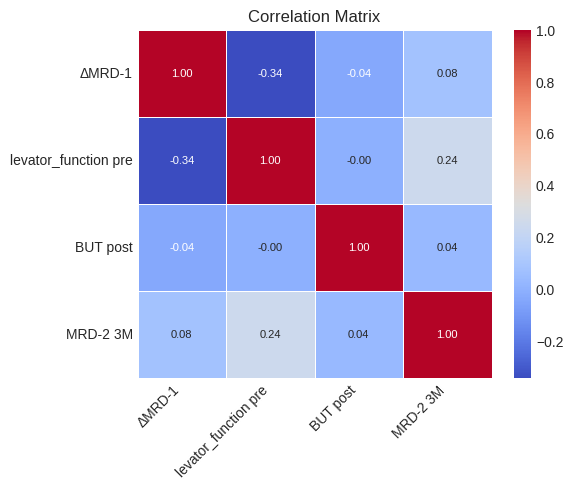


Correlation Matrix:


ΔMRD-1  levator_function pre  BUT post  MRD-2 3M
ΔMRD-1                 1.000                -0.343    -0.038     0.077
levator_function pre  -0.343                 1.000    -0.003     0.244
BUT post              -0.038                -0.003     1.000     0.035
MRD-2 3M               0.077                 0.244     0.035     1.000


Highly correlated pairs (abs > 0.7):
None found.

Variance Inflation Factor (VIF):


Variable     VIF
0                ΔMRD-1   5.702
1  levator_function pre  21.600
2              BUT post   4.951
3              MRD-2 3M  35.041

Variable        VIF
0                ΔMRD-1   5.702127
1  levator_function pre  21.600260
3              MRD-2 3M  35.040822


--- Summary (Auto Selected Post-op Model) ---
                           Logit Regression Results                           
Dep. Variable:               SPK post   No. Observations:                  102
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            4
Date:                Mon, 12 May 2025   Pseudo R-squ.:                  0.2213
Time:                        14:43:19   Log-Likelihood:                -49.407
converged:                       True   LL-Null:                       -63.449
Covariance Type:            nonrobust   LLR p-value:                 1.199e-05
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0882      2.136     -0.041      0.967      -4.274       4.097
ΔMRD-1                   0.1103      0.196      0.562 

CI 2.5%  CI 97.5%  Odds Ratio
const                   0.014    60.182       0.916
ΔMRD-1                  0.760     1.640       1.117
levator_function pre    0.489     0.844       0.642
BUT post                0.548     0.876       0.693
MRD-2 3M                1.091     6.905       2.744



=== Pre-operative Model: Auto Selection & Evaluation ===
Total combinations to evaluate: 31 using 5 candidate variables.


Evaluating subsets:   0%|          | 0/5 [00:00<?, ?it/s]


Best subset search took 0.33 seconds.

--- Top 10 Models (Pre-operative based on Training AUC) ---


num_vars                                          variables  n_samples  \
0         5  MRD-1 pre, ΔMRD-1, levator_function pre, MRD-2...        102   
1         4   ΔMRD-1, levator_function pre, MRD-2 pre, BUT pre        102   
2         4  MRD-1 pre, ΔMRD-1, levator_function pre, MRD-2...        102   
3         3           levator_function pre, MRD-2 pre, BUT pre        102   
4         4   MRD-1 pre, ΔMRD-1, levator_function pre, BUT pre        102   
5         3              ΔMRD-1, levator_function pre, BUT pre        102   
6         4  MRD-1 pre, levator_function pre, MRD-2 pre, BU...        102   
7         3            ΔMRD-1, levator_function pre, MRD-2 pre        102   
8         3            MRD-1 pre, ΔMRD-1, levator_function pre        102   
9         3         MRD-1 pre, levator_function pre, MRD-2 pre        102   

      auc  max_vif  
0  0.7326   28.590  
1  0.7241   28.116  
2  0.7232   26.644  
3  0.7228   17.584  
4  0.7228    9.881  
5  0.7225    5.491  
6  0.7223   20.250  
7  0.7156   25.900  
8  0.7143    8.754  
9  0.7062   20.013


--- Best Pre-operative Model (Auto Selected: Parsimony in Top 10 AUC) ---
Variables (3): levator_function pre, MRD-2 pre, BUT pre
Training AUC: 0.7228
(Model ranked #4 overall by AUC)
Number of samples used: 102
Max VIF (for info): 17.584

--- Detailed Collinearity Check (Auto Selected Pre-op Model) ---

--- Detailed Collinearity Check for variables: levator_function pre, MRD-2 pre, BUT pre ---
Correlation matrix heatmap saved to /content/best_subset_parsimony_results/corr_matrix_levator_function pre_MRD-2 pre_BUT pre.png


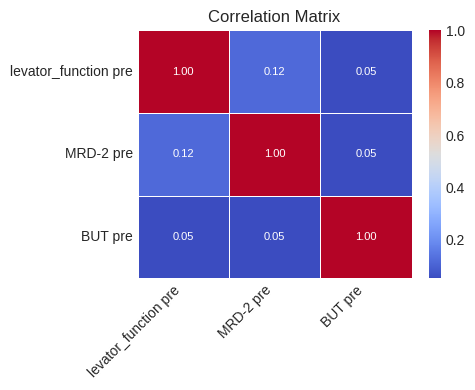


Correlation Matrix:


levator_function pre  MRD-2 pre  BUT pre
levator_function pre                 1.000      0.117    0.053
MRD-2 pre                            0.117      1.000    0.052
BUT pre                              0.053      0.052    1.000


Highly correlated pairs (abs > 0.7):
None found.

Variance Inflation Factor (VIF):


Variable     VIF
0  levator_function pre  16.455
1             MRD-2 pre  17.584
2               BUT pre   3.726

Variable        VIF
0  levator_function pre  16.454599
1             MRD-2 pre  17.584128


--- Summary (Auto Selected Pre-op Model) ---
                           Logit Regression Results                           
Dep. Variable:               SPK post   No. Observations:                  102
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            3
Date:                Mon, 12 May 2025   Pseudo R-squ.:                  0.1306
Time:                        14:43:20   Log-Likelihood:                -55.166
converged:                       True   LL-Null:                       -63.449
Covariance Type:            nonrobust   LLR p-value:                 0.0008675
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0934      1.884      0.050      0.960      -3.600       3.786
levator_function pre    -0.3789      0.117     -3.247  

CI 2.5%  CI 97.5%  Odds Ratio
const                   0.027    44.099       1.098
levator_function pre    0.545     0.861       0.685
MRD-2 pre               0.955     3.798       1.905
BUT pre                 0.739     1.063       0.886



--- 6. Performing 5-Fold Cross-Validation on Auto-Selected Models ---

--- Cross-Validation for Auto-Selected Post-operative Model (4 vars) ---
Cross-Validation AUC Scores: [0.9286 0.6786 0.881  0.8214 0.7143]
Mean CV AUC: 0.8048
Std Dev CV AUC: 0.0954

--- Cross-Validation for Auto-Selected Pre-operative Model (3 vars) ---
Cross-Validation AUC Scores: [0.9388 0.5102 0.75   0.7083 0.5714]
Mean CV AUC: 0.6957
Std Dev CV AUC: 0.1497


=== Final Auto-Selected Model Summary (Parsimony in Top N AUC) ===
Selection based on: Most parsimonious model within Top 10 Training AUC scores.
VIF Threshold used for final check (not selection): 5.0

--- Post-operative Model ---
Selected Variables (4): ΔMRD-1, levator_function pre, BUT post, MRD-2 3M
Training AUC: 0.8129 (Ranked #10 overall)
Max VIF (for info): 35.041
Mean 5-Fold CV AUC: 0.8048

--- Pre-operative Model ---
Selected Variables (3): levator_function pre, MRD-2 pre, BUT pre
Training AUC: 0.7228 (Ranked #4 overall)
Max VIF (for info): 17.58

In [ ]:
# =============================================================
# 眼瞼下垂術後SPKリスク解析：Top N AUC内 最少変数モデル自動選択 + CV
# =============================================================

# -------------------------------------------------------------
# 0. ライブラリのインポートと基本設定 (変更なし)
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from tqdm.auto import tqdm

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.sm_exceptions import PerfectSeparationError, ConvergenceWarning

from sklearn.metrics import roc_auc_score, roc_curve, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from IPython.display import display
import warnings
import os
import time

warnings.filterwarnings('ignore', category=RuntimeWarning)
# (以下、他の警告抑制も同様)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', message="Maximum Likelihood optimization failed to converge")

print("Libraries imported and warnings configured.")

# -------------------------------------------------------------
# 1. Google Drive マウント と ファイル/フォルダ設定 (変更なし)
# -------------------------------------------------------------
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True) # 必要に応じて再マウント
    file_path = "/content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ_kit.xlsx"
    output_dir = "/content/best_subset_parsimony_results" # 新しいフォルダ名
    print("Google Drive mounted.")
except ModuleNotFoundError:
    print("Running in a non-Colab environment.")
    file_path = "眼瞼下垂★ドライアイ_kit.xlsx"
    output_dir = "./best_subset_parsimony_results"

os.makedirs(output_dir, exist_ok=True)
print(f"Output directory: {output_dir}")

# -------------------------------------------------------------
# 2. データ読み込みと前処理 (変更なし)
# -------------------------------------------------------------
print("\n--- 2. Loading and Preprocessing Data ---")
try:
    df_all = pd.read_excel(file_path, sheet_name="対象症例sides", header=0)
    print(f"Excel file loaded successfully. Original shape: {df_all.shape}")
except FileNotFoundError: print(f"Error: File not found at {file_path}"); exit()
except Exception as e: print(f"Error loading Excel file: {e}"); exit()

cols_to_convert = ["MRD-1 pre", "MRD-1 3M", "MRD-2 pre", "MRD-2 3M", "levator_function pre", "BUT pre", "BUT post", "SPK pre", "SPK post"]
for col in cols_to_convert:
    if col in df_all.columns: df_all[col] = pd.to_numeric(df_all[col], errors='coerce')
    else: print(f"Warning: Column '{col}' not found.")

if "MRD-1 3M" in df_all and "MRD-1 pre" in df_all: df_all["ΔMRD-1"] = df_all["MRD-1 3M"] - df_all["MRD-1 pre"]
else: df_all["ΔMRD-1"] = np.nan
if "MRD-2 3M" in df_all and "MRD-2 pre" in df_all: df_all["ΔMRD-2"] = df_all["MRD-2 3M"] - df_all["MRD-2 pre"]
else: df_all["ΔMRD-2"] = np.nan

if "SPK pre" in df_all: df = df_all[df_all["SPK pre"] == 0].copy()
else: print("Error: 'SPK pre' column not found."); exit()
if "SPK post" not in df: print("Error: 'SPK post' column not found."); exit()

df_analysis = df[df['SPK post'].isin([0, 1])].copy()
df_analysis['SPK post'] = df_analysis['SPK post'].astype(int)
target_col = 'SPK post'

print(f"Analysis data shape (SPK pre=0, SPK post=0 or 1): {df_analysis.shape}")
if df_analysis.empty or df_analysis[target_col].nunique() < 2: print("Error: Insufficient data."); exit()
print(f"Target variable '{target_col}' distribution:\n{df_analysis[target_col].value_counts()}")


# -------------------------------------------------------------
# 3. 総当たり実行関数 (変更なし)
# -------------------------------------------------------------
# run_best_subset_logit 関数は前回のままでOK (VIF計算は含まれていても問題ない)
def run_best_subset_logit(df, target_col, candidate_cols):
    # (前回のコードと同じ内容 - ここでは省略)
    results = []
    n_candidates = len(candidate_cols)
    valid_candidate_cols = [col for col in candidate_cols if col in df.columns]
    n_candidates = len(valid_candidate_cols)
    if n_candidates == 0: return pd.DataFrame()

    total_combinations = sum(1 for k in range(1, n_candidates + 1) for _ in combinations(valid_candidate_cols, k))
    print(f"Total combinations to evaluate: {total_combinations} using {n_candidates} candidate variables.")

    # --- VIF計算ヘルパー関数を内部で定義 ---
    def calculate_max_vif_internal(df_sub, predictor_cols_sub):
        if not predictor_cols_sub or len(predictor_cols_sub) < 2: return 0.0
        X_vif_sub = df_sub[predictor_cols_sub].copy() # df_sub は既にdropna済みと仮定
        if X_vif_sub.shape[0] < 2: return np.inf
        try:
            vif_values_sub = [variance_inflation_factor(X_vif_sub.values, i) for i in range(X_vif_sub.shape[1])]
            max_vif_val = np.max(vif_values_sub)
            return np.inf if np.isinf(max_vif_val) else max_vif_val
        except Exception: return np.inf
    # --- ここまで VIF計算ヘルパー ---

    for k in tqdm(range(1, n_candidates + 1), desc="Evaluating subsets"):
        for subset_cols in combinations(valid_candidate_cols, k):
            subset_cols_list = list(subset_cols)
            required_cols = [target_col] + subset_cols_list
            df_subset = df[required_cols].dropna()
            n_samples = len(df_subset)
            n_classes = df_subset[target_col].nunique()
            min_samples_needed = len(subset_cols_list) + 2

            if n_samples < min_samples_needed or n_classes < 2:
                results.append({'num_vars': k, 'variables': ', '.join(subset_cols_list), 'n_samples': n_samples, 'auc': np.nan, 'model': None, 'error': 'Insufficient data', 'max_vif': np.nan})
                continue

            y = df_subset[target_col]
            X = df_subset[subset_cols_list]
            X_const = sm.add_constant(X, has_constant='add')

            auc = np.nan; model_fit = None; error_msg = None; max_vif = np.nan

            try:
                logit_model = sm.Logit(y, X_const)
                model_fit = logit_model.fit(disp=False, maxiter=100, warn_convergence=False)

                if model_fit.mle_retvals['converged']:
                    y_pred_prob = model_fit.predict(X_const)
                    auc = roc_auc_score(y, y_pred_prob)
                    max_vif = calculate_max_vif_internal(df_subset, subset_cols_list) # VIFも計算しておく
                else: error_msg = 'Convergence Failed'

            except PerfectSeparationError: error_msg = 'PerfectSeparationError'; max_vif = np.inf
            except np.linalg.LinAlgError: error_msg = 'LinAlgError'; max_vif = np.inf
            except ValueError as ve: error_msg = f'ValueError: {ve}'; max_vif = np.inf
            except Exception as e: error_msg = f'Other Error: {type(e).__name__}'; max_vif = np.inf

            results.append({'num_vars': k, 'variables': ', '.join(subset_cols_list), 'n_samples': n_samples, 'auc': auc, 'model': model_fit, 'error': error_msg, 'max_vif': max_vif})

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='auc', ascending=False, na_position='last').reset_index(drop=True)
    return results_df

# -------------------------------------------------------------
# 4. 共線性チェック関数 (変更なし)
# -------------------------------------------------------------
# check_collinearity 関数は前回のコードと同じものを使用します
def check_collinearity(df, predictor_cols, vif_threshold=5.0, output_dir="."):
    # (前回のコードと同じ内容 - ここでは省略)
    if not predictor_cols or len(predictor_cols) < 2: print("Collinearity check skipped."); return None, None
    print(f"\n--- Detailed Collinearity Check for variables: {', '.join(predictor_cols)} ---")
    df_check = df[predictor_cols].dropna();
    if df_check.shape[0] < 2: print("Warning: Insufficient data."); return None, None
    corr_matrix=None; vif_data=None # Initialize
    try: # Correlation
        corr_matrix = df_check.corr(); plt.figure(figsize=(min(10, len(predictor_cols)+2), min(8, len(predictor_cols)+1)))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8})
        plt.title("Correlation Matrix"); plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0); plt.tight_layout()
        corr_fig_path = os.path.join(output_dir, f"corr_matrix_{'_'.join(predictor_cols[:3])}.png")
        plt.savefig(corr_fig_path, dpi=300); print(f"Correlation matrix heatmap saved to {corr_fig_path}"); plt.show()
        print("\nCorrelation Matrix:"); display(corr_matrix.round(3))
        high_corr_pairs = corr_matrix.unstack().sort_values(ascending=False).drop_duplicates(); high_corr_pairs = high_corr_pairs[high_corr_pairs < 1.0]
        significant_high_corr = high_corr_pairs[abs(high_corr_pairs) > 0.7]; print("\nHighly correlated pairs (abs > 0.7):")
        if not significant_high_corr.empty:
            display(significant_high_corr)
        else:
            print("None found.")
    except Exception as e: print(f"Error during correlation analysis: {e}")
    if len(predictor_cols) >= 2: # VIF
        X_vif = df_check.copy()
        try:
            vif_data = pd.DataFrame(); vif_data["Variable"] = X_vif.columns; vif_values = []
            for i in range(X_vif.shape[1]):
                 try: v = variance_inflation_factor(X_vif.values, i); vif_values.append(v)
                 except Exception as vif_e: print(f"VIF Error for {X_vif.columns[i]}: {vif_e}"); vif_values.append(np.nan)
            vif_data["VIF"] = vif_values; print("\nVariance Inflation Factor (VIF):"); display(vif_data.round(3))
            high_vif_vars = vif_data[vif_data["VIF"] > vif_threshold]
            if not high_vif_vars.empty: print(f"\nWarning: Variables with VIF > {vif_threshold}:"); display(high_vif_vars)
            else: print(f"\nNo variables found with VIF > {vif_threshold}.")
        except Exception as e: print(f"\nCould not calculate VIF: {e}")
    return corr_matrix, vif_data

# -------------------------------------------------------------
# 5. メイン処理: 自動選択(TopN内最少変数)と評価
# -------------------------------------------------------------
print("\n--- 5. Main Processing: Automatic Selection (Parsimony in Top N AUC) & Evaluation ---")

# パラメータ設定
TOP_N_MODELS = 10 # 上位何件のAUCモデルを考慮するか
VIF_THRESHOLD_FOR_CHECK = 5.0 # 最終チェック用のVIF閾値 (選択基準ではない)
print(f"Selection Criteria: Most parsimonious model within Top {TOP_N_MODELS} Training AUC scores.")

# --- 5a. 術後モデル ---
print("\n======================================================")
print("=== Post-operative Model: Auto Selection & Evaluation ===")
print("======================================================")

post_candidate_cols = ["MRD-1 pre", "ΔMRD-1", "levator_function pre", "BUT post",
                       "MRD-2 pre", "ΔMRD-2", "MRD-2 3M", "BUT pre"]
post_candidate_cols_valid = [col for col in post_candidate_cols if col in df_analysis.columns]

selected_post_model = None
selected_post_vars = []
mean_cv_auc_post = np.nan
post_results_df = pd.DataFrame() # 結果格納用

if post_candidate_cols_valid:
    start_time_post = time.time()
    post_results_df = run_best_subset_logit(df_analysis, target_col, post_candidate_cols_valid)
    end_time_post = time.time()
    print(f"\nBest subset search took {end_time_post - start_time_post:.2f} seconds.")

    # 有効なモデル（エラーなし、AUC計算済み）をフィルタリング
    valid_models_post = post_results_df[
        post_results_df['error'].isna() & post_results_df['auc'].notna()
    ].copy()

    if not valid_models_post.empty:
        # 上位 N 件を取得
        top_n_post = valid_models_post.head(TOP_N_MODELS)
        print(f"\n--- Top {TOP_N_MODELS} Models (Post-operative based on Training AUC) ---")
        display(top_n_post[['num_vars', 'variables', 'n_samples', 'auc', 'max_vif']].round({'auc': 4, 'max_vif': 3})) # VIFも参考表示

        if not top_n_post.empty:
            # Top N の中で最小の変数数を見つける
            min_vars_in_top_n = top_n_post['num_vars'].min()

            # 最小変数数のモデルを抽出
            most_parsimonious_top_n = top_n_post[top_n_post['num_vars'] == min_vars_in_top_n]

            # その中でAUCが最高のモデルを選択 (既にソートされているので先頭)
            auto_selected_post_row = most_parsimonious_top_n.iloc[0]

            selected_post_vars = auto_selected_post_row['variables'].split(', ')
            selected_post_model = auto_selected_post_row['model']

            print(f"\n--- Best Post-operative Model (Auto Selected: Parsimony in Top {TOP_N_MODELS} AUC) ---")
            print(f"Variables ({auto_selected_post_row['num_vars']}): {', '.join(selected_post_vars)}")
            print(f"Training AUC: {auto_selected_post_row['auc']:.4f}")
            print(f"(Model ranked #{auto_selected_post_row.name + 1} overall by AUC)") # 元のDFでの順位
            print(f"Number of samples used: {auto_selected_post_row['n_samples']}")
            print(f"Max VIF (for info): {auto_selected_post_row['max_vif']:.3f}") # 参考情報

            # 詳細な共線性チェックとサマリー表示
            if selected_post_model:
                print("\n--- Detailed Collinearity Check (Auto Selected Post-op Model) ---")
                _ = check_collinearity(df_analysis, selected_post_vars, vif_threshold=VIF_THRESHOLD_FOR_CHECK, output_dir=output_dir)
                print(f"\n--- Summary (Auto Selected Post-op Model) ---")
                try:
                    xnames_post_auto = ['Intercept'] + selected_post_vars
                    print(selected_post_model.summary(xname=xnames_post_auto))
                    print("\nOdds Ratios:")
                    conf_auto_post = selected_post_model.conf_int()
                    conf_auto_post['Odds Ratio'] = selected_post_model.params
                    conf_auto_post.columns = ['CI 2.5%', 'CI 97.5%', 'Odds Ratio']
                    display(np.exp(conf_auto_post).round(3))
                except Exception as e: print(f"Could not display model summary: {e}")
            else: print("Model object not available for summary.")
        else:
            print(f"\nWarning: No valid models found within the Top {TOP_N_MODELS} AUC ranks.")
    else:
        print("\nWarning: No valid models found from the best subset search.")
else:
    print("\nSkipping post-operative model search: No valid candidate variables.")


# --- 5b. 術前モデル ---
print("\n\n======================================================")
print("=== Pre-operative Model: Auto Selection & Evaluation ===")
print("======================================================")

preop_candidate_cols = ["MRD-1 pre", "ΔMRD-1", "levator_function pre",
                        "MRD-2 pre", "BUT pre"]
preop_candidate_cols_valid = [col for col in preop_candidate_cols if col in df_analysis.columns]

selected_preop_model = None
selected_preop_vars = []
mean_cv_auc_preop = np.nan
preop_results_df = pd.DataFrame() # 結果格納用

if preop_candidate_cols_valid:
    start_time_preop = time.time()
    preop_results_df = run_best_subset_logit(df_analysis, target_col, preop_candidate_cols_valid)
    end_time_preop = time.time()
    print(f"\nBest subset search took {end_time_preop - start_time_preop:.2f} seconds.")

    # 有効なモデルをフィルタリング
    valid_models_preop = preop_results_df[
        preop_results_df['error'].isna() & preop_results_df['auc'].notna()
    ].copy()

    if not valid_models_preop.empty:
        # 上位 N 件を取得
        top_n_preop = valid_models_preop.head(TOP_N_MODELS)
        print(f"\n--- Top {TOP_N_MODELS} Models (Pre-operative based on Training AUC) ---")
        display(top_n_preop[['num_vars', 'variables', 'n_samples', 'auc', 'max_vif']].round({'auc': 4, 'max_vif': 3}))

        if not top_n_preop.empty:
            # Top N 内で最小変数数
            min_vars_in_top_n_preop = top_n_preop['num_vars'].min()
            # 最小変数数のモデルを抽出
            most_parsimonious_top_n_preop = top_n_preop[top_n_preop['num_vars'] == min_vars_in_top_n_preop]
            # AUC最高のものを選択
            auto_selected_preop_row = most_parsimonious_top_n_preop.iloc[0]

            selected_preop_vars = auto_selected_preop_row['variables'].split(', ')
            selected_preop_model = auto_selected_preop_row['model']

            print(f"\n--- Best Pre-operative Model (Auto Selected: Parsimony in Top {TOP_N_MODELS} AUC) ---")
            print(f"Variables ({auto_selected_preop_row['num_vars']}): {', '.join(selected_preop_vars)}")
            print(f"Training AUC: {auto_selected_preop_row['auc']:.4f}")
            print(f"(Model ranked #{auto_selected_preop_row.name + 1} overall by AUC)")
            print(f"Number of samples used: {auto_selected_preop_row['n_samples']}")
            print(f"Max VIF (for info): {auto_selected_preop_row['max_vif']:.3f}")

            # 詳細チェックとサマリー
            if selected_preop_model:
                print("\n--- Detailed Collinearity Check (Auto Selected Pre-op Model) ---")
                _ = check_collinearity(df_analysis, selected_preop_vars, vif_threshold=VIF_THRESHOLD_FOR_CHECK, output_dir=output_dir)
                print(f"\n--- Summary (Auto Selected Pre-op Model) ---")
                try:
                    xnames_preop_auto = ['Intercept'] + selected_preop_vars
                    print(selected_preop_model.summary(xname=xnames_preop_auto))
                    print("\nOdds Ratios:")
                    conf_auto_preop = selected_preop_model.conf_int()
                    conf_auto_preop['Odds Ratio'] = selected_preop_model.params
                    conf_auto_preop.columns = ['CI 2.5%', 'CI 97.5%', 'Odds Ratio']
                    display(np.exp(conf_auto_preop).round(3))
                except Exception as e: print(f"Could not display model summary: {e}")
            else: print("Model object not available for summary.")
        else:
            print(f"\nWarning: No valid models found within the Top {TOP_N_MODELS} AUC ranks.")
    else:
        print("\nWarning: No valid models found from the best subset search.")
else:
    print("\nSkipping pre-operative model search: No valid candidate variables.")


# -------------------------------------------------------------
# 6. クロスバリデーション (自動選択されたモデルに対して)
# -------------------------------------------------------------
print("\n\n--- 6. Performing 5-Fold Cross-Validation on Auto-Selected Models ---")
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# --- CV用 術後モデル ---
if selected_post_vars:
    print(f"\n--- Cross-Validation for Auto-Selected Post-operative Model ({len(selected_post_vars)} vars) ---")
    df_cv_post = df_analysis[[target_col] + selected_post_vars].dropna()
    y_cv_post = df_cv_post[target_col]
    X_cv_post = df_cv_post[selected_post_vars]

    if X_cv_post.shape[0] >= n_splits and y_cv_post.nunique() == 2:
        pipeline_post = Pipeline([
            ('scaler', StandardScaler()),
            ('logistic', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))
        ])
        try:
            cv_auc_scores_post = cross_val_score(pipeline_post, X_cv_post, y_cv_post, cv=cv, scoring='roc_auc', n_jobs=-1)
            mean_cv_auc_post = cv_auc_scores_post.mean()
            std_cv_auc_post = cv_auc_scores_post.std()
            print(f"Cross-Validation AUC Scores: {np.round(cv_auc_scores_post, 4)}")
            print(f"Mean CV AUC: {mean_cv_auc_post:.4f}")
            print(f"Std Dev CV AUC: {std_cv_auc_post:.4f}")
        except Exception as e: print(f"Cross-validation failed: {e}")
    else: print("Insufficient data/classes for CV.")
else: print("\nSkipping CV for Post-operative model: No model was automatically selected.")

# --- CV用 術前モデル ---
if selected_preop_vars:
    print(f"\n--- Cross-Validation for Auto-Selected Pre-operative Model ({len(selected_preop_vars)} vars) ---")
    df_cv_preop = df_analysis[[target_col] + selected_preop_vars].dropna()
    y_cv_preop = df_cv_preop[target_col]
    X_cv_preop = df_cv_preop[selected_preop_vars]

    if X_cv_preop.shape[0] >= n_splits and y_cv_preop.nunique() == 2:
        pipeline_preop = Pipeline([
            ('scaler', StandardScaler()),
            ('logistic', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))
        ])
        try:
            cv_auc_scores_preop = cross_val_score(pipeline_preop, X_cv_preop, y_cv_preop, cv=cv, scoring='roc_auc', n_jobs=-1)
            mean_cv_auc_preop = cv_auc_scores_preop.mean()
            std_cv_auc_preop = cv_auc_scores_preop.std()
            print(f"Cross-Validation AUC Scores: {np.round(cv_auc_scores_preop, 4)}")
            print(f"Mean CV AUC: {mean_cv_auc_preop:.4f}")
            print(f"Std Dev CV AUC: {std_cv_auc_preop:.4f}")
        except Exception as e: print(f"Cross-validation failed: {e}")
    else: print("Insufficient data/classes for CV.")
else: print("\nSkipping CV for Pre-operative model: No model was automatically selected.")


# -------------------------------------------------------------
# 7. 最終結果サマリー
# -------------------------------------------------------------
print("\n\n======================================================")
print("=== Final Auto-Selected Model Summary (Parsimony in Top N AUC) ===")
print("======================================================")
print(f"Selection based on: Most parsimonious model within Top {TOP_N_MODELS} Training AUC scores.")
print(f"VIF Threshold used for final check (not selection): {VIF_THRESHOLD_FOR_CHECK}")


print("\n--- Post-operative Model ---")
if selected_post_vars:
    # 再度ベスト行を取得して表示
    auto_selected_post_row = top_n_post[top_n_post['num_vars'] == top_n_post['num_vars'].min()].iloc[0]
    print(f"Selected Variables ({auto_selected_post_row['num_vars']}): {', '.join(selected_post_vars)}")
    print(f"Training AUC: {auto_selected_post_row['auc']:.4f} (Ranked #{auto_selected_post_row.name + 1} overall)")
    print(f"Max VIF (for info): {auto_selected_post_row['max_vif']:.3f}")
    print(f"Mean 5-Fold CV AUC: {mean_cv_auc_post:.4f}")
else:
    print("No suitable model selected based on the criteria.")

print("\n--- Pre-operative Model ---")
if selected_preop_vars:
    # 再度ベスト行を取得して表示
    auto_selected_preop_row = top_n_preop[top_n_preop['num_vars'] == top_n_preop['num_vars'].min()].iloc[0]
    print(f"Selected Variables ({auto_selected_preop_row['num_vars']}): {', '.join(selected_preop_vars)}")
    print(f"Training AUC: {auto_selected_preop_row['auc']:.4f} (Ranked #{auto_selected_preop_row.name + 1} overall)")
    print(f"Max VIF (for info): {auto_selected_preop_row['max_vif']:.3f}")
    print(f"Mean 5-Fold CV AUC: {mean_cv_auc_preop:.4f}")
else:
    print("No suitable model selected based on the criteria.")

print("\nReminder: High Training AUC with a significant drop in CV AUC suggests overfitting.")
print("Review the selected model's summary, VIF check, and CV results to make a final decision.")
print(f"\nAnalysis Complete. Check '{output_dir}' for correlation heatmaps.")

Libraries imported and warnings configured.
Mounted at /content/drive
Google Drive mounted.
Output directory: /content/best_subset_required_cv_results

--- 2. Loading and Preprocessing Data ---
Excel file loaded successfully. Original shape: (172, 32)
Analysis data shape (SPK pre=0, SPK post=0 or 1): (102, 32)
Target variable 'SPK post' distribution:
SPK post
0    70
1    32
Name: count, dtype: int64

--- 5. Main Processing: Required Vars + CV on Top N models ---
Selection Criteria: Best Mean 10-Fold CV AUC among Top 100 Training AUC models (requiring specified variables).
Required variable(s): BUT pre

=== Post-operative Model: Required Vars + CV Selection ===
Post-operative candidate variables (8): BUT post, BUT pre, MRD-1 pre, MRD-2 3M, MRD-2 pre, levator_function pre, ΔMRD-1, ΔMRD-2
Total combinations to evaluate: 128 (required: 1, optional: 7)


Evaluating subsets:   0%|          | 0/8 [00:00<?, ?it/s]


Best subset search took 2.42 seconds.

--- Performing 10-Fold CV on Top 100 Training AUC Models (Post-operative, requiring ['BUT pre']) ---


CV on Top Models:   0%|          | 0/100 [00:00<?, ?it/s]

Cross-validation for Top 100 models took 12.05 seconds.

--- Top 100 Models Ranked by Mean CV AUC (Post-operative, requiring ['BUT pre']) ---


num_vars                                          variables  training_auc  \
15         4  BUT post, BUT pre, MRD-2 3M, levator_function pre        0.8018   
11         5  BUT post, BUT pre, MRD-2 3M, MRD-2 pre, levato...        0.8020   
13         5  BUT post, BUT pre, MRD-2 pre, levator_function...        0.8020   
16         5  BUT post, BUT pre, MRD-1 pre, MRD-2 3M, levato...        0.8013   
12         6  BUT post, BUT pre, MRD-2 3M, MRD-2 pre, levato...        0.8020   
..       ...                                                ...           ...   
90         3                          BUT post, BUT pre, ΔMRD-2        0.7145   
96         4               BUT pre, MRD-1 pre, MRD-2 3M, ΔMRD-1        0.6857   
97         5       BUT pre, MRD-1 pre, MRD-2 3M, ΔMRD-1, ΔMRD-2        0.6779   
98         6  BUT pre, MRD-1 pre, MRD-2 3M, MRD-2 pre, ΔMRD-...        0.6779   
99         5    BUT pre, MRD-1 pre, MRD-2 3M, MRD-2 pre, ΔMRD-1        0.6779   

    mean_cv_auc  std_cv_auc   max_vif  
15       0.7786      0.1355   23.3523  
11       0.7786      0.1355  223.3818  
13       0.7750      0.1320   24.2209  
16       0.7738      0.1335   26.6131  
12       0.7702      0.1280       inf  
..          ...         ...       ...  
90       0.6417      0.1311    3.8371  
96       0.6131      0.1800   15.6649  
97       0.5976      0.1681   15.6984  
98       0.5976      0.1681       inf  
99       0.5976      0.1681  190.6291  

[100 rows x 6 columns]


--- Best Post-operative Model (Selected by Highest Mean CV AUC, requiring ['BUT pre']) ---
Variables (4): BUT post, BUT pre, MRD-2 3M, levator_function pre
Mean 10-Fold CV AUC: 0.7786 (+/- 0.1355)
Original Training AUC: 0.8018
Max VIF (for info): 23.352

--- Detailed Collinearity Check (Final Selected Post-op Model) ---

--- Detailed Collinearity Check for variables: BUT post, BUT pre, MRD-2 3M, levator_function pre ---
Correlation matrix heatmap saved to /content/best_subset_required_cv_results/corr_matrix_BUT_post_BUT_pre_MRD2_3M_levator_function_pre.png


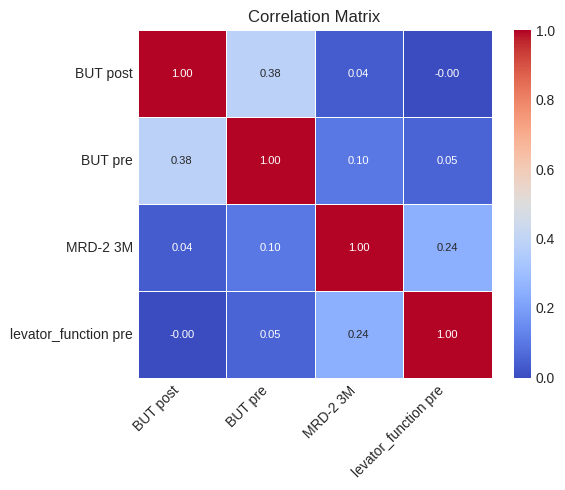


Correlation Matrix:


BUT post  BUT pre  MRD-2 3M  levator_function pre
BUT post                 1.000    0.381     0.035                -0.003
BUT pre                  0.381    1.000     0.099                 0.053
MRD-2 3M                 0.035    0.099     1.000                 0.244
levator_function pre    -0.003    0.053     0.244                 1.000


Highly correlated pairs (abs > 0.7):
None found.

Variance Inflation Factor (VIF):


Variable     VIF
0              BUT post   5.834
1               BUT pre   4.469
2              MRD-2 3M  23.352
3  levator_function pre  19.610

Variable     VIF
0              BUT post   5.834
2              MRD-2 3M  23.352
3  levator_function pre  19.610


--- Summary (Final Selected Post-op Model, Refit on Full Data) ---
                           Logit Regression Results                           
Dep. Variable:               SPK post   No. Observations:                  102
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            4
Date:                Mon, 12 May 2025   Pseudo R-squ.:                  0.2212
Time:                        15:28:00   Log-Likelihood:                -49.416
converged:                       True   LL-Null:                       -63.449
Covariance Type:            nonrobust   LLR p-value:                 1.210e-05
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.2534      2.047      0.124      0.901      -3.758       4.265
BUT post                -0.3627  

CI 2.5%  CI 97.5%  Odds Ratio
const                   0.023    71.164       1.288
BUT post                0.547     0.885       0.696
BUT pre                 0.761     1.168       0.943
MRD-2 3M                1.196     7.554       3.006
levator_function pre    0.482     0.809       0.624



=== Pre-operative Model: Required Vars + CV Selection ===
Pre-operative candidate variables (5): BUT pre, MRD-1 pre, MRD-2 pre, levator_function pre, ΔMRD-1
Total combinations to evaluate: 16 (required: 1, optional: 4)


Evaluating subsets:   0%|          | 0/5 [00:00<?, ?it/s]


Best subset search took 0.19 seconds.

--- Performing 10-Fold CV on Top 16 Training AUC Models (Pre-operative, requiring ['BUT pre']) ---


CV on Top Models:   0%|          | 0/16 [00:00<?, ?it/s]

Cross-validation for Top 16 models took 2.25 seconds.

--- Top 16 Models Ranked by Mean CV AUC (Pre-operative, requiring ['BUT pre']) ---


num_vars                                          variables  training_auc  \
4          3              BUT pre, levator_function pre, ΔMRD-1        0.7225   
2          3           BUT pre, MRD-2 pre, levator_function pre        0.7228   
6          2                      BUT pre, levator_function pre        0.7049   
3          4   BUT pre, MRD-1 pre, levator_function pre, ΔMRD-1        0.7228   
7          3           BUT pre, MRD-1 pre, levator_function pre        0.7018   
5          4  BUT pre, MRD-1 pre, MRD-2 pre, levator_functio...        0.7223   
1          4   BUT pre, MRD-2 pre, levator_function pre, ΔMRD-1        0.7241   
0          5  BUT pre, MRD-1 pre, MRD-2 pre, levator_functio...        0.7326   
11         2                                    BUT pre, ΔMRD-1        0.6596   
10         3                         BUT pre, MRD-1 pre, ΔMRD-1        0.6665   
9          3                         BUT pre, MRD-2 pre, ΔMRD-1        0.6737   
8          4              BUT pre, MRD-1 pre, MRD-2 pre, ΔMRD-1        0.6775   
12         3                      BUT pre, MRD-1 pre, MRD-2 pre        0.6592   
14         2                                 BUT pre, MRD-2 pre        0.6165   
13         2                                 BUT pre, MRD-1 pre        0.6384   
15         1                                            BUT pre        0.5636   

    mean_cv_auc  std_cv_auc  max_vif  
4        0.6821      0.2173   5.4914  
2        0.6714      0.2305  17.5841  
6        0.6690      0.2378   3.4356  
3        0.6679      0.2142   9.8812  
7        0.6643      0.2446   3.6449  
5        0.6643      0.2392  20.2498  
1        0.6583      0.2136  28.1161  
0        0.6488      0.2066  28.5904  
11       0.6268      0.1665   2.1984  
10       0.6190      0.1595   3.1530  
9        0.6042      0.1891   8.8662  
8        0.6024      0.1733  13.9966  
12       0.6012      0.2067   3.8120  
14       0.5935      0.2069   3.6715  
13       0.5732      0.1783   1.2113  
15       0.5560      0.1334   0.0000


--- Best Pre-operative Model (Selected by Highest Mean CV AUC, requiring ['BUT pre']) ---
Variables (3): BUT pre, levator_function pre, ΔMRD-1
Mean 10-Fold CV AUC: 0.6821 (+/- 0.2173)
Original Training AUC: 0.7225
Max VIF (for info): 5.491

--- Detailed Collinearity Check (Final Selected Pre-op Model) ---

--- Detailed Collinearity Check for variables: BUT pre, levator_function pre, ΔMRD-1 ---
Correlation matrix heatmap saved to /content/best_subset_required_cv_results/corr_matrix_BUT_pre_levator_function_pre_dMRD1.png


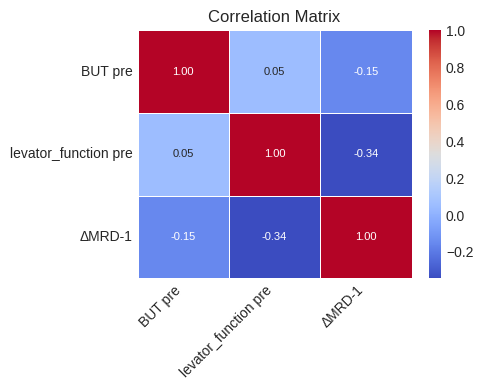


Correlation Matrix:


BUT pre  levator_function pre  ΔMRD-1
BUT pre                 1.000                 0.053  -0.153
levator_function pre    0.053                 1.000  -0.343
ΔMRD-1                 -0.153                -0.343   1.000


Highly correlated pairs (abs > 0.7):
None found.

Variance Inflation Factor (VIF):


Variable    VIF
0               BUT pre  3.467
1  levator_function pre  5.491
2                ΔMRD-1  3.514

Variable    VIF
1  levator_function pre  5.491


--- Summary (Final Selected Pre-op Model, Refit on Full Data) ---
                           Logit Regression Results                           
Dep. Variable:               SPK post   No. Observations:                  102
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            3
Date:                Mon, 12 May 2025   Pseudo R-squ.:                  0.1106
Time:                        15:28:03   Log-Likelihood:                -56.434
converged:                       True   LL-Null:                       -63.449
Covariance Type:            nonrobust   LLR p-value:                  0.002865
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.0192      1.407      1.435      0.151      -0.739       4.777
BUT pre                 -0.0924   

CI 2.5%  CI 97.5%  Odds Ratio
const                   0.478   118.788       7.532
BUT pre                 0.765     1.087       0.912
levator_function pre    0.577     0.921       0.729
ΔMRD-1                  0.845     1.717       1.204



=== Final Model Summary (Selected by Best Mean 10-Fold CV AUC from Top 100, requiring ['BUT pre']) ===

--- Post-operative Model ---
Selected Variables (4): BUT post, BUT pre, MRD-2 3M, levator_function pre
Mean 10-Fold CV AUC: 0.7786 (+/- 0.1355)
Original Training AUC: 0.8018
Max VIF (for info): 23.352

--- Pre-operative Model ---
Selected Variables (3): BUT pre, levator_function pre, ΔMRD-1
Mean 10-Fold CV AUC: 0.6821 (+/- 0.2173)
Original Training AUC: 0.7225
Max VIF (for info): 5.491

Reminder: Compare Training AUC and Mean CV AUC to assess potential overfitting.
Review the final selected model's summary and collinearity check (especially VIF) for interpretation.

Analysis Complete. Check '/content/best_subset_required_cv_results' for correlation heatmaps.


In [ ]:
# =============================================================
# 眼瞼下垂術後SPKリスク解析：必須変数指定 + Top10 CVによるベストモデル選択
# =============================================================

# -------------------------------------------------------------
# 0. ライブラリのインポートと基本設定
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from tqdm.auto import tqdm
import joblib # CV結果の保存/読み込み用 (オプション)

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.sm_exceptions import PerfectSeparationError, ConvergenceWarning

from sklearn.metrics import roc_auc_score, roc_curve, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from IPython.display import display
import warnings
import os
import time

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', message="Maximum Likelihood optimization failed to converge")

print("Libraries imported and warnings configured.")

# -------------------------------------------------------------
# 1. Google Drive マウント と ファイル/フォルダ設定
# -------------------------------------------------------------
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True) # 必要に応じて再マウント
    # ★★★ Google Drive内のExcelファイルのパスを指定してください ★★★
    file_path = "/content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ_kit.xlsx"
    # ★★★ 結果を出力するフォルダを指定してください ★★★
    output_dir = "/content/best_subset_required_cv_results" # 新しいフォルダ名
    print("Google Drive mounted.")
except ModuleNotFoundError:
    print("Running in a non-Colab environment.")
    # ★★★ ローカルのExcelファイルのパスを指定してください ★★★
    file_path = "眼瞼下垂★ドライアイ_kit.xlsx"
    # ★★★ 結果を出力するフォルダを指定してください ★★★
    output_dir = "./best_subset_required_cv_results"

os.makedirs(output_dir, exist_ok=True)
print(f"Output directory: {output_dir}")

# -------------------------------------------------------------
# 2. データ読み込みと前処理
# -------------------------------------------------------------
print("\n--- 2. Loading and Preprocessing Data ---")
try:
    df_all = pd.read_excel(file_path, sheet_name="対象症例sides", header=0)
    print(f"Excel file loaded successfully. Original shape: {df_all.shape}")
except FileNotFoundError: print(f"Error: File not found at {file_path}"); exit()
except Exception as e: print(f"Error loading Excel file: {e}"); exit()

# --- 数値変換、ΔMRD計算、フィルタリング (変更なし) ---
cols_to_convert = ["MRD-1 pre", "MRD-1 3M", "MRD-2 pre", "MRD-2 3M", "levator_function pre", "BUT pre", "BUT post", "SPK pre", "SPK post"]
for col in cols_to_convert:
    if col in df_all.columns: df_all[col] = pd.to_numeric(df_all[col], errors='coerce')
    else: print(f"Warning: Column '{col}' not found.")

if "MRD-1 3M" in df_all and "MRD-1 pre" in df_all: df_all["ΔMRD-1"] = df_all["MRD-1 3M"] - df_all["MRD-1 pre"]
else: df_all["ΔMRD-1"] = np.nan
if "MRD-2 3M" in df_all and "MRD-2 pre" in df_all: df_all["ΔMRD-2"] = df_all["MRD-2 3M"] - df_all["MRD-2 pre"]
else: df_all["ΔMRD-2"] = np.nan

if "SPK pre" in df_all: df = df_all[df_all["SPK pre"] == 0].copy()
else: print("Error: 'SPK pre' column not found."); exit()
if "SPK post" not in df: print("Error: 'SPK post' column not found."); exit()

df_analysis = df[df['SPK post'].isin([0, 1])].copy()
df_analysis['SPK post'] = df_analysis['SPK post'].astype(int)
target_col = 'SPK post'

print(f"Analysis data shape (SPK pre=0, SPK post=0 or 1): {df_analysis.shape}")
if df_analysis.empty or df_analysis[target_col].nunique() < 2: print("Error: Insufficient data."); exit()
print(f"Target variable '{target_col}' distribution:\n{df_analysis[target_col].value_counts()}")


# -------------------------------------------------------------
# 3. 総当たり実行関数 (必須変数指定に対応) ★★★ 修正箇所 ★★★
# -------------------------------------------------------------
def run_best_subset_logit_required(df, target_col, candidate_cols, required_cols=[]):
    """
    必須変数を指定可能なロジスティック回帰の総当たり変数選択を実行し、AUCを計算する関数。
    """
    results = []

    # --- 入力チェック ---
    valid_candidate_cols = [col for col in candidate_cols if col in df.columns]
    valid_required_cols = [col for col in required_cols if col in df.columns]

    missing_required = set(required_cols) - set(valid_required_cols)
    if missing_required:
        print(f"Warning: Required columns not found in dataframe and ignored: {list(missing_required)}")

    missing_in_candidates = set(valid_required_cols) - set(valid_candidate_cols)
    if missing_in_candidates:
         print(f"Warning: Required columns are not in candidate_cols but will be included: {list(missing_in_candidates)}")
         valid_candidate_cols = list(set(valid_candidate_cols) | set(valid_required_cols))

    optional_cols = [col for col in valid_candidate_cols if col not in valid_required_cols]
    n_optional = len(optional_cols)
    n_required = len(valid_required_cols)

    if n_required == 0 and n_optional == 0:
        print("Error: No valid candidate or required columns found.")
        return pd.DataFrame()

    total_combinations = sum(1 for k in range(n_optional + 1) for _ in combinations(optional_cols, k))
    print(f"Total combinations to evaluate: {total_combinations} (required: {n_required}, optional: {n_optional})")

    # --- VIF計算ヘルパー関数 ---
    def calculate_max_vif_internal(df_sub, predictor_cols_sub):
        if not predictor_cols_sub or len(predictor_cols_sub) < 2: return 0.0
        X_vif_sub = df_sub[predictor_cols_sub].copy()
        if X_vif_sub.shape[0] < 2: return np.inf
        try:
            is_constant = X_vif_sub.std() < 1e-9
            if is_constant.any(): X_vif_sub = X_vif_sub.loc[:, ~is_constant]
            if X_vif_sub.shape[1] < 2 or X_vif_sub.empty: return np.inf
            # VIF calculation can still fail if perfect collinearity exists after removing constant columns
            try:
                vif_values_sub = [variance_inflation_factor(X_vif_sub.values, i) for i in range(X_vif_sub.shape[1])]
                max_vif_val = np.max(vif_values_sub); return np.inf if np.isinf(max_vif_val) or np.isnan(max_vif_val) else max_vif_val
            except np.linalg.LinAlgError: # Catch explicit LinAlgError for perfect collinearity
                 return np.inf
        except Exception: return np.inf

    # --- 組み合わせループ (オプション変数の数でループ) ---
    for k in tqdm(range(n_optional + 1), desc="Evaluating subsets"):
        for optional_subset in combinations(optional_cols, k):
            subset_cols_list = sorted(list(valid_required_cols) + list(optional_subset))
            num_total_vars = len(subset_cols_list)
            if num_total_vars == 0 : continue

            required_cols_in_model = [target_col] + subset_cols_list
            df_subset = df[required_cols_in_model].dropna()
            n_samples = len(df_subset)
            n_classes = df_subset[target_col].nunique()
            min_samples_needed = num_total_vars + 2

            if n_samples < min_samples_needed or n_classes < 2:
                results.append({'num_vars': num_total_vars, 'variables': ', '.join(subset_cols_list), 'n_samples': n_samples, 'auc': np.nan, 'model': None, 'error': 'Insufficient data', 'max_vif': np.nan})
                continue

            y = df_subset[target_col]
            X = df_subset[subset_cols_list]
            X_const = sm.add_constant(X, has_constant='add')

            auc = np.nan; model_fit = None; error_msg = None; max_vif = np.nan

            try:
                logit_model = sm.Logit(y, X_const)
                model_fit = logit_model.fit(disp=False, maxiter=100, warn_convergence=False)
                if model_fit.mle_retvals['converged']:
                    y_pred_prob = model_fit.predict(X_const)
                    if len(np.unique(np.round(y_pred_prob, 8))) > 1:
                         auc = roc_auc_score(y, y_pred_prob); max_vif = calculate_max_vif_internal(df_subset, subset_cols_list)
                    else: error_msg = 'Prediction is constant'; max_vif = np.inf
                else: error_msg = 'Convergence Failed'
            except PerfectSeparationError: error_msg = 'PerfectSeparationError'; max_vif = np.inf
            except np.linalg.LinAlgError: error_msg = 'LinAlgError'; max_vif = np.inf
            except ValueError as ve: error_msg = f'ValueError: {ve}'; max_vif = np.inf
            except Exception as e: error_msg = f'Other Error: {type(e).__name__}'; max_vif = np.inf

            results.append({'num_vars': num_total_vars, 'variables': ', '.join(subset_cols_list), 'n_samples': n_samples, 'auc': auc, 'model': model_fit, 'error': error_msg, 'max_vif': max_vif})

    results_df = pd.DataFrame(results).sort_values(by='auc', ascending=False, na_position='last').reset_index(drop=True)
    return results_df

# -------------------------------------------------------------
# 4. 共線性チェック関数 (変更なし)
# -------------------------------------------------------------
def check_collinearity(df, predictor_cols, vif_threshold=5.0, output_dir="."):
    if not predictor_cols or len(predictor_cols) < 2: print("Collinearity check skipped."); return None, None
    print(f"\n--- Detailed Collinearity Check for variables: {', '.join(predictor_cols)} ---")
    df_check = df[predictor_cols].dropna();
    if df_check.shape[0] < 2: print("Warning: Insufficient data."); return None, None
    corr_matrix=None; vif_data=None # Initialize
    try: # Correlation
        corr_matrix = df_check.corr(); plt.figure(figsize=(min(10, len(predictor_cols)+2), min(8, len(predictor_cols)+1)))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8})
        plt.title("Correlation Matrix"); plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0); plt.tight_layout()
        filename_suffix = "_".join(predictor_cols).replace(' ','_').replace('<','').replace('>','').replace('.','').replace('-','').replace('Δ','d')[:50] # More robust filename
        corr_fig_path = os.path.join(output_dir, f"corr_matrix_{filename_suffix}.png")
        plt.savefig(corr_fig_path, dpi=300); print(f"Correlation matrix heatmap saved to {corr_fig_path}"); plt.show()
        print("\nCorrelation Matrix:"); display(corr_matrix.round(3))
        high_corr_pairs = corr_matrix.unstack().sort_values(ascending=False).drop_duplicates(); high_corr_pairs = high_corr_pairs[high_corr_pairs < 1.0]
        significant_high_corr = high_corr_pairs[abs(high_corr_pairs) > 0.7]; print("\nHighly correlated pairs (abs > 0.7):")
        if not significant_high_corr.empty: display(significant_high_corr)
        else: print("None found.")
    except Exception as e: print(f"Error during correlation analysis: {e}")
    if len(predictor_cols) >= 2: # VIF
        X_vif = df_check.copy()
        try:
            is_constant = X_vif.std() < 1e-9
            if is_constant.any():
                 print(f"Warning: Constant columns detected for VIF: {X_vif.columns[is_constant].tolist()}")
                 X_vif = X_vif.loc[:, ~is_constant]
            if X_vif.shape[1] < 2 or X_vif.empty:
                 print("Warning: Not enough non-constant variables for VIF calculation.")
                 return corr_matrix, None

            vif_data = pd.DataFrame(); vif_data["Variable"] = X_vif.columns; vif_values = []
            for i in range(X_vif.shape[1]):
                 try: v = variance_inflation_factor(X_vif.values, i); vif_values.append(v)
                 except Exception as vif_e: print(f"VIF Error for {X_vif.columns[i]}: {vif_e}"); vif_values.append(np.nan)
            vif_data["VIF"] = vif_values; print("\nVariance Inflation Factor (VIF):"); display(vif_data.round(3))
            high_vif_vars = vif_data[vif_data["VIF"] > vif_threshold]
            if not high_vif_vars.empty: print(f"\nWarning: Variables with VIF > {vif_threshold}:"); display(high_vif_vars.round(3))
            else: print(f"\nNo variables found with VIF > {vif_threshold}.")
        except Exception as e: print(f"\nCould not calculate VIF: {e}")
    return corr_matrix, vif_data


# -------------------------------------------------------------
# 5. メイン処理: 必須変数指定 + Top10 CVによる選択
# -------------------------------------------------------------
print("\n--- 5. Main Processing: Required Vars + CV on Top N models ---")

# パラメータ設定
TOP_N_MODELS = 100 # 上位何件の学習AUCモデルをCV評価するか
N_SPLITS_CV = 10   # CVの分割数
VIF_THRESHOLD_FINAL_CHECK = 5.0 # 最終モデルのVIFチェック閾値
REQUIRED_VARIABLE = ["BUT pre"] # ★★★ 必ず含める変数のリスト ★★★
print(f"Selection Criteria: Best Mean {N_SPLITS_CV}-Fold CV AUC among Top {TOP_N_MODELS} Training AUC models (requiring specified variables).")
print(f"Required variable(s): {', '.join(REQUIRED_VARIABLE)}")

# CV用パイプライン定義
cv_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))
])
cv_splitter = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=42)

# --- 5a. 術後モデル ---
print("\n======================================================")
print("=== Post-operative Model: Required Vars + CV Selection ===")
print("======================================================")

post_candidate_cols = ["MRD-1 pre", "ΔMRD-1", "levator_function pre", "BUT post",
                       "MRD-2 pre", "ΔMRD-2", "MRD-2 3M", "BUT pre"]
# Ensure required variables are in the candidate list for the function
post_candidate_cols_effective = list(set(post_candidate_cols) | set(REQUIRED_VARIABLE))
print(f"Post-operative candidate variables ({len(post_candidate_cols_effective)}): {', '.join(sorted(post_candidate_cols_effective))}")


cv_results_post = []
best_cv_model_post_info = None
post_results_df = pd.DataFrame() # Initialize

# Check if all required variables exist in the dataframe
if not all(req_var in df_analysis.columns for req_var in REQUIRED_VARIABLE):
    print(f"Error: Not all required variables {REQUIRED_VARIABLE} exist in the dataframe. Skipping post-operative analysis.")
else:
    start_time_post_search = time.time()
    # ★★★ 必須変数指定で関数呼び出し ★★★
    post_results_df = run_best_subset_logit_required(df_analysis, target_col, post_candidate_cols_effective, required_cols=REQUIRED_VARIABLE)
    end_time_post_search = time.time()
    print(f"\nBest subset search took {end_time_post_search - start_time_post_search:.2f} seconds.")

    # 有効なモデルをフィルタリング
    valid_models_post = post_results_df[post_results_df['error'].isna() & post_results_df['auc'].notna()].copy()

    if not valid_models_post.empty:
        # Top N を取得
        top_n_post = valid_models_post.head(TOP_N_MODELS)
        print(f"\n--- Performing {N_SPLITS_CV}-Fold CV on Top {len(top_n_post)} Training AUC Models (Post-operative, requiring {REQUIRED_VARIABLE}) ---")

        start_time_post_cv = time.time()
        for index, row in tqdm(top_n_post.iterrows(), total=len(top_n_post), desc="CV on Top Models"):
            current_vars = row['variables'].split(', ')
            df_cv_post = df_analysis[[target_col] + current_vars].dropna()
            y_cv_post = df_cv_post[target_col]
            X_cv_post = df_cv_post[current_vars]
            mean_auc = np.nan; std_auc = np.nan; cv_scores = []

            can_cv = False
            if X_cv_post.shape[0] >= N_SPLITS_CV and y_cv_post.nunique() == 2:
                 try:
                     all_splits_valid = all(len(np.unique(y_cv_post.iloc[test_idx])) >= 2 for _, test_idx in cv_splitter.split(X_cv_post, y_cv_post))
                     if all_splits_valid: can_cv = True
                 except Exception: can_cv = False
            else: can_cv = False

            if can_cv:
                try:
                    cv_scores = cross_val_score(cv_pipeline, X_cv_post, y_cv_post, cv=cv_splitter, scoring='roc_auc', n_jobs=-1)
                    if np.all(np.isfinite(cv_scores)): mean_auc = cv_scores.mean(); std_auc = cv_scores.std()
                    else: mean_auc = np.nan; std_auc = np.nan
                except Exception as e: print(f"Warning: CV failed for model index {index}: {e}"); mean_auc=np.nan; std_auc=np.nan

            cv_results_post.append({'index': index, 'num_vars': row['num_vars'], 'variables': row['variables'], 'training_auc': row['auc'], 'max_vif': row['max_vif'], 'mean_cv_auc': mean_auc, 'std_cv_auc': std_auc, 'cv_scores': cv_scores})
        end_time_post_cv = time.time()
        print(f"Cross-validation for Top {len(top_n_post)} models took {end_time_post_cv - start_time_post_cv:.2f} seconds.")

        if cv_results_post:
            cv_results_post_df = pd.DataFrame(cv_results_post).sort_values(by='mean_cv_auc', ascending=False, na_position='last')
            print(f"\n--- Top {len(cv_results_post_df)} Models Ranked by Mean CV AUC (Post-operative, requiring {REQUIRED_VARIABLE}) ---")
            display(cv_results_post_df[['num_vars', 'variables', 'training_auc', 'mean_cv_auc', 'std_cv_auc', 'max_vif']].round(4))

            best_cv_post_row = cv_results_post_df[cv_results_post_df['mean_cv_auc'].notna()].iloc[0] if not cv_results_post_df[cv_results_post_df['mean_cv_auc'].notna()].empty else None

            if best_cv_post_row is not None:
                best_cv_model_post_info = best_cv_post_row.to_dict()
                original_model_index = best_cv_model_post_info['index']
                # Get model and vars from the original results df using the index
                selected_post_model_fit = post_results_df.loc[original_model_index, 'model']
                selected_post_vars = post_results_df.loc[original_model_index, 'variables'].split(', ') # Use original variables string

                print(f"\n--- Best Post-operative Model (Selected by Highest Mean CV AUC, requiring {REQUIRED_VARIABLE}) ---")
                print(f"Variables ({best_cv_model_post_info['num_vars']}): {', '.join(selected_post_vars)}")
                print(f"Mean {N_SPLITS_CV}-Fold CV AUC: {best_cv_model_post_info['mean_cv_auc']:.4f} (+/- {best_cv_model_post_info['std_cv_auc']:.4f})")
                print(f"Original Training AUC: {best_cv_model_post_info['training_auc']:.4f}")
                print(f"Max VIF (for info): {best_cv_model_post_info['max_vif']:.3f}")

                # 最終モデルの詳細評価
                if selected_post_model_fit:
                     print("\n--- Detailed Collinearity Check (Final Selected Post-op Model) ---")
                     _ = check_collinearity(df_analysis, selected_post_vars, vif_threshold=VIF_THRESHOLD_FINAL_CHECK, output_dir=output_dir)
                     print("\n--- Summary (Final Selected Post-op Model, Refit on Full Data) ---")
                     try:
                         # Use the stored model fit object for summary
                         if selected_post_model_fit.mle_retvals['converged']:
                             xnames_post_final = ['Intercept'] + selected_post_vars; print(selected_post_model_fit.summary(xname=xnames_post_final))
                             print("\nOdds Ratios:")
                             conf_final_post = selected_post_model_fit.conf_int(); conf_final_post['Odds Ratio'] = selected_post_model_fit.params; conf_final_post.columns = ['CI 2.5%', 'CI 97.5%', 'Odds Ratio']
                             display(np.exp(conf_final_post).round(3))
                         else:
                              print("Stored model fit did not converge. Attempting to refit...")
                              raise ValueError("Stored model did not converge") # Trigger refit below
                     except Exception as e:
                         print(f"Could not display summary from stored model ({e}). Attempting refit...")
                         try:
                             df_refit_post = df_analysis[[target_col] + selected_post_vars].dropna()
                             y_refit_post = df_refit_post[target_col]; X_refit_post = sm.add_constant(df_refit_post[selected_post_vars])
                             refit_post_model = sm.Logit(y_refit_post, X_refit_post).fit(disp=False)
                             xnames_post_final = ['Intercept'] + selected_post_vars; print(refit_post_model.summary(xname=xnames_post_final))
                             print("\nOdds Ratios:")
                             conf_final_post = refit_post_model.conf_int(); conf_final_post['Odds Ratio'] = refit_post_model.params; conf_final_post.columns = ['CI 2.5%', 'CI 97.5%', 'Odds Ratio']
                             display(np.exp(conf_final_post).round(3))
                         except Exception as e_refit:
                             print(f"Refitting failed: {e_refit}")
                else: print("Original model object not found.")
            else: print("\nCould not select a best model based on CV AUC (all failed or NaN).")
        else: print("\nCross-validation could not be performed for any top model.")
    else: print("\nWarning: No valid models found from the initial best subset search.")


# --- 5b. 術前モデル ---
print("\n\n======================================================")
print("=== Pre-operative Model: Required Vars + CV Selection ===")
print("======================================================")

preop_candidate_cols = ["MRD-1 pre", "ΔMRD-1", "levator_function pre",
                        "MRD-2 pre", "BUT pre"]
preop_candidate_cols_effective = list(set(preop_candidate_cols) | set(REQUIRED_VARIABLE))
print(f"Pre-operative candidate variables ({len(preop_candidate_cols_effective)}): {', '.join(sorted(preop_candidate_cols_effective))}")


cv_results_preop = []
best_cv_model_preop_info = None
preop_results_df = pd.DataFrame()

if not all(req_var in df_analysis.columns for req_var in REQUIRED_VARIABLE):
    print(f"Error: Not all required variables {REQUIRED_VARIABLE} exist in the dataframe. Skipping pre-operative analysis.")
else:
    start_time_preop_search = time.time()
    # ★★★ 必須変数指定で関数呼び出し ★★★
    preop_results_df = run_best_subset_logit_required(df_analysis, target_col, preop_candidate_cols_effective, required_cols=REQUIRED_VARIABLE)
    end_time_preop_search = time.time()
    print(f"\nBest subset search took {end_time_preop_search - start_time_preop_search:.2f} seconds.")

    valid_models_preop = preop_results_df[preop_results_df['error'].isna() & preop_results_df['auc'].notna()].copy()

    if not valid_models_preop.empty:
        top_n_preop = valid_models_preop.head(TOP_N_MODELS)
        print(f"\n--- Performing {N_SPLITS_CV}-Fold CV on Top {len(top_n_preop)} Training AUC Models (Pre-operative, requiring {REQUIRED_VARIABLE}) ---")

        start_time_preop_cv = time.time()
        for index, row in tqdm(top_n_preop.iterrows(), total=len(top_n_preop), desc="CV on Top Models"):
            current_vars = row['variables'].split(', ')
            df_cv_preop = df_analysis[[target_col] + current_vars].dropna()
            y_cv_preop = df_cv_preop[target_col]
            X_cv_preop = df_cv_preop[current_vars]
            mean_auc = np.nan; std_auc = np.nan; cv_scores = []

            can_cv = False
            if X_cv_preop.shape[0] >= N_SPLITS_CV and y_cv_preop.nunique() == 2:
                 try:
                     all_splits_valid = all(len(np.unique(y_cv_preop.iloc[test_idx])) >= 2 for _, test_idx in cv_splitter.split(X_cv_preop, y_cv_preop))
                     if all_splits_valid: can_cv = True
                 except Exception: can_cv = False
            else: can_cv = False

            if can_cv:
                try:
                    cv_scores = cross_val_score(cv_pipeline, X_cv_preop, y_cv_preop, cv=cv_splitter, scoring='roc_auc', n_jobs=-1)
                    if np.all(np.isfinite(cv_scores)): mean_auc = cv_scores.mean(); std_auc = cv_scores.std()
                    else: mean_auc = np.nan; std_auc = np.nan
                except Exception as e: print(f"Warning: CV failed for model index {index}: {e}"); mean_auc=np.nan; std_auc=np.nan

            cv_results_preop.append({'index': index, 'num_vars': row['num_vars'], 'variables': row['variables'], 'training_auc': row['auc'], 'max_vif': row['max_vif'], 'mean_cv_auc': mean_auc, 'std_cv_auc': std_auc, 'cv_scores': cv_scores})
        end_time_preop_cv = time.time()
        print(f"Cross-validation for Top {len(top_n_preop)} models took {end_time_preop_cv - start_time_preop_cv:.2f} seconds.")

        if cv_results_preop:
            cv_results_preop_df = pd.DataFrame(cv_results_preop).sort_values(by='mean_cv_auc', ascending=False, na_position='last')
            print(f"\n--- Top {len(cv_results_preop_df)} Models Ranked by Mean CV AUC (Pre-operative, requiring {REQUIRED_VARIABLE}) ---")
            display(cv_results_preop_df[['num_vars', 'variables', 'training_auc', 'mean_cv_auc', 'std_cv_auc', 'max_vif']].round(4))

            best_cv_preop_row = cv_results_preop_df[cv_results_preop_df['mean_cv_auc'].notna()].iloc[0] if not cv_results_preop_df[cv_results_preop_df['mean_cv_auc'].notna()].empty else None

            if best_cv_preop_row is not None:
                best_cv_model_preop_info = best_cv_preop_row.to_dict()
                original_model_index_preop = best_cv_model_preop_info['index']
                selected_preop_model_fit = preop_results_df.loc[original_model_index_preop, 'model']
                selected_preop_vars = best_cv_model_preop_info['variables'].split(', ') # Use variables from CV results row

                print(f"\n--- Best Pre-operative Model (Selected by Highest Mean CV AUC, requiring {REQUIRED_VARIABLE}) ---")
                print(f"Variables ({best_cv_model_preop_info['num_vars']}): {', '.join(selected_preop_vars)}")
                print(f"Mean {N_SPLITS_CV}-Fold CV AUC: {best_cv_model_preop_info['mean_cv_auc']:.4f} (+/- {best_cv_model_preop_info['std_cv_auc']:.4f})")
                print(f"Original Training AUC: {best_cv_model_preop_info['training_auc']:.4f}")
                print(f"Max VIF (for info): {best_cv_model_preop_info['max_vif']:.3f}")

                # 最終モデルの詳細評価
                if selected_preop_model_fit:
                     print("\n--- Detailed Collinearity Check (Final Selected Pre-op Model) ---")
                     _ = check_collinearity(df_analysis, selected_preop_vars, vif_threshold=VIF_THRESHOLD_FINAL_CHECK, output_dir=output_dir)
                     print("\n--- Summary (Final Selected Pre-op Model, Refit on Full Data) ---")
                     try:
                         # Use the stored model fit object for summary
                         if selected_preop_model_fit.mle_retvals['converged']:
                             xnames_preop_final = ['Intercept'] + selected_preop_vars; print(selected_preop_model_fit.summary(xname=xnames_preop_final))
                             print("\nOdds Ratios:")
                             conf_final_preop = selected_preop_model_fit.conf_int(); conf_final_preop['Odds Ratio'] = selected_preop_model_fit.params; conf_final_preop.columns = ['CI 2.5%', 'CI 97.5%', 'Odds Ratio']
                             display(np.exp(conf_final_preop).round(3))
                         else:
                              print("Stored model fit did not converge. Attempting to refit...")
                              raise ValueError("Stored model did not converge")
                     except Exception as e:
                         print(f"Could not display summary from stored model ({e}). Attempting refit...")
                         try:
                            df_refit_preop = df_analysis[[target_col] + selected_preop_vars].dropna()
                            y_refit_preop = df_refit_preop[target_col]; X_refit_preop = sm.add_constant(df_refit_preop[selected_preop_vars])
                            refit_preop_model = sm.Logit(y_refit_preop, X_refit_preop).fit(disp=False)
                            xnames_preop_final = ['Intercept'] + selected_preop_vars; print(refit_preop_model.summary(xname=xnames_preop_final))
                            print("\nOdds Ratios:")
                            conf_final_preop = refit_preop_model.conf_int(); conf_final_preop['Odds Ratio'] = refit_preop_model.params; conf_final_preop.columns = ['CI 2.5%', 'CI 97.5%', 'Odds Ratio']
                            display(np.exp(conf_final_preop).round(3))
                         except Exception as e_refit: print(f"Refitting failed: {e_refit}")
                else: print("Original model object not found.")
            else: print("\nCould not select a best model based on CV AUC (all failed or NaN).")
        else: print("\nCross-validation could not be performed for any top model.")
    else: print("\nWarning: No valid models found from the initial best subset search.")


# -------------------------------------------------------------
# 6. 最終結果サマリー
# -------------------------------------------------------------
print("\n\n======================================================")
print(f"=== Final Model Summary (Selected by Best Mean {N_SPLITS_CV}-Fold CV AUC from Top {TOP_N_MODELS}, requiring {REQUIRED_VARIABLE}) ===")
print("======================================================")

print("\n--- Post-operative Model ---")
if best_cv_model_post_info:
    final_post_vars = best_cv_model_post_info['variables'].split(', ') # Use info from CV results
    print(f"Selected Variables ({best_cv_model_post_info['num_vars']}): {', '.join(final_post_vars)}")
    print(f"Mean {N_SPLITS_CV}-Fold CV AUC: {best_cv_model_post_info['mean_cv_auc']:.4f} (+/- {best_cv_model_post_info['std_cv_auc']:.4f})")
    print(f"Original Training AUC: {best_cv_model_post_info['training_auc']:.4f}")
    print(f"Max VIF (for info): {best_cv_model_post_info['max_vif']:.3f}")
else:
    print("No suitable model selected.")

print("\n--- Pre-operative Model ---")
if best_cv_model_preop_info:
    final_preop_vars = best_cv_model_preop_info['variables'].split(', ') # Use info from CV results
    print(f"Selected Variables ({best_cv_model_preop_info['num_vars']}): {', '.join(final_preop_vars)}")
    print(f"Mean {N_SPLITS_CV}-Fold CV AUC: {best_cv_model_preop_info['mean_cv_auc']:.4f} (+/- {best_cv_model_preop_info['std_cv_auc']:.4f})")
    print(f"Original Training AUC: {best_cv_model_preop_info['training_auc']:.4f}")
    print(f"Max VIF (for info): {best_cv_model_preop_info['max_vif']:.3f}")
else:
    print("No suitable model selected.")

print("\nReminder: Compare Training AUC and Mean CV AUC to assess potential overfitting.")
print("Review the final selected model's summary and collinearity check (especially VIF) for interpretation.")
print(f"\nAnalysis Complete. Check '{output_dir}' for correlation heatmaps.")

Libraries imported and warnings configured.
Mounted at /content/drive
Google Drive mounted.
Output directory: /content/scoring_system_evaluation_results_v4

--- 2. Loading and Preprocessing Data ---
Excel file loaded successfully. Original shape: (172, 32)
Analysis data shape (SPK pre=0, SPK post=0 or 1): (102, 32)
Target variable 'SPK post' distribution:
SPK post
0    70
1    32
Name: count, dtype: int64

--- 3. Defining Scoring Rules and Candidate Factors ---
Scoring rules defined:
  - MRD-1 pre: Add 2 point(s) if MRD-1 pre <= 0.5 mm
  - ΔMRD-1: Add 1 point(s) if ΔMRD-1 >= 2.0 mm
  - levator_function pre: Add 1 point(s) if Levator Function < 8.0 mm
  - BUT pre: Add 1 point(s) if BUT pre < 5.0 sec
  - BUT post: Add 1 point(s) if BUT post < 4.0 sec

Valid Pre-operative score candidate factors: ['MRD-1 pre', 'ΔMRD-1', 'levator_function pre', 'BUT pre']
Valid Post-operative score candidate factors: ['MRD-1 pre', 'ΔMRD-1', 'levator_function pre', 'BUT pre', 'BUT post']

--- 5. Main Proces

Scoring Systems (PreOp):   0%|          | 0/4 [00:00<?, ?it/s]


--- Top Scoring Systems by Training AUC (Pre-operative) ---


score_factors  num_score_factors  \
0  MRD-1 pre, ΔMRD-1, levator_function pre, BUT pre                  4   
1           MRD-1 pre, ΔMRD-1, levator_function pre                  3   
2             ΔMRD-1, levator_function pre, BUT pre                  3   
3          MRD-1 pre, levator_function pre, BUT pre                  3   
4                        MRD-1 pre, ΔMRD-1, BUT pre                  3   
5                      ΔMRD-1, levator_function pre                  2   
6                   MRD-1 pre, levator_function pre                  2   
7                     levator_function pre, BUT pre                  2   
8                                 MRD-1 pre, ΔMRD-1                  2   
9                                MRD-1 pre, BUT pre                  2   

   training_auc_of_score_model error  
0                       0.7027  None  
1                       0.6900  None  
2                       0.6895  None  
3                       0.6824  None  
4                       0.6766  None  
5                       0.6654  None  
6                       0.6603  None  
7                       0.6574  None  
8                       0.6571  None  
9                       0.6504  None


--- Performing 5-Fold CV on Top 10 Pre-operative Scoring Systems ---


CV on PreOp Scores:   0%|          | 0/10 [00:00<?, ?it/s]


--- Top Pre-operative Scoring Systems Ranked by Mean CV AUC ---


original_index                                     score_factors  \
0               0  MRD-1 pre, ΔMRD-1, levator_function pre, BUT pre   
2               2             ΔMRD-1, levator_function pre, BUT pre   
1               1           MRD-1 pre, ΔMRD-1, levator_function pre   
3               3          MRD-1 pre, levator_function pre, BUT pre   
4               4                        MRD-1 pre, ΔMRD-1, BUT pre   
6               6                   MRD-1 pre, levator_function pre   
5               5                      ΔMRD-1, levator_function pre   
7               7                     levator_function pre, BUT pre   
8               8                                 MRD-1 pre, ΔMRD-1   
9               9                                MRD-1 pre, BUT pre   

   num_score_factors  training_auc  mean_cv_auc  std_cv_auc  
0                  4        0.7027       0.6901      0.1604  
2                  3        0.6895       0.6823      0.1200  
1                  3        0.6900       0.6793      0.1508  
3                  3        0.6824       0.6764      0.1805  
4                  3        0.6766       0.6677      0.1275  
6                  2        0.6603       0.6582      0.1653  
5                  2        0.6654       0.6575      0.1291  
7                  2        0.6574       0.6519      0.1562  
8                  2        0.6571       0.6478      0.1190  
9                  2        0.6504       0.6437      0.1523



=== Post-operative Scoring System Evaluation ===

Evaluating scoring systems for PostOp with candidates: ['MRD-1 pre', 'ΔMRD-1', 'levator_function pre', 'BUT pre', 'BUT post']


Scoring Systems (PostOp):   0%|          | 0/5 [00:00<?, ?it/s]


--- Top Scoring Systems by Training AUC (Post-operative) ---


score_factors  num_score_factors  \
0    ΔMRD-1, levator_function pre, BUT pre, BUT post                  4   
1             ΔMRD-1, levator_function pre, BUT post                  3   
2  MRD-1 pre, ΔMRD-1, levator_function pre, BUT p...                  5   
3            levator_function pre, BUT pre, BUT post                  3   
4  MRD-1 pre, ΔMRD-1, levator_function pre, BUT post                  4   
5  MRD-1 pre, levator_function pre, BUT pre, BUT ...                  4   
6               MRD-1 pre, ΔMRD-1, BUT pre, BUT post                  4   
7                          ΔMRD-1, BUT pre, BUT post                  3   
8                        MRD-1 pre, ΔMRD-1, BUT post                  3   
9                     levator_function pre, BUT post                  2   

   training_auc_of_score_model error  
0                       0.7625  None  
1                       0.7491  None  
2                       0.7458  None  
3                       0.7433  None  
4                       0.7357  None  
5                       0.7306  None  
6                       0.7275  None  
7                       0.7203  None  
8                       0.7201  None  
9                       0.7190  None


--- Performing 5-Fold CV on Top 10 Post-operative Scoring Systems ---


CV on PostOp Scores:   0%|          | 0/10 [00:00<?, ?it/s]


--- Top Post-operative Scoring Systems Ranked by Mean CV AUC ---


original_index                                      score_factors  \
0               0    ΔMRD-1, levator_function pre, BUT pre, BUT post   
3               3            levator_function pre, BUT pre, BUT post   
1               1             ΔMRD-1, levator_function pre, BUT post   
2               2  MRD-1 pre, ΔMRD-1, levator_function pre, BUT p...   
5               5  MRD-1 pre, levator_function pre, BUT pre, BUT ...   
4               4  MRD-1 pre, ΔMRD-1, levator_function pre, BUT post   
6               6               MRD-1 pre, ΔMRD-1, BUT pre, BUT post   
7               7                          ΔMRD-1, BUT pre, BUT post   
9               9                     levator_function pre, BUT post   
8               8                        MRD-1 pre, ΔMRD-1, BUT post   

   num_score_factors  training_auc  mean_cv_auc  std_cv_auc  
0                  4        0.7625       0.7514      0.0887  
3                  3        0.7433       0.7405      0.1013  
1                  3        0.7491       0.7352      0.1022  
2                  5        0.7458       0.7342      0.1346  
5                  4        0.7306       0.7279      0.1578  
4                  4        0.7357       0.7182      0.1431  
6                  4        0.7275       0.7168      0.1087  
7                  3        0.7203       0.7158      0.0571  
9                  2        0.7190       0.7124      0.0851  
8                  3        0.7201       0.7048      0.1173



=== Final Scoring System Summary (Selected by Best Mean 5-Fold CV AUC) ===

--- Best Pre-operative Scoring System ---
Selected Score Factors (4): MRD-1 pre, ΔMRD-1, levator_function pre, BUT pre
Mean 5-Fold CV AUC: 0.6901 (+/- 0.1604)
Original Training AUC of Score Model: 0.7027

--- Score Distribution and SPK Incidence for Best Pre-operative Scoring System ---


final_score  Total_Cases  SPK_Positive_Cases  SPK_Rate  SPK_Rate_Percent
0            0            8                   1  0.125000              12.5
1            1           17                   3  0.176471              17.6
2            2           25                   6  0.240000              24.0
3            3           13                   3  0.230769              23.1
4            4           30                  11  0.366667              36.7
5            5            9                   8  0.888889              88.9

Score count plot saved to /content/scoring_system_evaluation_results_v4/Countplot_Final_Pre-operative_Score.png


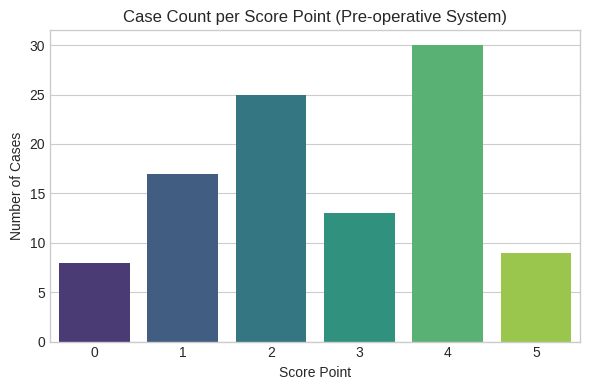

SPK rate plot saved to /content/scoring_system_evaluation_results_v4/Rateplot_Final_Pre-operative_Score.png


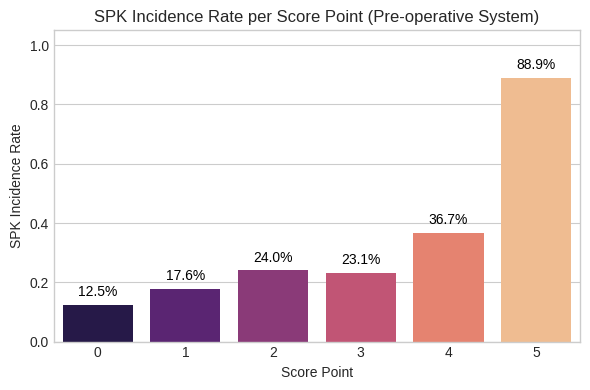


--- Summary (Logistic Regression on Final Pre-operative Score - Using Stored Model) ---
                           Logit Regression Results                           
Dep. Variable:               SPK post   No. Observations:                  102
Model:                          Logit   Df Residuals:                      100
Method:                           MLE   Df Model:                            1
Date:                Mon, 12 May 2025   Pseudo R-squ.:                 0.09356
Time:                        15:50:29   Log-Likelihood:                -57.513
converged:                       True   LL-Null:                       -63.449
Covariance Type:            nonrobust   LLR p-value:                 0.0005697
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.3492      0.572     -4.110      0.000      -3.469      -1.229
Final Score     0.5455      0.171      

CI 2.5%  CI 97.5%  Odds Ratio
const               0.031     0.293       0.095
temp_total_score    1.235     2.411       1.725

ROC curve saved to /content/scoring_system_evaluation_results_v4/ROC_Final_Pre-operative_Score.png


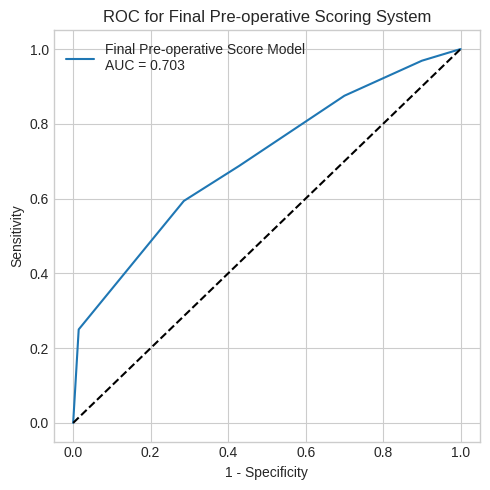


Rules for the Best Pre-operative Scoring System:
  - MRD-1 pre: Add 2 point(s) if MRD-1 pre <= 0.5 mm.
  - ΔMRD-1: Add 1 point(s) if ΔMRD-1 >= 2.0 mm.
  - levator_function pre: Add 1 point(s) if Levator Function < 8.0 mm.
  - BUT pre: Add 1 point(s) if BUT pre < 5.0 sec.

--- Best Post-operative Scoring System ---
Selected Score Factors (4): ΔMRD-1, levator_function pre, BUT pre, BUT post
Mean 5-Fold CV AUC: 0.7514 (+/- 0.0887)
Original Training AUC of Score Model: 0.7625

--- Score Distribution and SPK Incidence for Best Post-operative Scoring System ---


final_score  Total_Cases  SPK_Positive_Cases  SPK_Rate  SPK_Rate_Percent
0            0            8                   0  0.000000               0.0
1            1           20                   2  0.100000              10.0
2            2           44                  12  0.272727              27.3
3            3           27                  15  0.555556              55.6
4            4            3                   3  1.000000             100.0

Score count plot saved to /content/scoring_system_evaluation_results_v4/Countplot_Final_Post-operative_Score.png


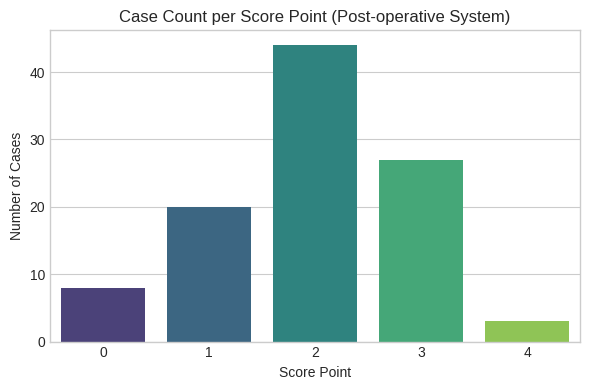

SPK rate plot saved to /content/scoring_system_evaluation_results_v4/Rateplot_Final_Post-operative_Score.png


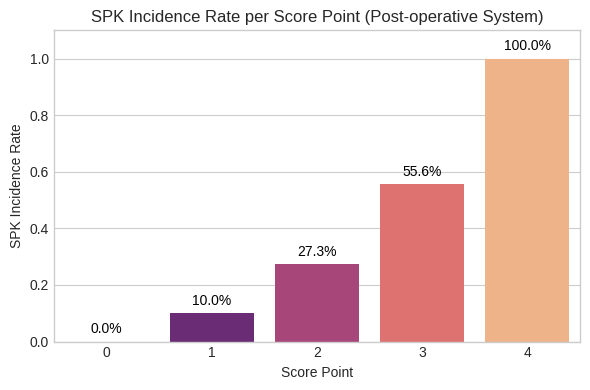


--- Summary (Logistic Regression on Final Post-operative Score - Using Stored Model) ---
                           Logit Regression Results                           
Dep. Variable:               SPK post   No. Observations:                  102
Model:                          Logit   Df Residuals:                      100
Method:                           MLE   Df Model:                            1
Date:                Mon, 12 May 2025   Pseudo R-squ.:                  0.1867
Time:                        15:50:31   Log-Likelihood:                -51.601
converged:                       True   LL-Null:                       -63.449
Covariance Type:            nonrobust   LLR p-value:                 1.128e-06
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -3.7775      0.826     -4.571      0.000      -5.397      -2.158
Final Score     1.3799      0.341     

CI 2.5%  CI 97.5%  Odds Ratio
const               0.005     0.116       0.023
temp_total_score    2.035     7.761       3.975

ROC curve saved to /content/scoring_system_evaluation_results_v4/ROC_Final_Post-operative_Score.png


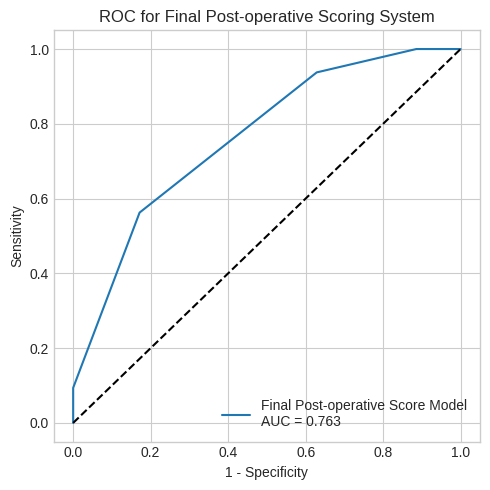


Rules for the Best Post-operative Scoring System:
  - ΔMRD-1: Add 1 point(s) if ΔMRD-1 >= 2.0 mm.
  - levator_function pre: Add 1 point(s) if Levator Function < 8.0 mm.
  - BUT pre: Add 1 point(s) if BUT pre < 5.0 sec.
  - BUT post: Add 1 point(s) if BUT post < 4.0 sec.

Reminder: The selected scoring system's performance is based on the predefined rules.
Further refinement of cutoffs or points might yield different results.

Analysis Complete. Check '/content/scoring_system_evaluation_results_v4' for ROC curves and score plots.


In [ ]:
# =============================================================
# 眼瞼下垂術後SPKリスク解析：ForestPlotベースのスコアリングシステム構築と評価 Ver.4 (通し修正版)
# =============================================================

# -------------------------------------------------------------
# 0. ライブラリのインポートと基本設定
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from tqdm.auto import tqdm
import joblib

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.sm_exceptions import PerfectSeparationError, ConvergenceWarning

from sklearn.metrics import roc_auc_score, roc_curve, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from IPython.display import display
import warnings
import os
import time

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', message="Maximum Likelihood optimization failed to converge")
warnings.filterwarnings('ignore', message="Method 'first' requires numeric dtype to function correctly") # 追加

print("Libraries imported and warnings configured.")

# -------------------------------------------------------------
# 1. Google Drive マウント と ファイル/フォルダ設定
# -------------------------------------------------------------
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    # ★★★ Google Drive内のExcelファイルのパスを指定してください ★★★
    file_path = "/content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ_kit.xlsx"
    # ★★★ 結果を出力するフォルダを指定してください ★★★
    output_dir = "/content/scoring_system_evaluation_results_v4" # 新しいフォルダ名
    print("Google Drive mounted.")
except ModuleNotFoundError:
    print("Running in a non-Colab environment.")
    # ★★★ ローカルのExcelファイルのパスを指定してください ★★★
    file_path = "眼瞼下垂★ドライアイ_kit.xlsx" # 例
    # ★★★ 結果を出力するフォルダを指定してください ★★★
    output_dir = "./scoring_system_evaluation_results_v4"

os.makedirs(output_dir, exist_ok=True)
print(f"Output directory: {output_dir}")

# -------------------------------------------------------------
# 2. データ読み込みと前処理
# -------------------------------------------------------------
print("\n--- 2. Loading and Preprocessing Data ---")
try:
    df_all = pd.read_excel(file_path, sheet_name="対象症例sides", header=0)
    print(f"Excel file loaded successfully. Original shape: {df_all.shape}")
except FileNotFoundError: print(f"Error: File not found at {file_path}"); exit()
except Exception as e: print(f"Error loading Excel file: {e}"); exit()

cols_to_convert = ["MRD-1 pre", "MRD-1 3M", "MRD-2 pre", "MRD-2 3M", "levator_function pre", "BUT pre", "BUT post", "SPK pre", "SPK post"]
for col in cols_to_convert:
    if col in df_all.columns: df_all[col] = pd.to_numeric(df_all[col], errors='coerce')
    else: print(f"Warning: Column '{col}' not found.")
if "MRD-1 3M" in df_all.columns and "MRD-1 pre" in df_all.columns: df_all["ΔMRD-1"] = df_all["MRD-1 3M"] - df_all["MRD-1 pre"]
else: df_all["ΔMRD-1"] = np.nan
if "MRD-2 3M" in df_all.columns and "MRD-2 pre" in df_all.columns: df_all["ΔMRD-2"] = df_all["MRD-2 3M"] - df_all["MRD-2 pre"]
else: df_all["ΔMRD-2"] = np.nan
if "SPK pre" not in df_all.columns: print("Error: 'SPK pre' column not found."); exit()
df = df_all[df_all["SPK pre"] == 0].copy()
if "SPK post" not in df.columns: print("Error: 'SPK post' column not found."); exit()
df_analysis = df[df['SPK post'].isin([0, 1])].copy()
df_analysis['SPK post'] = df_analysis['SPK post'].astype(int)
target_col = 'SPK post'
print(f"Analysis data shape (SPK pre=0, SPK post=0 or 1): {df_analysis.shape}")
if df_analysis.empty or df_analysis[target_col].nunique() < 2: print("Error: Insufficient data for analysis."); exit()
print(f"Target variable '{target_col}' distribution:\n{df_analysis[target_col].value_counts()}")


# -------------------------------------------------------------
# 3. スコアリングルールと候補変数の定義
# -------------------------------------------------------------
print("\n--- 3. Defining Scoring Rules and Candidate Factors ---")
scoring_rules = {
    "MRD-1 pre":            {"condition": lambda x: pd.notna(x) and x <= 0.5, "points": 2, "description": "MRD-1 pre <= 0.5 mm"},
    "ΔMRD-1":               {"condition": lambda x: pd.notna(x) and x >= 2.0, "points": 1, "description": "ΔMRD-1 >= 2.0 mm"},
    "levator_function pre": {"condition": lambda x: pd.notna(x) and x < 8.0,  "points": 1, "description": "Levator Function < 8.0 mm"},
    "BUT pre":              {"condition": lambda x: pd.notna(x) and x < 5.0,  "points": 1, "description": "BUT pre < 5.0 sec"},
    "BUT post":             {"condition": lambda x: pd.notna(x) and x < 4.0,  "points": 1, "description": "BUT post < 4.0 sec"}
}
print("Scoring rules defined:")
for factor, rule in scoring_rules.items():
    print(f"  - {factor}: Add {rule['points']} point(s) if {rule['description']}")

preop_score_candidate_cols = ["MRD-1 pre", "ΔMRD-1", "levator_function pre", "BUT pre"]
preop_score_candidate_cols_valid = [col for col in preop_score_candidate_cols if col in df_analysis.columns and col in scoring_rules]
print(f"\nValid Pre-operative score candidate factors: {preop_score_candidate_cols_valid}")

postop_score_candidate_cols = ["MRD-1 pre", "ΔMRD-1", "levator_function pre", "BUT pre", "BUT post"]
postop_score_candidate_cols_valid = [col for col in postop_score_candidate_cols if col in df_analysis.columns and col in scoring_rules]
print(f"Valid Post-operative score candidate factors: {postop_score_candidate_cols_valid}")


# -------------------------------------------------------------
# 4. スコアリングシステム評価関数
# -------------------------------------------------------------
def evaluate_scoring_systems(df_input, target_variable, candidate_factors_list, rules_dict, desc_str=""):
    score_system_results_list = []
    print(f"\nEvaluating scoring systems for {desc_str} with candidates: {candidate_factors_list}")

    for k in tqdm(range(1, len(candidate_factors_list) + 1), desc=f"Scoring Systems ({desc_str})"):
        for current_factor_subset_tuple in combinations(candidate_factors_list, k):
            current_factors_in_subset = list(current_factor_subset_tuple)

            def calculate_total_score_for_row(row_data, selected_vars, defined_rules):
                total_score_val = 0
                for var_name_in_subset in selected_vars:
                    if var_name_in_subset in defined_rules and var_name_in_subset in row_data:
                        if defined_rules[var_name_in_subset]["condition"](row_data[var_name_in_subset]):
                            total_score_val += defined_rules[var_name_in_subset]["points"]
                return total_score_val

            temp_df_with_score = df_input.copy()
            score_col_name = f"temp_total_score" # ループ内で一時的に使う列名
            temp_df_with_score[score_col_name] = temp_df_with_score.apply(
                lambda r: calculate_total_score_for_row(r, current_factors_in_subset, defined_rules=rules_dict), axis=1
            )
            df_model_eval_current = temp_df_with_score[[target_variable, score_col_name]].dropna()

            if df_model_eval_current.shape[0] < 10 or df_model_eval_current[target_variable].nunique() < 2 or df_model_eval_current[score_col_name].nunique() < 2:
                score_system_results_list.append({'score_factors': ', '.join(current_factors_in_subset), 'num_score_factors': len(current_factors_in_subset), 'training_auc_of_score_model': np.nan, 'model_object':None, 'error': 'Insufficient data'})
                continue

            y_eval_current = df_model_eval_current[target_variable]
            X_eval_score_current = sm.add_constant(df_model_eval_current[[score_col_name]])
            auc_val_current = np.nan; error_msg_current = None; model_fit_current = None
            try:
                score_logit_model = sm.Logit(y_eval_current, X_eval_score_current)
                model_fit_current = score_logit_model.fit(disp=False, maxiter=100, warn_convergence=False) # warn_convergence追加
                if model_fit_current.mle_retvals['converged']:
                    y_pred_prob_score = model_fit_current.predict(X_eval_score_current)
                    auc_val_current = roc_auc_score(y_eval_current, y_pred_prob_score)
                else: error_msg_current = "Convergence Failed"
            except Exception as e_current: error_msg_current = str(e_current)
            score_system_results_list.append({'score_factors': ', '.join(current_factors_in_subset), 'num_score_factors': len(current_factors_in_subset), 'training_auc_of_score_model': auc_val_current, 'model_object': model_fit_current, 'error': error_msg_current})

    results_df_current = pd.DataFrame(score_system_results_list).sort_values(by='training_auc_of_score_model', ascending=False, na_position='last').reset_index(drop=True)
    return results_df_current


# -------------------------------------------------------------
# 5. メイン処理: スコアリングシステムの構築とCV評価
# -------------------------------------------------------------
print("\n--- 5. Main Processing: Scoring System Construction and CV Evaluation ---")
N_SPLITS_CV = 5
TOP_N_SCORING_SYSTEMS = 10
cv_pipeline_score = Pipeline([('scaler', StandardScaler()), ('logistic', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))])
cv_splitter_score = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=42)

# --- 5a. 術前スコアリングシステム ---
print("\n======================================================")
print("=== Pre-operative Scoring System Evaluation ===")
print("======================================================")
best_preop_scoring_system_info = None
preop_scoring_results_df = pd.DataFrame()
if preop_score_candidate_cols_valid:
    preop_scoring_results_df = evaluate_scoring_systems(df_analysis, target_col, preop_score_candidate_cols_valid, scoring_rules, desc_str="PreOp")
    print(f"\n--- Top Scoring Systems by Training AUC (Pre-operative) ---")
    display(preop_scoring_results_df[['score_factors', 'num_score_factors', 'training_auc_of_score_model', 'error']].head(TOP_N_SCORING_SYSTEMS).round(4))
    top_n_preop_scores = preop_scoring_results_df[preop_scoring_results_df['error'].isna() & preop_scoring_results_df['training_auc_of_score_model'].notna()].head(TOP_N_SCORING_SYSTEMS)
    cv_eval_results_preop = []
    if not top_n_preop_scores.empty:
        print(f"\n--- Performing {N_SPLITS_CV}-Fold CV on Top {len(top_n_preop_scores)} Pre-operative Scoring Systems ---")
        for index, row_data in tqdm(top_n_preop_scores.iterrows(), total=len(top_n_preop_scores), desc="CV on PreOp Scores"):
            current_factors_list = row_data['score_factors'].split(', ')
            temp_df_cv = df_analysis.copy()
            temp_df_cv['current_total_score'] = temp_df_cv.apply(lambda r_cv: sum(scoring_rules[f_cv]['points'] for f_cv in current_factors_list if f_cv in scoring_rules and f_cv in r_cv and scoring_rules[f_cv]['condition'](r_cv[f_cv])), axis=1)
            df_cv_eval_current = temp_df_cv[[target_col, 'current_total_score']].dropna()
            y_cv_current = df_cv_eval_current[target_col]; X_cv_score_current = df_cv_eval_current[['current_total_score']]
            mean_auc_current = np.nan; std_auc_current = np.nan
            if X_cv_score_current.shape[0] >= N_SPLITS_CV and y_cv_current.nunique() == 2 and X_cv_score_current['current_total_score'].nunique() >=2 :
                try:
                    cv_scores_current = cross_val_score(cv_pipeline_score, X_cv_score_current, y_cv_current, cv=cv_splitter_score, scoring='roc_auc', n_jobs=-1)
                    if np.all(np.isfinite(cv_scores_current)): mean_auc_current = cv_scores_current.mean(); std_auc_current = cv_scores_current.std()
                except Exception as e_cv: print(f"CV Error for pre-op score ({row_data['score_factors']}): {e_cv}")
            cv_eval_results_preop.append({'original_index': index, 'score_factors': row_data['score_factors'], 'num_score_factors': row_data['num_score_factors'], 'training_auc': row_data['training_auc_of_score_model'], 'mean_cv_auc': mean_auc_current, 'std_cv_auc': std_auc_current})
        if cv_eval_results_preop:
            cv_eval_results_preop_df = pd.DataFrame(cv_eval_results_preop).sort_values(by='mean_cv_auc', ascending=False, na_position='last')
            print(f"\n--- Top Pre-operative Scoring Systems Ranked by Mean CV AUC ---")
            display(cv_eval_results_preop_df.head(10).round(4))
            if not cv_eval_results_preop_df.empty and cv_eval_results_preop_df['mean_cv_auc'].notna().any():
                 best_preop_scoring_system_info = cv_eval_results_preop_df.iloc[0].to_dict()
    else: print("No valid pre-operative scoring systems found for CV.")
else: print("No valid candidate factors for pre-operative scoring system.")

# --- 5b. 術後スコアリングシステム ---
print("\n\n======================================================")
print("=== Post-operative Scoring System Evaluation ===")
print("======================================================")
best_postop_scoring_system_info = None
postop_scoring_results_df = pd.DataFrame()
if postop_score_candidate_cols_valid:
    postop_scoring_results_df = evaluate_scoring_systems(df_analysis, target_col, postop_score_candidate_cols_valid, scoring_rules, desc_str="PostOp")
    print(f"\n--- Top Scoring Systems by Training AUC (Post-operative) ---")
    display(postop_scoring_results_df[['score_factors', 'num_score_factors', 'training_auc_of_score_model', 'error']].head(TOP_N_SCORING_SYSTEMS).round(4))
    top_n_postop_scores = postop_scoring_results_df[postop_scoring_results_df['error'].isna() & postop_scoring_results_df['training_auc_of_score_model'].notna()].head(TOP_N_SCORING_SYSTEMS)
    cv_eval_results_postop = []
    if not top_n_postop_scores.empty:
        print(f"\n--- Performing {N_SPLITS_CV}-Fold CV on Top {len(top_n_postop_scores)} Post-operative Scoring Systems ---")
        for index, row_data in tqdm(top_n_postop_scores.iterrows(), total=len(top_n_postop_scores), desc="CV on PostOp Scores"):
            current_factors_list = row_data['score_factors'].split(', ')
            temp_df_cv = df_analysis.copy()
            temp_df_cv['current_total_score'] = temp_df_cv.apply(lambda r_cv: sum(scoring_rules[f_cv]['points'] for f_cv in current_factors_list if f_cv in scoring_rules and f_cv in r_cv and scoring_rules[f_cv]['condition'](r_cv[f_cv])), axis=1)
            df_cv_eval_current = temp_df_cv[[target_col, 'current_total_score']].dropna()
            y_cv_current = df_cv_eval_current[target_col]; X_cv_score_current = df_cv_eval_current[['current_total_score']]
            mean_auc_current = np.nan; std_auc_current = np.nan
            if X_cv_score_current.shape[0] >= N_SPLITS_CV and y_cv_current.nunique() == 2 and X_cv_score_current['current_total_score'].nunique() >=2 :
                try:
                    cv_scores_current = cross_val_score(cv_pipeline_score, X_cv_score_current, y_cv_current, cv=cv_splitter_score, scoring='roc_auc', n_jobs=-1)
                    if np.all(np.isfinite(cv_scores_current)): mean_auc_current = cv_scores_current.mean(); std_auc_current = cv_scores_current.std()
                except Exception as e_cv: print(f"CV Error for post-op score ({row_data['score_factors']}): {e_cv}")
            cv_eval_results_postop.append({'original_index': index, 'score_factors': row_data['score_factors'], 'num_score_factors': row_data['num_score_factors'], 'training_auc': row_data['training_auc_of_score_model'], 'mean_cv_auc': mean_auc_current, 'std_cv_auc': std_auc_current})
        if cv_eval_results_postop:
            cv_eval_results_postop_df = pd.DataFrame(cv_eval_results_postop).sort_values(by='mean_cv_auc', ascending=False, na_position='last')
            print(f"\n--- Top Post-operative Scoring Systems Ranked by Mean CV AUC ---")
            display(cv_eval_results_postop_df.head(10).round(4))
            if not cv_eval_results_postop_df.empty and cv_eval_results_postop_df['mean_cv_auc'].notna().any():
                best_postop_scoring_system_info = cv_eval_results_postop_df.iloc[0].to_dict()
    else: print("No valid post-operative scoring systems found for CV.")
else: print("No valid candidate factors for post-operative scoring system.")


# -------------------------------------------------------------
# 6. 最終結果サマリーと詳細評価
# -------------------------------------------------------------
print("\n\n======================================================")
print(f"=== Final Scoring System Summary (Selected by Best Mean {N_SPLITS_CV}-Fold CV AUC) ===")
print("======================================================")

def display_final_scoring_system_details(system_info, original_results_df_for_model_obj, df_analysis_data, target_col_name, rules_dict_local, desc_str=""):
    if system_info is None:
        print(f"\nNo best {desc_str} scoring system selected.")
        return

    print(f"\n--- Best {desc_str} Scoring System ---")
    selected_score_factors_list = system_info['score_factors'].split(', ')
    print(f"Selected Score Factors ({system_info['num_score_factors']}): {', '.join(selected_score_factors_list)}")
    print(f"Mean {N_SPLITS_CV}-Fold CV AUC: {system_info['mean_cv_auc']:.4f} (+/- {system_info['std_cv_auc']:.4f})")
    print(f"Original Training AUC of Score Model: {system_info['training_auc']:.4f}")

    # Retrieve the original fitted model object if needed for summary, or refit
    final_score_model_for_summary = None
    if 'original_index' in system_info and original_results_df_for_model_obj is not None and not original_results_df_for_model_obj.empty:
        try:
            original_model_idx = system_info['original_index']
            final_score_model_for_summary = original_results_df_for_model_obj.loc[original_model_idx, 'model_object']
        except KeyError:
            print("Warning: Could not retrieve original model object from results.")


    final_df_display = df_analysis_data.copy()
    final_df_display['final_score'] = final_df_display.apply(
        lambda r_disp: sum(rules_dict_local[f_disp]['points'] for f_disp in selected_score_factors_list if f_disp in rules_dict_local and f_disp in r_disp and rules_dict_local[f_disp]['condition'](r_disp[f_disp])), axis=1
    )
    df_final_model_eval_disp = final_df_display[[target_col_name, 'final_score']].dropna()

    if not df_final_model_eval_disp.empty and df_final_model_eval_disp['final_score'].nunique() > 0:
        print(f"\n--- Score Distribution and SPK Incidence for Best {desc_str} Scoring System ---")
        score_summary_disp = df_final_model_eval_disp.groupby('final_score')[target_col_name].agg(
            Total_Cases='count', SPK_Positive_Cases='sum', SPK_Rate='mean'
        ).reset_index()
        score_summary_disp['SPK_Rate_Percent'] = (score_summary_disp['SPK_Rate'] * 100).round(1)
        display(score_summary_disp)

        plt.figure(figsize=(max(6, score_summary_disp['final_score'].nunique() * 0.8), 4))
        sns.countplot(x='final_score', data=df_final_model_eval_disp, palette="viridis", order = sorted(df_final_model_eval_disp['final_score'].unique()))
        plt.title(f"Case Count per Score Point ({desc_str} System)"); plt.xlabel("Score Point"); plt.ylabel("Number of Cases"); plt.tight_layout()
        count_fig_path_disp = os.path.join(output_dir, f"Countplot_Final_{desc_str.replace(' ','_')}_Score.png")
        plt.savefig(count_fig_path_disp, dpi=300); print(f"Score count plot saved to {count_fig_path_disp}"); plt.show()

        if not score_summary_disp.empty:
            plt.figure(figsize=(max(6, score_summary_disp['final_score'].nunique() * 0.8), 4))
            barplot = sns.barplot(x='final_score', y='SPK_Rate', data=score_summary_disp, palette="magma", order = sorted(score_summary_disp['final_score'].unique()))
            plt.title(f"SPK Incidence Rate per Score Point ({desc_str} System)"); plt.xlabel("Score Point"); plt.ylabel("SPK Incidence Rate")
            plt.ylim(0, max(1.05, score_summary_disp['SPK_Rate'].max() * 1.1 if not score_summary_disp['SPK_Rate'].empty else 1.05))
            for i_disp, patch_disp in enumerate(barplot.patches):
                 try:
                     current_score_val_disp = sorted(score_summary_disp['final_score'].unique())[i_disp]
                     rate_percent_disp = score_summary_disp[score_summary_disp['final_score'] == current_score_val_disp]['SPK_Rate_Percent'].iloc[0]
                     bar_x_pos_disp = patch_disp.get_x() + patch_disp.get_width() / 2
                     barplot.text(bar_x_pos_disp, patch_disp.get_height() + 0.02, f"{rate_percent_disp:.1f}%", color='black', ha="center", va="bottom")
                 except (IndexError, KeyError): print(f"Warning: Could not annotate bar for score (index {i_disp}).")
            plt.tight_layout(); rate_fig_path_disp = os.path.join(output_dir, f"Rateplot_Final_{desc_str.replace(' ','_')}_Score.png")
            plt.savefig(rate_fig_path_disp, dpi=300); print(f"SPK rate plot saved to {rate_fig_path_disp}"); plt.show()
        else: print("Could not generate SPK rate summary for the plot.")
    else: print(f"Not enough data or score variation to display score distribution for {desc_str} system.")

    if df_final_model_eval_disp.shape[0] > 10 and df_final_model_eval_disp[target_col_name].nunique() == 2 and df_final_model_eval_disp['final_score'].nunique() >=2 :
        y_final_disp = df_final_model_eval_disp[target_col_name]; X_final_score_disp = sm.add_constant(df_final_model_eval_disp[['final_score']])
        try:
            if final_score_model_for_summary and final_score_model_for_summary.mle_retvals['converged']:
                print(f"\n--- Summary (Logistic Regression on Final {desc_str} Score - Using Stored Model) ---")
                final_model_to_show = final_score_model_for_summary
            else: # Refit if stored model is not good or not available
                print(f"\n--- Summary (Logistic Regression on Final {desc_str} Score - Refitting Model) ---")
                final_model_to_show = sm.Logit(y_final_disp, X_final_score_disp).fit(disp=False)

            print(final_model_to_show.summary(xname=['Intercept', 'Final Score']))
            print("\nOdds Ratios (per 1 point increase in score):")
            conf_final_disp = final_model_to_show.conf_int(); conf_final_disp['Odds Ratio'] = final_model_to_show.params
            conf_final_disp.columns = ['CI 2.5%', 'CI 97.5%', 'Odds Ratio']; display(np.exp(conf_final_disp).round(3))
            y_prob_final_disp = final_model_to_show.predict(X_final_score_disp); fpr_disp, tpr_disp, _ = roc_curve(y_final_disp, y_prob_final_disp)
            auc_val_disp = roc_auc_score(y_final_disp, y_prob_final_disp); plt.figure(figsize=(5,5))
            plt.plot(fpr_disp, tpr_disp, label=f"Final {desc_str} Score Model\nAUC = {auc_val_disp:.3f}"); plt.plot([0,1],[0,1],'k--')
            plt.xlabel("1 - Specificity"); plt.ylabel("Sensitivity"); plt.title(f"ROC for Final {desc_str} Scoring System")
            plt.legend(); plt.grid(True); plt.tight_layout()
            roc_fig_path_disp = os.path.join(output_dir, f"ROC_Final_{desc_str.replace(' ','_')}_Score.png")
            plt.savefig(roc_fig_path_disp, dpi=300); print(f"ROC curve saved to {roc_fig_path_disp}"); plt.show()
        except Exception as e_final_disp: print(f"Error displaying final {desc_str} score model summary/ROC: {e_final_disp}")
    else: print(f"Not enough data to display final {desc_str} score model summary/ROC.")

    print(f"\nRules for the Best {desc_str} Scoring System:")
    for factor_name_disp in selected_score_factors_list:
        if factor_name_disp in rules_dict_local and 'description' in rules_dict_local[factor_name_disp]:
            print(f"  - {factor_name_disp}: Add {rules_dict_local[factor_name_disp]['points']} point(s) if {rules_dict_local[factor_name_disp]['description']}.")
        elif factor_name_disp in rules_dict_local: print(f"  - {factor_name_disp}: Add {rules_dict_local[factor_name_disp]['points']} point(s) if condition met.")

display_final_scoring_system_details(best_preop_scoring_system_info, preop_scoring_results_df, df_analysis, target_col, scoring_rules, desc_str="Pre-operative")
display_final_scoring_system_details(best_postop_scoring_system_info, postop_scoring_results_df, df_analysis, target_col, scoring_rules, desc_str="Post-operative")

print("\nReminder: The selected scoring system's performance is based on the predefined rules.")
print("Further refinement of cutoffs or points might yield different results.")
print(f"\nAnalysis Complete. Check '{output_dir}' for ROC curves and score plots.")

# **スコアリングシステム構築重視:** 上記で有望だったスコアリングシステム（ルールセットと因子組み合わせのペア）に対し、交差検証（Cross・評価ストラテジー

## 1. 目的

眼瞼下垂手術後のSPK（点状-Validation, CV）を行い、未知のデータに対する予測性能（平均CV AUC）を推定します。
*表層角膜症）発症リスクを予測するための、臨床的に解釈可能で、かつ予測性能の高い   **モデルの選択:** 最終的に、平均CV AUCが最も高いスコアリングシステムを、術前モデルスコアリングシステムを構築する。
特に、主要なリスク因子のカットオフ値や組み合わせのバリエーションを考慮と術後モデルそれぞれについて選択します。CV AUCが同率首位の場合は、その全てを候補として詳細を表示します。
*   **解釈性の担保:** 選択されたモデルのスコア分布、各スコア点し、データ駆動的に最適なスコアリングルールと因子組み合わせを探索する。

## 2. 基本方針

1.  **ルールベースのスコアリング:** 各リスク因子に対し、条件（カットオフ値）を満たした場合に特定のでのSPK発症率、およびロジスティック回帰によるスコアの重み（オッズ比）を点数を加算する方式。
2.  **ルールセットの網羅的探索:** 主要な因子（`ΔMR評価します。

## 2. 解析ステップ

### ステップ1：データの準備

1.  **データD-1`, `levator_function pre`, `BUT pre`, `BUT post`）について、複数のカット読み込み:** 対象症例のExcelファイルを読み込みます。
2.  **前処理:**
    *   オフ値や段階的スコアリングのバリエーションを定義。これらのバリエーションと、その他の固定ルールを持つ因子（`必要なカラム（`MRD-1 pre`, `MRD-1 3M`, `levator_function preMRD-1 pre`）を組み合わせ、多数の「スコアリングルールセット」を生成する。各因子を`, `BUT pre`, `BUT post`, `SPK pre`, `SPK post`など）を数値型に変換します。
    *   `ΔMRD-1` (`MRD-1 3M`スコアに含めるか含めないかの選択も考慮する。
3.  **因子組み合わせの探索:** 各 - `MRD-1 pre`) などの派生変数を計算します。
    *   解析対象を「生成された「スコアリングルールセット」内で、どの因子の組み合わせが最も予測的なスコアを生み出すかを総術前SPKなし (`SPK pre == 0`)」の症例に限定します。
    *   目的変当たり的に評価する。
4.  **クロスバリデーション (CV) による性能評価:** 学習データに対する数を「術後SPKの有無 (`SPK post`)」とします。

### ステップ2：スコAUCだけでなく、より頑健な性能評価のために、k分割交差検証（例: 5-Fold CVアリングルールのバリエーション生成

1.  **固定ルール因子の定義:**
    *   `MRD-1 pre`: Forest Plot等の結果に基づき、基本的なカットオフ値と点数を設定（例: `MRD-1 pre）による平均CV AUCを重視する。
5.  **最終モデル選択:** 全ての「スコアリングルールセット」 <= 0.5 mm` なら2点）。この因子を含めるか含めないかの選択肢も用意と「因子組み合わせ」を通して、平均CV AUCが最も高いものを最終的なベストスコアリングシステムとして選択する。もし。
2.  **変動ルール因子の定義:**
    *   **`ΔMRD-1`**:CV AUCが同率首位のシステムが複数ある場合は、それら全てを候補として詳細を表示する。

 複数のカットオフ値を試行。
        *   例1: `ΔMRD-1 >= 2.0 mm` なら1点
        *   例2: `ΔMRD-1 >= 2.5 mm## 3. 実装ステップ

### ステップ 3.1: データ準備

*   Excelファイルから元` なら1点
        *   例3: `ΔMRD-1 >= 3.0 mm`データを読み込む。
*   必要なカラムを数値型に変換。
*   `ΔMRD-1` なら1点
        *   例4: 段階的スコア（例: `2.0 <= ΔMRD、`ΔMRD-2` などの派生変数を計算。
*   術前SPK=-1 < 3.0 mm` なら1点、`ΔMRD-1 >= 3.0 mm` なら0の症例のみを抽出し、目的変数（`SPK post`）が0か1のデータで2点）
        *   この因子を含めない選択肢も用意。
    *   **`levator_function pre`**: 複数のカットオフ値を試行。
        *   例1: `Levator <解析用データフレーム (`df_analysis`) を作成。

### ステップ 3.2: スコアリングルールセット 7.0 mm` なら1点
        *   例2: `Levator < 8.0の生成 (`generate_flexible_scoring_rule_sets`)

1.  **固定ルールの定義:**  mm` なら1点
        *   例3: `Levator < 9.0 mm` なら1点
        *   この因子を含めない選択肢も用意。
    *   **`BUT pre`常に同じルールを適用する因子（例: `MRD-1 pre`）のルールを定義。
    *   **: 複数のカットオフ値を試行。
        *   例1: `BUT pre < 4.0例: `MRD-1 pre <= 0.5 mm` なら2点。
2.  **変動s` なら1点
        *   例2: `BUT pre < 5.0s` なら1ルールの定義:** カットオフ値や点数ロジックに複数のバリエーションを持たせる因子（`ΔMRD点
        *   例3: `BUT pre < 6.0s` なら1点
        *   この因子を含めない選択肢も用意。
    *   **`BUT post`** (術後モデル-1`, `levator_function pre`, `BUT pre`, `BUT post`）について、それぞれのバリエーションを用): 複数のカットオフ値を試行。
        *   例1: `BUT post < 3.定義。
    *   各バリエーションには、条件（lambda関数）、点数（固定またはロジック関数0s` なら1点
        *   例2: `BUT post < 4.0s` なら1点
        *   例3: `BUT post < 5.0s` なら1点
        ）、およびルールの説明文字列（description）を含む。
    *   各因子について「スコアに含め*   この因子を含めない選択肢も用意。
3.  **ルールセットの生成:**
    *   上記1と2で定義した各因子のルールバリエーションの**全ての組み合わせ（直積）**ない (`_none`)」という選択肢もバリエーションとして用意。
    *   例 (`ΔMRD-1`):
        *   `ΔMRD-1 >= 2.0 mm` なら1点
        *を生成します。これにより、多数の異なる「スコアリングルールセット」が作成されます。
    *   各ルール   `ΔMRD-1 >= 2.5 mm` なら1点
        *   `ΔMRセットには、少なくとも1つの有効なスコアリング因子が含まれるようにします。

### ステップ3：各ルールD-1 >= 3.0 mm` なら1点
        *   段階的: `ΔMRD-1` が `2.0-2.9mm` なら1点、`>=3.0mm` なら2点セットにおけるスコアリングシステムの評価

各生成された「スコアリングルールセット」に対して、以下の処理を行います。

1
        *   `ΔMRD-1` をスコアに含めない
3.  **ルールセット.  **候補因子の決定:**
    *   **術前スコアリングシステム:** 当該ルールセットに含まれる術前因子（例: `MRD-1 pre`, `ΔMRD-1`, `levator_functionの組み合わせ生成:** 上記1と2で定義した各因子のルールバリエーションの**直積 (product pre`, `BUT pre`）を候補とします。
    *   **術後スコアリングシステム:** 当)** を取ることで、考えられる全ての「スコアリングルールセット」を網羅的に生成する。
    *該ルールセットに含まれる術後因子（例: `MRD-1 pre`, `ΔMRD-1`, `levator_function pre`, `BUT pre`, `BUT post`）を候補とします。
2.  **   各ルールセットには一意の名称を付与する。
    *   全く因子を含まない（因子組み合わせの総当たり評価:**
    *   候補因子の中から、1つ以上の因子を含む全ての組み合わせを生成全てのルールが `_none`）ルールセットは除外する。

### ステップ 3.3: 各します。
    *   各因子の組み合わせについて：
        *   **スコア計算:** 現在の「ルールセット内でのスコアリングシステム評価 (`evaluate_scoring_systems_flexible`)

生成された各「スコアリングルールセット」スコアリングルールセット」と選択された「因子の組み合わせ」に基づき、各症例の合計スコアを計算 (`current_scoring_rules`) について、以下の処理を行う。

1.  **因子候補の特定:** 現在します。
        *   **モデル学習:** 計算された合計スコアを唯一の説明変数とし、目的変数（`のルールセットで定義されている因子を、そのスコアリングシステムの構築に使用する「因子候補」とする。
2.SPK post`）に対するロジスティック回帰モデルを学習します。
        *   **学習AUC  **因子組み合わせの総当たり:** 「因子候補」の中から1つ以上の因子を選ぶ全ての組み合わせを生成する (`評価:** 学習データに対するモデルのAUCを計算します。
        *   VIF (Variance Inflation Factor) もitertools.combinations`)。
3.  **各因子組み合わせの評価:**
    *   **スコア計算:** 現在参考情報として計算・記録します（スコアモデルの場合、変数が1つなのでVIFは通常問題になりの「スコアリングルールセット」と選択された「因子組み合わせ」に基づき、`df_analysis` の各症例ません）。
3.  **ルールセット内でのランキング:**
    *   各ルールセット内で、学習AUCがの合計スコアを計算する。
    *   **モデル学習:** 計算された合計スコアを唯一の説明変数とし、最も高かったスコアリングシステム（因子の組み合わせ）を上位数件（例: Top 3）選択します。

###`SPK post` を目的変数とするロジスティック回帰モデルを学習する (`statsmodels.Log ステップ4：クロスバリデーションによる最終モデル選択

1.  **CV対象の選定:** ステit`)。
    *   **学習AUC評価:** 学習データに対するAUC (Area Under the ROC Curve) を計算ップ3で各ルールセットから選ばれた上位のスコアリングシステム全てを、クロスバリデーションの対象とします。する。
    *   結果（使用因子、因子数、学習AUC、モデルオブジェクトなど）を記録する。

2.  **クロスバリデーション実行:**
    *   対象となる各スコアリングシステム（特定のルール4.  **ルールセット内のベスト(学習AUC基準):** 当該ルールセット内で、学習AUCが最も高セットと、その中での特定の因子組み合わせ）について、K分割交差検証（例: 5-Foldかったスコアリングシステム（因子組み合わせ）を（CV評価のために）いくつか選出する (`TOP_N_SCORING_または10-Fold Stratified CV）を実行します。
    *   各foldにおいて：
        *   SYSTEMS_PER_RULESET` 件）。

### ステップ 3.4: クロスバリデーション学習用データで、現在のルールセットと因子組み合わせに基づいてスコアを計算します。
        *   そのスコアによる性能評価

ステップ 3.3 で各ルールセットから選出された上位のスコアリングシステム（因子を説明変数としてロジスティック回帰モデルを学習します。
        *   テスト用データで同様にスコアを計算し、学習済みモデルで予測を行い、テストAUCを計算します。
    *   K組み合わせと、そのルールセット）に対し、k分割交差検証（k=5）を実行する。

1.  **個のテストAUCの平均値（平均CV AUC）と標準偏差を計算します。
3.  **総合各CV Foldでの処理:**
    *   学習用foldのデータを使って、現在のスコアリングシステム（特定のルールランキングと最終モデル選択:**
    *   全てのルールセット・全ての評価対象スコアリングシステムの結果を、平均CV AUCでセット＋特定の因子組み合わせ）に基づき各症例の合計スコアを計算する。
    *   その降順にソートします。
    *   **術前モデル**と**術後モデル**それぞれについてスコアを説明変数としてロジスティック回帰モデルを学習用foldで学習する（`sklearn.pipeline、平均CV AUCが最も高いスコアリングシステム（ルールセットと因子組み合わせのペア）を最終的なベストモデルとして.Pipeline` と `LogisticRegression` を使用）。
    *   検証用foldのデータに対しても同様にスコアを選択します。
    *   平均CV AUCが同率首位のシステムが複数存在する場合は、その全て計算し、学習済みモデルで予測確率を算出し、AUCを計算する。
2.  **平均CVをベスト候補として詳細を表示します。

### ステップ5：選択されたベストスコアリングシステムの詳細評価

最終 AUCの算出:** 全てのfoldのAUCの平均値と標準偏差を計算する。
3.  **結果の的に選択されたベストな（術前および術後の）スコアリングシステムについて、以下の評価を行います。

1.  **ルール集約:** 各スコアリングシステム（ルールセット名、因子組み合わせ、学習AUC、平均CV AUC、CV AUCセットと構成因子:** 使用されたルールセット名と、スコアを構成する因子を表示します。
2.  **性能標準偏差など）の結果を `all_best_systems_across_rulesets` リストに保存する。

### ステ指標:** 学習AUC、平均CV AUC、CV AUCの標準偏差を表示します。
3.  **スコア分布ップ 3.5: 全体でのベストスコアリングシステムの選択と詳細評価

1.  **総合ランキング:**
    *   全データにベストスコアリングシステムを適用して各症例のスコアを計算します:** `all_best_systems_across_rulesets` を平均CV AUCで降順にソートする（同率の場合は因子数が少ない方を優先）。
2.  **最終モデルの特定:**
    *   「。
    *   各スコア点数（例: 0点、1点、...、最大点）に該当術前モデル」と「術後モデル」を区別（例: `BUT post` を含むかどうか）する症例数を集計し、棒グラフで表示します。
4.  **SPK発症率:**
    *   各スコア点数におけるSPK発症率を計算し、棒グラフで表示します。
して、それぞれで平均CV AUCが最も高い（または同率首位の）スコアリングシステム群を特定5.  **ロジスティック回帰サマリー:**
    *   計算された最終スコアを説明変数とするする。
3.  **詳細評価 (`display_final_system_evaluation`):** 特定された各ベストスコアリングシステムロジスティック回帰モデルを全データで再学習し、そのサマリー（係数、p値、オッズ比など）を表示します。
6.  **ROC曲線:** 上記ロジスティック回について以下を表示/実行。
    *   使用されたルールセット名。
    *   スコアに含まれる因子のリスト。
    *   平均CV AUC とその標準偏差。
    *   元の学習AUC。帰モデルのROC曲線とAUCを表示します。
7.  **スコアリングルールの明示:** 最終
    *   **具体的なスコアリングルール:** 各因子がどの条件で何点加算されるかを、人間的に選択されたスコアリングシステムを構成する各因子の具体的な条件（カットオフ値）と点数を分かりやすく表示します。が読める形式で表示。
    *   **スコア分布とSPK発症率:**
        *   最終

## 4. 期待される成果と留意点

*   **期待される成果:**
    *   複数のカットオフスコアを全データで計算し、各スコア点数の症例数と、その点数におけるSPK値やルールのバリエーションを考慮した上で、最も汎化性能が高いと期待されるスコアリングシステムが発症率を集計して表示。
        *   症例数の棒グラフとSPK発症率の棒グラフを生成・表示。
    *   **最終モデルのロジスティック回帰サマリー:** 最終スコアを特定できます。
    *   選択されたスコアリングシステムの臨床的な有用性を評価するための詳細な情報（スコア分布、発説明変数としたロジスティック回帰モデルを全データで再フィットし、そのサマリー（係数、p症率、オッズ比など）が得られます。
*   **留意点:**
    *   **計算値、オッズ比）を表示。
    *   **最終モデルのROC曲線:** 上記モデルのROC曲線と時間:** ルールセットのバリエーション数と、各ルールセット内での因子組み合わせの数によっては、全体のAUCを表示。
    *   **共線性チェック (参考情報):** 最終スコアに含まれる因子間の計算時間が非常に長くなる可能性があります。適切な範囲でバリエーションを絞ることが重要です。
    *   **過学習のリスク:** 多数のモデルを評価するため、偶然学習データに適合するモデルが見つかるリスクがあります。クロスバリデ共線性（相関行列、VIF）を表示 (スコアリングシステムでは因子を直接モデルに入れるわけではないためーションはそのリスクを低減しますが、独立した検証データセットでの評価が理想的です。
    *   、解釈の参考として)。

## 4. 出力

*   コンソールへの進捗状況、各**解釈性と臨床的妥当性:** 最終的に選択されたスコアリングシステムが、統計的に優れているステップの結果、最終的なベストスコアリングシステムの詳細。
*   指定ディレクトリへのグラフ画像ファイル（相関行列ヒだけでなく、臨床的に解釈可能で、かつ妥当であるかを確認する必要があります。
    *   **ルールの事前ートマップ、スコア分布グラフ、SPK発症率グラフ、ROC曲線）の保存。

## 5.定義の限界:** 本アプローチでは、因子のカットオフ値や点数の「候補」は事前に与える 注意点と限界

*   **計算時間:** ルールセットのバリエーションと因子組み合わせの数が多いため、計算必要があります。これらの候補自体の最適化は行っていません。

この戦略により、よりデータに基づいた客観的な評価に長時間を要する可能性がある。
*   **過学習リスク:** 学習データに対するAUCを中間指標として使用を伴うスコアリングシステムの構築を目指します。

Libraries imported.
Mounted at /content/drive
Google Drive mounted.
Output directory: /content/super_flexible_scoring_eval_v2

--- 2. Loading and Preprocessing Data ---
Excel file loaded. Shape: (172, 32)
Analysis data shape: (102, 32), Target distribution:
SPK post
0    0.686
1    0.314
Name: proportion, dtype: float64

--- 3. Generating Flexible Scoring Rule Sets ---
Generated 144 flexible scoring rule sets to evaluate.

--- 5. Main Processing: Evaluating Flexible Rule Sets and Final Selection ---


Processing Rule Sets:   0%|          | 0/144 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS1_mrd1pre_le0):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS1_mrd1pre_le0):   0%|          | 0/5 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS2_mrd1pre_le0):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS2_mrd1pre_le0):   0%|          | 0/5 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS3_mrd1pre_le0):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS3_mrd1pre_le0):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS4_mrd1pre_le0):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS4_mrd1pre_le0):   0%|          | 0/5 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS5_mrd1pre_le0):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS5_mrd1pre_le0):   0%|          | 0/5 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS6_mrd1pre_le0):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS6_mrd1pre_le0):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS7_mrd1pre_le0):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS7_mrd1pre_le0):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS8_mrd1pre_le0):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS8_mrd1pre_le0):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS9_mrd1pre_le0):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS9_mrd1pre_le0):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS10_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS10_mrd1pre_le):   0%|          | 0/5 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS11_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS11_mrd1pre_le):   0%|          | 0/5 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS12_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS12_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS13_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS13_mrd1pre_le):   0%|          | 0/5 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS14_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS14_mrd1pre_le):   0%|          | 0/5 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS15_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS15_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS16_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS16_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS17_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS17_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS18_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS18_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS19_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS19_mrd1pre_le):   0%|          | 0/5 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS20_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS20_mrd1pre_le):   0%|          | 0/5 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS21_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS21_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS22_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS22_mrd1pre_le):   0%|          | 0/5 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS23_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS23_mrd1pre_le):   0%|          | 0/5 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS24_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS24_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS25_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS25_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS26_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS26_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS27_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS27_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS28_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS28_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS29_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS29_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS30_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS30_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS31_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS31_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS32_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS32_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS33_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS33_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS34_mrd1pre_le):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS34_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS35_mrd1pre_le):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS35_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS36_mrd1pre_le):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS36_mrd1pre_le):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS37_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS37_mrd1pre_le):   0%|          | 0/5 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS38_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS38_mrd1pre_le):   0%|          | 0/5 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS39_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS39_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS40_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS40_mrd1pre_le):   0%|          | 0/5 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS41_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS41_mrd1pre_le):   0%|          | 0/5 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS42_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS42_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS43_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS43_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS44_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS44_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS45_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS45_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS46_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS46_mrd1pre_le):   0%|          | 0/5 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS47_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS47_mrd1pre_le):   0%|          | 0/5 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS48_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS48_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS49_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS49_mrd1pre_le):   0%|          | 0/5 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS50_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS50_mrd1pre_le):   0%|          | 0/5 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS51_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS51_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS52_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS52_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS53_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS53_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS54_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS54_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS55_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS55_mrd1pre_le):   0%|          | 0/5 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS56_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS56_mrd1pre_le):   0%|          | 0/5 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS57_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS57_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS58_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS58_mrd1pre_le):   0%|          | 0/5 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS59_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS59_mrd1pre_le):   0%|          | 0/5 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS60_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS60_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS61_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS61_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS62_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS62_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS63_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS63_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS64_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS64_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS65_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS65_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS66_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS66_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS67_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS67_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS68_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS68_mrd1pre_le):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS69_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS69_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS70_mrd1pre_le):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS70_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS71_mrd1pre_le):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS71_mrd1pre_le):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS72_mrd1pre_le):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS72_mrd1pre_le):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS73_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS73_dmrd1_ge2.):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS74_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS74_dmrd1_ge2.):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS75_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS75_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS76_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS76_dmrd1_ge2.):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS77_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS77_dmrd1_ge2.):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS78_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS78_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS79_dmrd1_ge2.):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS79_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS80_dmrd1_ge2.):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS80_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS81_dmrd1_ge2.):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS81_dmrd1_ge2.):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS82_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS82_dmrd1_ge2.):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS83_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS83_dmrd1_ge2.):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS84_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS84_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS85_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS85_dmrd1_ge2.):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS86_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS86_dmrd1_ge2.):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS87_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS87_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS88_dmrd1_ge2.):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS88_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS89_dmrd1_ge2.):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS89_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS90_dmrd1_ge2.):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS90_dmrd1_ge2.):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS91_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS91_dmrd1_ge2.):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS92_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS92_dmrd1_ge2.):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS93_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS93_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS94_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS94_dmrd1_ge2.):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS95_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS95_dmrd1_ge2.):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS96_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS96_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS97_dmrd1_ge2.):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS97_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS98_dmrd1_ge2.):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS98_dmrd1_ge2.):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS99_dmrd1_ge2.):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS99_dmrd1_ge2.):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS100_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS100_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS101_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS101_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS102_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS102_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS103_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS103_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS104_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS104_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS105_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS105_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS106_dmrd1_ge2):   0%|          | 0/1 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS106_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS107_dmrd1_ge2):   0%|          | 0/1 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS107_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS108_dmrd1_ge2):   0%|          | 0/1 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS108_dmrd1_ge2):   0%|          | 0/1 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS109_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS109_dmrd1_ge2):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS110_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS110_dmrd1_ge2):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS111_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS111_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS112_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS112_dmrd1_ge2):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS113_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS113_dmrd1_ge2):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS114_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS114_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS115_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS115_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS116_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS116_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS117_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS117_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS118_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS118_dmrd1_ge2):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS119_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS119_dmrd1_ge2):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS120_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS120_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS121_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS121_dmrd1_ge2):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS122_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS122_dmrd1_ge2):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS123_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS123_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS124_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS124_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS125_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS125_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS126_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS126_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS127_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS127_dmrd1_ge2):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS128_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS128_dmrd1_ge2):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS129_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS129_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS130_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS130_dmrd1_ge2):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS131_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS131_dmrd1_ge2):   0%|          | 0/4 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS132_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS132_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS133_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS133_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS134_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS134_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS135_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS135_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS136_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS136_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS137_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS137_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS138_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS138_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS139_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS139_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS140_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS140_dmrd1_ge2):   0%|          | 0/3 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS141_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS141_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS142_dmrd1_ge2):   0%|          | 0/1 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS142_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS143_dmrd1_ge2):   0%|          | 0/1 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS143_dmrd1_ge2):   0%|          | 0/2 [00:00<?, ?it/s]

Scoring Systems (PreOp-RS144_dmrd1_ge2):   0%|          | 0/1 [00:00<?, ?it/s]

Scoring Systems (PostOp-RS144_dmrd1_ge2):   0%|          | 0/1 [00:00<?, ?it/s]



=== Overall Best Scoring Systems (Selected by Best Mean 5-Fold CV AUC across all Rule Sets) ===

--- Top 10 Scoring Systems Overall (Ranked by Mean CV AUC) ---


rule_set_name      model_type  \
793  RS134_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpost_lt5_1pt  Post-operative   
757  RS128_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpre_lt5_1...  Post-operative   
333  RS56_mrd1pre_le0.5_2pt_dmrd1_ge2.5_1pt_lev_lt9...  Post-operative   
351  RS59_mrd1pre_le0.5_2pt_dmrd1_ge2.5_1pt_lev_lt9...  Post-operative   
775  RS131_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpre_lt6_1...  Post-operative   
369  RS62_mrd1pre_le0.5_2pt_dmrd1_ge2.5_1pt_lev_lt9...  Post-operative   
225  RS38_mrd1pre_le0.5_2pt_dmrd1_ge2.5_1pt_lev_lt7...  Post-operative   
667  RS113_dmrd1_ge2.5_1pt_lev_lt7_1pt_butpre_lt6_1...  Post-operative   
685  RS116_dmrd1_ge2.5_1pt_lev_lt7_1pt_butpost_lt5_1pt  Post-operative   
649  RS110_dmrd1_ge2.5_1pt_lev_lt7_1pt_butpre_lt5_1...  Post-operative   

                              score_factors  num_score_factors  training_auc  \
793  ΔMRD-1, levator_function pre, BUT post                  3        0.7987   
757  ΔMRD-1, levator_function pre, BUT post                  3        0.7987   
333  ΔMRD-1, levator_function pre, BUT post                  3        0.7987   
351  ΔMRD-1, levator_function pre, BUT post                  3        0.7987   
775  ΔMRD-1, levator_function pre, BUT post                  3        0.7987   
369  ΔMRD-1, levator_function pre, BUT post                  3        0.7987   
225  ΔMRD-1, levator_function pre, BUT post                  3        0.8080   
667  ΔMRD-1, levator_function pre, BUT post                  3        0.8080   
685  ΔMRD-1, levator_function pre, BUT post                  3        0.8080   
649  ΔMRD-1, levator_function pre, BUT post                  3        0.8080   

     mean_cv_auc  std_cv_auc  
793       0.8179      0.0817  
757       0.8179      0.0817  
333       0.8179      0.0817  
351       0.8179      0.0817  
775       0.8179      0.0817  
369       0.8179      0.0817  
225       0.8099      0.0598  
667       0.8099      0.0598  
685       0.8099      0.0598  
649       0.8099      0.0598


--- Displaying Details for Best Pre-operative Model(s) (Mean CV AUC ≈ 0.7446) ---

--- Overall Best Pre-operative Scoring System ---
Rule Set Used: RS60_mrd1pre_le0.5_2pt_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpre_lt6_1pt
Selected Score Factors (3): ΔMRD-1, levator_function pre, BUT pre
Mean 5-Fold CV AUC: 0.7446 (+/- 0.1069)
Original Training AUC of Score Model: 0.7420

--- Score Distribution and SPK Incidence for Best Pre-operative Scoring System ---


final_score  Total_Cases  SPK_Positive_Cases  SPK_Rate  SPK_Rate_Percent
0            0           11                   2  0.181818              18.2
1            1           31                   3  0.096774               9.7
2            2           37                  12  0.324324              32.4
3            3           23                  15  0.652174              65.2

Plot saved: /content/super_flexible_scoring_eval_v2/Count_Pre-operative.png


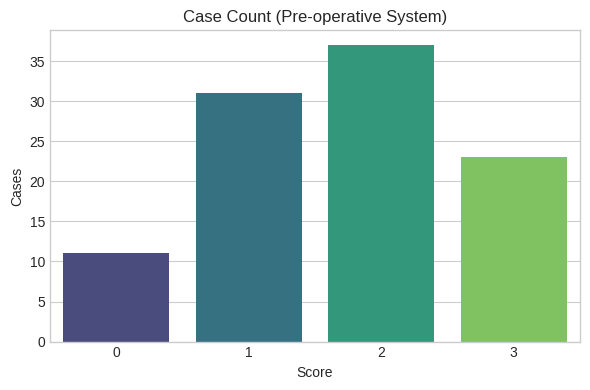

Plot saved: /content/super_flexible_scoring_eval_v2/Rate_Pre-operative.png


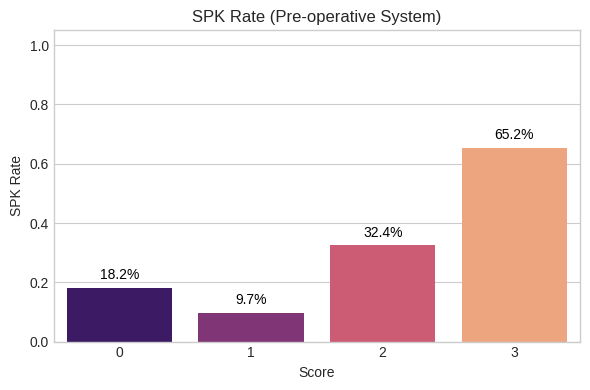


--- Summary (LogReg on Final Pre-operative Score - Stored Model) ---
                           Logit Regression Results                           
Dep. Variable:               SPK post   No. Observations:                  102
Model:                          Logit   Df Residuals:                      100
Method:                           MLE   Df Model:                            1
Date:                Mon, 12 May 2025   Pseudo R-squ.:                  0.1360
Time:                        16:54:45   Log-Likelihood:                -54.819
converged:                       True   LL-Null:                       -63.449
Covariance Type:            nonrobust   LLR p-value:                 3.261e-05
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.8023      0.631     -4.441      0.000      -4.039      -1.566
Final Score     1.0784      0.291      3.710      0.000   

CI 2.5%  CI 97.5%  Odds Ratio
const               0.018     0.209       0.061
temp_total_score    1.663     5.197       2.940

ROC saved: /content/super_flexible_scoring_eval_v2/ROC_Pre-operative.png


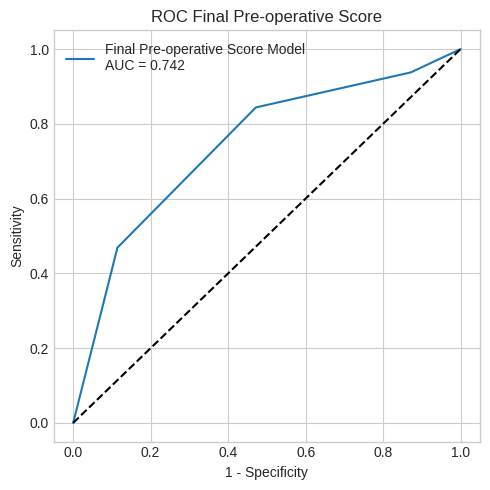


Rules for the Best Pre-operative Scoring System (from Rule Set: RS60_mrd1pre_le0.5_2pt_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpre_lt6_1pt):
  - ΔMRD-1: Add 1 point(s) if ΔMRD-1 >= 2.5 mm (1pt).
  - levator_function pre: Add 1 point(s) if Levator < 9.0 mm (1pt).
  - BUT pre: Add 1 point(s) if BUT pre < 6.0s (1pt).

--- Overall Best Pre-operative Scoring System ---
Rule Set Used: RS58_mrd1pre_le0.5_2pt_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpre_lt6_1pt_butpost_lt4_1pt
Selected Score Factors (3): ΔMRD-1, levator_function pre, BUT pre
Mean 5-Fold CV AUC: 0.7446 (+/- 0.1069)
Original Training AUC of Score Model: 0.7420

--- Score Distribution and SPK Incidence for Best Pre-operative Scoring System ---


final_score  Total_Cases  SPK_Positive_Cases  SPK_Rate  SPK_Rate_Percent
0            0           11                   2  0.181818              18.2
1            1           31                   3  0.096774               9.7
2            2           37                  12  0.324324              32.4
3            3           23                  15  0.652174              65.2

Plot saved: /content/super_flexible_scoring_eval_v2/Count_Pre-operative.png


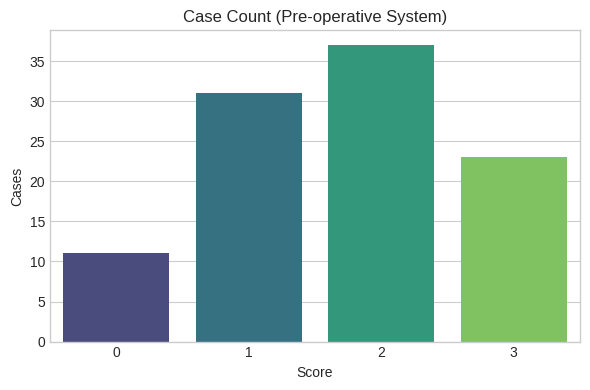

Plot saved: /content/super_flexible_scoring_eval_v2/Rate_Pre-operative.png


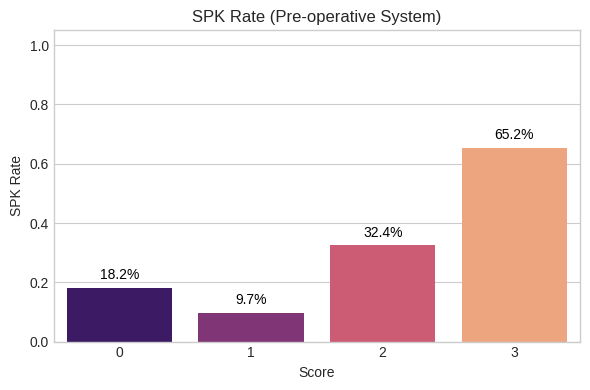


--- Summary (LogReg on Final Pre-operative Score - Stored Model) ---
                           Logit Regression Results                           
Dep. Variable:               SPK post   No. Observations:                  102
Model:                          Logit   Df Residuals:                      100
Method:                           MLE   Df Model:                            1
Date:                Mon, 12 May 2025   Pseudo R-squ.:                  0.1360
Time:                        16:54:47   Log-Likelihood:                -54.819
converged:                       True   LL-Null:                       -63.449
Covariance Type:            nonrobust   LLR p-value:                 3.261e-05
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.8023      0.631     -4.441      0.000      -4.039      -1.566
Final Score     1.0784      0.291      3.710      0.000   

CI 2.5%  CI 97.5%  Odds Ratio
const               0.018     0.209       0.061
temp_total_score    1.663     5.197       2.940

ROC saved: /content/super_flexible_scoring_eval_v2/ROC_Pre-operative.png


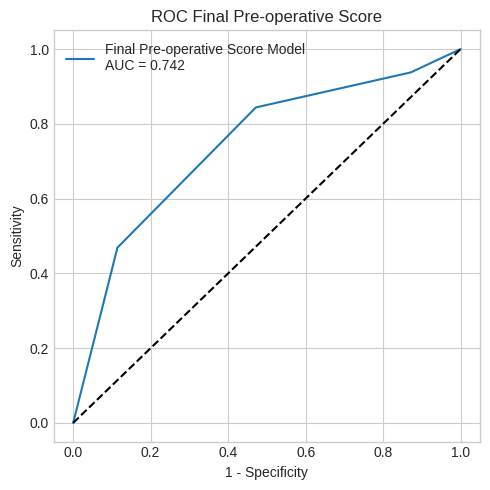


Rules for the Best Pre-operative Scoring System (from Rule Set: RS58_mrd1pre_le0.5_2pt_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpre_lt6_1pt_butpost_lt4_1pt):
  - ΔMRD-1: Add 1 point(s) if ΔMRD-1 >= 2.5 mm (1pt).
  - levator_function pre: Add 1 point(s) if Levator < 9.0 mm (1pt).
  - BUT pre: Add 1 point(s) if BUT pre < 6.0s (1pt).

--- Overall Best Pre-operative Scoring System ---
Rule Set Used: RS132_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpre_lt6_1pt
Selected Score Factors (3): ΔMRD-1, levator_function pre, BUT pre
Mean 5-Fold CV AUC: 0.7446 (+/- 0.1069)
Original Training AUC of Score Model: 0.7420

--- Score Distribution and SPK Incidence for Best Pre-operative Scoring System ---


final_score  Total_Cases  SPK_Positive_Cases  SPK_Rate  SPK_Rate_Percent
0            0           11                   2  0.181818              18.2
1            1           31                   3  0.096774               9.7
2            2           37                  12  0.324324              32.4
3            3           23                  15  0.652174              65.2

Plot saved: /content/super_flexible_scoring_eval_v2/Count_Pre-operative.png


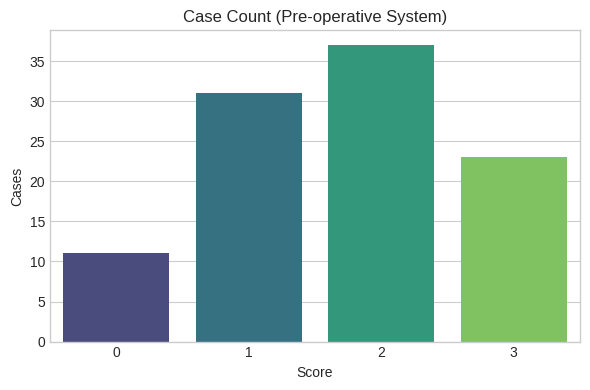

Plot saved: /content/super_flexible_scoring_eval_v2/Rate_Pre-operative.png


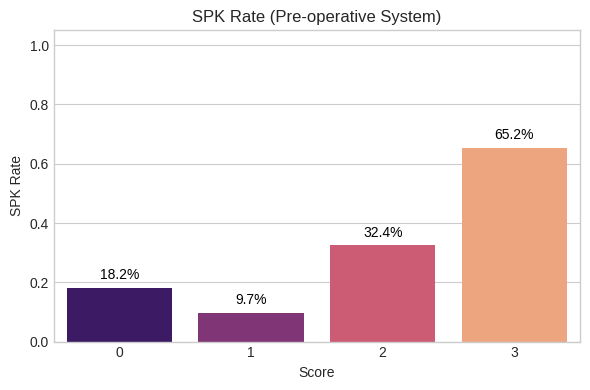


--- Summary (LogReg on Final Pre-operative Score - Stored Model) ---
                           Logit Regression Results                           
Dep. Variable:               SPK post   No. Observations:                  102
Model:                          Logit   Df Residuals:                      100
Method:                           MLE   Df Model:                            1
Date:                Mon, 12 May 2025   Pseudo R-squ.:                  0.1360
Time:                        16:54:49   Log-Likelihood:                -54.819
converged:                       True   LL-Null:                       -63.449
Covariance Type:            nonrobust   LLR p-value:                 3.261e-05
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.8023      0.631     -4.441      0.000      -4.039      -1.566
Final Score     1.0784      0.291      3.710      0.000   

CI 2.5%  CI 97.5%  Odds Ratio
const               0.018     0.209       0.061
temp_total_score    1.663     5.197       2.940

ROC saved: /content/super_flexible_scoring_eval_v2/ROC_Pre-operative.png


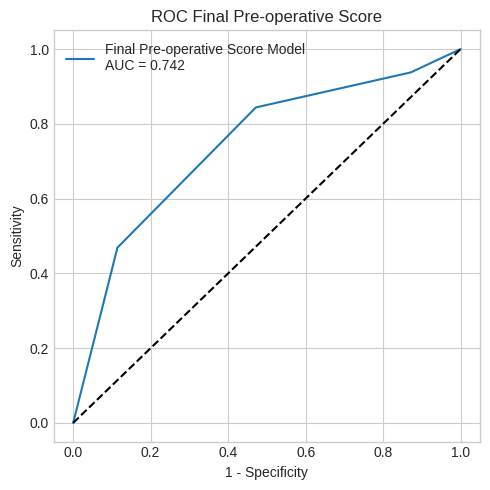


Rules for the Best Pre-operative Scoring System (from Rule Set: RS132_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpre_lt6_1pt):
  - ΔMRD-1: Add 1 point(s) if ΔMRD-1 >= 2.5 mm (1pt).
  - levator_function pre: Add 1 point(s) if Levator < 9.0 mm (1pt).
  - BUT pre: Add 1 point(s) if BUT pre < 6.0s (1pt).

--- Overall Best Pre-operative Scoring System ---
Rule Set Used: RS130_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpre_lt6_1pt_butpost_lt4_1pt
Selected Score Factors (3): ΔMRD-1, levator_function pre, BUT pre
Mean 5-Fold CV AUC: 0.7446 (+/- 0.1069)
Original Training AUC of Score Model: 0.7420

--- Score Distribution and SPK Incidence for Best Pre-operative Scoring System ---


final_score  Total_Cases  SPK_Positive_Cases  SPK_Rate  SPK_Rate_Percent
0            0           11                   2  0.181818              18.2
1            1           31                   3  0.096774               9.7
2            2           37                  12  0.324324              32.4
3            3           23                  15  0.652174              65.2

Plot saved: /content/super_flexible_scoring_eval_v2/Count_Pre-operative.png


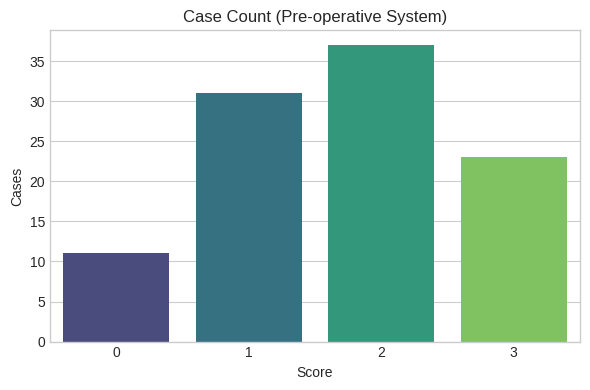

Plot saved: /content/super_flexible_scoring_eval_v2/Rate_Pre-operative.png


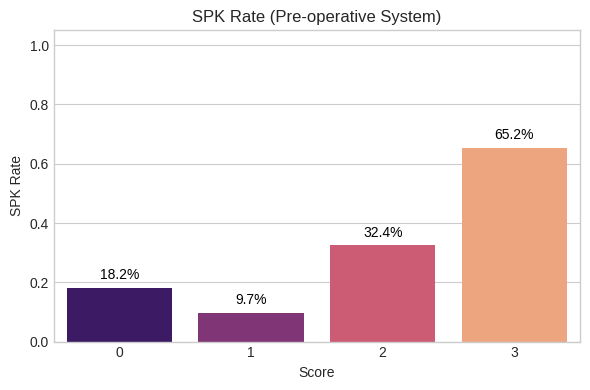


--- Summary (LogReg on Final Pre-operative Score - Stored Model) ---
                           Logit Regression Results                           
Dep. Variable:               SPK post   No. Observations:                  102
Model:                          Logit   Df Residuals:                      100
Method:                           MLE   Df Model:                            1
Date:                Mon, 12 May 2025   Pseudo R-squ.:                  0.1360
Time:                        16:54:50   Log-Likelihood:                -54.819
converged:                       True   LL-Null:                       -63.449
Covariance Type:            nonrobust   LLR p-value:                 3.261e-05
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.8023      0.631     -4.441      0.000      -4.039      -1.566
Final Score     1.0784      0.291      3.710      0.000   

CI 2.5%  CI 97.5%  Odds Ratio
const               0.018     0.209       0.061
temp_total_score    1.663     5.197       2.940

ROC saved: /content/super_flexible_scoring_eval_v2/ROC_Pre-operative.png


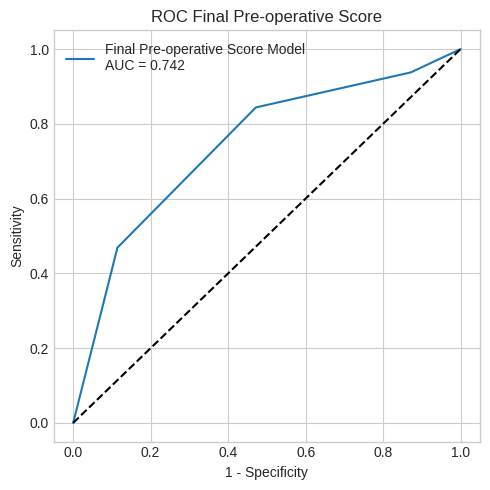


Rules for the Best Pre-operative Scoring System (from Rule Set: RS130_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpre_lt6_1pt_butpost_lt4_1pt):
  - ΔMRD-1: Add 1 point(s) if ΔMRD-1 >= 2.5 mm (1pt).
  - levator_function pre: Add 1 point(s) if Levator < 9.0 mm (1pt).
  - BUT pre: Add 1 point(s) if BUT pre < 6.0s (1pt).

--- Overall Best Pre-operative Scoring System ---
Rule Set Used: RS131_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpre_lt6_1pt_butpost_lt5_1pt
Selected Score Factors (3): ΔMRD-1, levator_function pre, BUT pre
Mean 5-Fold CV AUC: 0.7446 (+/- 0.1069)
Original Training AUC of Score Model: 0.7420

--- Score Distribution and SPK Incidence for Best Pre-operative Scoring System ---


final_score  Total_Cases  SPK_Positive_Cases  SPK_Rate  SPK_Rate_Percent
0            0           11                   2  0.181818              18.2
1            1           31                   3  0.096774               9.7
2            2           37                  12  0.324324              32.4
3            3           23                  15  0.652174              65.2

Plot saved: /content/super_flexible_scoring_eval_v2/Count_Pre-operative.png


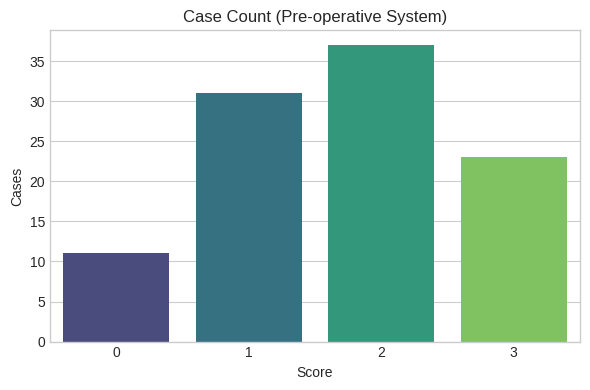

Plot saved: /content/super_flexible_scoring_eval_v2/Rate_Pre-operative.png


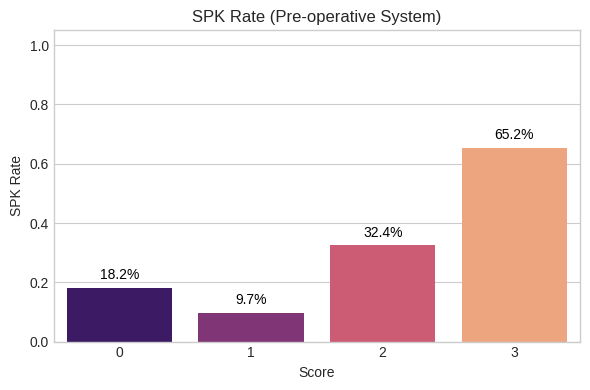


--- Summary (LogReg on Final Pre-operative Score - Stored Model) ---
                           Logit Regression Results                           
Dep. Variable:               SPK post   No. Observations:                  102
Model:                          Logit   Df Residuals:                      100
Method:                           MLE   Df Model:                            1
Date:                Mon, 12 May 2025   Pseudo R-squ.:                  0.1360
Time:                        16:54:51   Log-Likelihood:                -54.819
converged:                       True   LL-Null:                       -63.449
Covariance Type:            nonrobust   LLR p-value:                 3.261e-05
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.8023      0.631     -4.441      0.000      -4.039      -1.566
Final Score     1.0784      0.291      3.710      0.000   

CI 2.5%  CI 97.5%  Odds Ratio
const               0.018     0.209       0.061
temp_total_score    1.663     5.197       2.940

ROC saved: /content/super_flexible_scoring_eval_v2/ROC_Pre-operative.png


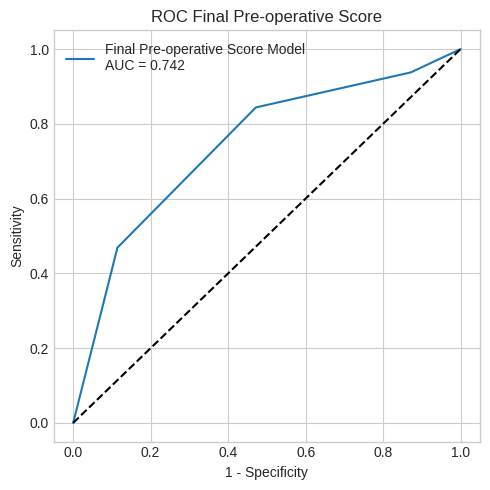


Rules for the Best Pre-operative Scoring System (from Rule Set: RS131_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpre_lt6_1pt_butpost_lt5_1pt):
  - ΔMRD-1: Add 1 point(s) if ΔMRD-1 >= 2.5 mm (1pt).
  - levator_function pre: Add 1 point(s) if Levator < 9.0 mm (1pt).
  - BUT pre: Add 1 point(s) if BUT pre < 6.0s (1pt).

--- Overall Best Pre-operative Scoring System ---
Rule Set Used: RS59_mrd1pre_le0.5_2pt_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpre_lt6_1pt_butpost_lt5_1pt
Selected Score Factors (3): ΔMRD-1, levator_function pre, BUT pre
Mean 5-Fold CV AUC: 0.7446 (+/- 0.1069)
Original Training AUC of Score Model: 0.7420

--- Score Distribution and SPK Incidence for Best Pre-operative Scoring System ---


final_score  Total_Cases  SPK_Positive_Cases  SPK_Rate  SPK_Rate_Percent
0            0           11                   2  0.181818              18.2
1            1           31                   3  0.096774               9.7
2            2           37                  12  0.324324              32.4
3            3           23                  15  0.652174              65.2

Plot saved: /content/super_flexible_scoring_eval_v2/Count_Pre-operative.png


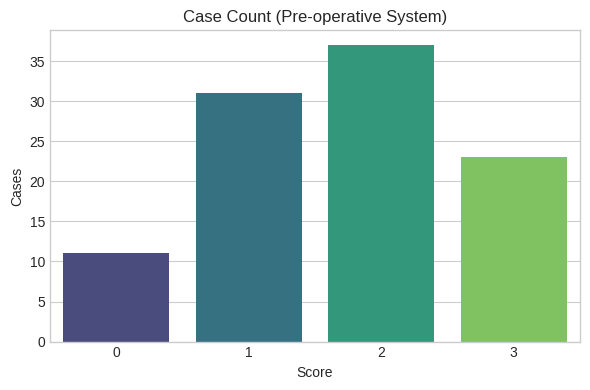

Plot saved: /content/super_flexible_scoring_eval_v2/Rate_Pre-operative.png


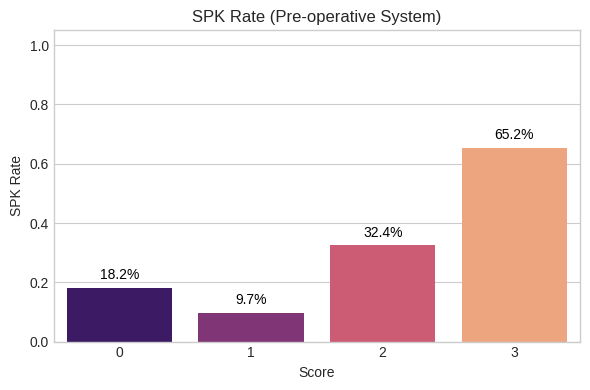


--- Summary (LogReg on Final Pre-operative Score - Stored Model) ---
                           Logit Regression Results                           
Dep. Variable:               SPK post   No. Observations:                  102
Model:                          Logit   Df Residuals:                      100
Method:                           MLE   Df Model:                            1
Date:                Mon, 12 May 2025   Pseudo R-squ.:                  0.1360
Time:                        16:54:52   Log-Likelihood:                -54.819
converged:                       True   LL-Null:                       -63.449
Covariance Type:            nonrobust   LLR p-value:                 3.261e-05
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.8023      0.631     -4.441      0.000      -4.039      -1.566
Final Score     1.0784      0.291      3.710      0.000   

CI 2.5%  CI 97.5%  Odds Ratio
const               0.018     0.209       0.061
temp_total_score    1.663     5.197       2.940

ROC saved: /content/super_flexible_scoring_eval_v2/ROC_Pre-operative.png


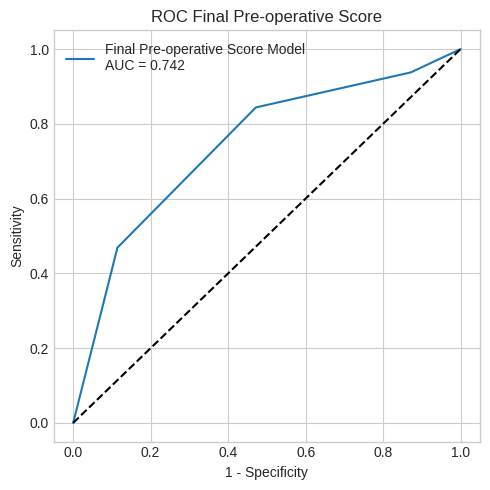


Rules for the Best Pre-operative Scoring System (from Rule Set: RS59_mrd1pre_le0.5_2pt_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpre_lt6_1pt_butpost_lt5_1pt):
  - ΔMRD-1: Add 1 point(s) if ΔMRD-1 >= 2.5 mm (1pt).
  - levator_function pre: Add 1 point(s) if Levator < 9.0 mm (1pt).
  - BUT pre: Add 1 point(s) if BUT pre < 6.0s (1pt).

--- Displaying Details for Best Post-operative Model(s) (Mean CV AUC ≈ 0.8179) ---

--- Overall Best Post-operative Scoring System ---
Rule Set Used: RS134_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpost_lt5_1pt
Selected Score Factors (3): ΔMRD-1, levator_function pre, BUT post
Mean 5-Fold CV AUC: 0.8179 (+/- 0.0817)
Original Training AUC of Score Model: 0.7987

--- Score Distribution and SPK Incidence for Best Post-operative Scoring System ---


final_score  Total_Cases  SPK_Positive_Cases  SPK_Rate  SPK_Rate_Percent
0            0           17                   0  0.000000               0.0
1            1           36                   7  0.194444              19.4
2            2           33                  12  0.363636              36.4
3            3           16                  13  0.812500              81.2

Plot saved: /content/super_flexible_scoring_eval_v2/Count_Post-operative.png


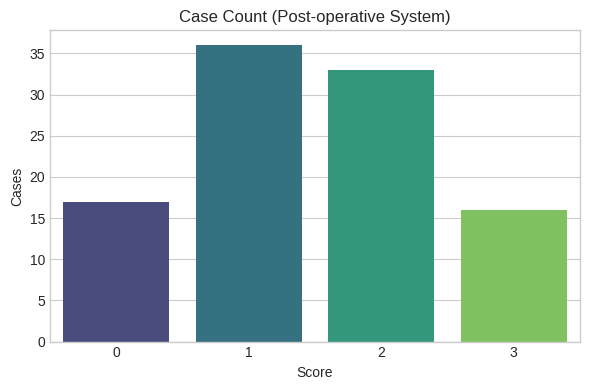

Plot saved: /content/super_flexible_scoring_eval_v2/Rate_Post-operative.png


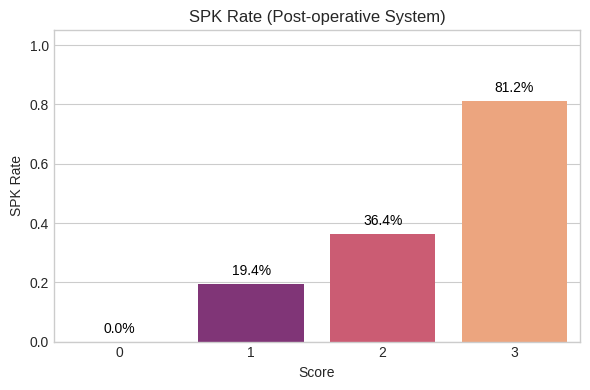


--- Summary (LogReg on Final Post-operative Score - Stored Model) ---
                           Logit Regression Results                           
Dep. Variable:               SPK post   No. Observations:                  102
Model:                          Logit   Df Residuals:                      100
Method:                           MLE   Df Model:                            1
Date:                Mon, 12 May 2025   Pseudo R-squ.:                  0.2367
Time:                        16:54:54   Log-Likelihood:                -48.429
converged:                       True   LL-Null:                       -63.449
Covariance Type:            nonrobust   LLR p-value:                 4.233e-08
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -3.3054      0.657     -5.029      0.000      -4.594      -2.017
Final Score     1.5012      0.332      4.525      0.000  

CI 2.5%  CI 97.5%  Odds Ratio
const               0.010     0.133       0.037
temp_total_score    2.342     8.597       4.487

ROC saved: /content/super_flexible_scoring_eval_v2/ROC_Post-operative.png


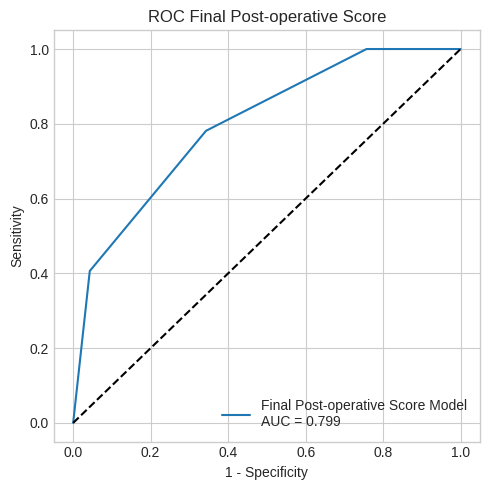


Rules for the Best Post-operative Scoring System (from Rule Set: RS134_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpost_lt5_1pt):
  - ΔMRD-1: Add 1 point(s) if ΔMRD-1 >= 2.5 mm (1pt).
  - levator_function pre: Add 1 point(s) if Levator < 9.0 mm (1pt).
  - BUT post: Add 1 point(s) if BUT post < 5.0s (1pt).

--- Overall Best Post-operative Scoring System ---
Rule Set Used: RS128_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpre_lt5_1pt_butpost_lt5_1pt
Selected Score Factors (3): ΔMRD-1, levator_function pre, BUT post
Mean 5-Fold CV AUC: 0.8179 (+/- 0.0817)
Original Training AUC of Score Model: 0.7987

--- Score Distribution and SPK Incidence for Best Post-operative Scoring System ---


final_score  Total_Cases  SPK_Positive_Cases  SPK_Rate  SPK_Rate_Percent
0            0           17                   0  0.000000               0.0
1            1           36                   7  0.194444              19.4
2            2           33                  12  0.363636              36.4
3            3           16                  13  0.812500              81.2

Plot saved: /content/super_flexible_scoring_eval_v2/Count_Post-operative.png


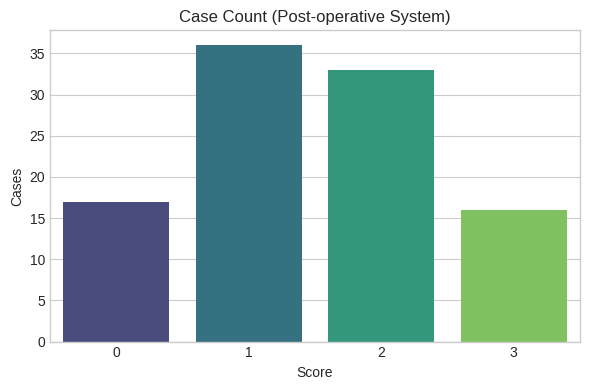

Plot saved: /content/super_flexible_scoring_eval_v2/Rate_Post-operative.png


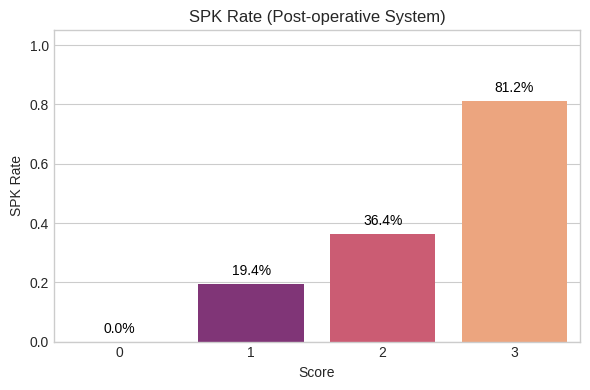


--- Summary (LogReg on Final Post-operative Score - Stored Model) ---
                           Logit Regression Results                           
Dep. Variable:               SPK post   No. Observations:                  102
Model:                          Logit   Df Residuals:                      100
Method:                           MLE   Df Model:                            1
Date:                Mon, 12 May 2025   Pseudo R-squ.:                  0.2367
Time:                        16:54:55   Log-Likelihood:                -48.429
converged:                       True   LL-Null:                       -63.449
Covariance Type:            nonrobust   LLR p-value:                 4.233e-08
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -3.3054      0.657     -5.029      0.000      -4.594      -2.017
Final Score     1.5012      0.332      4.525      0.000  

CI 2.5%  CI 97.5%  Odds Ratio
const               0.010     0.133       0.037
temp_total_score    2.342     8.597       4.487

ROC saved: /content/super_flexible_scoring_eval_v2/ROC_Post-operative.png


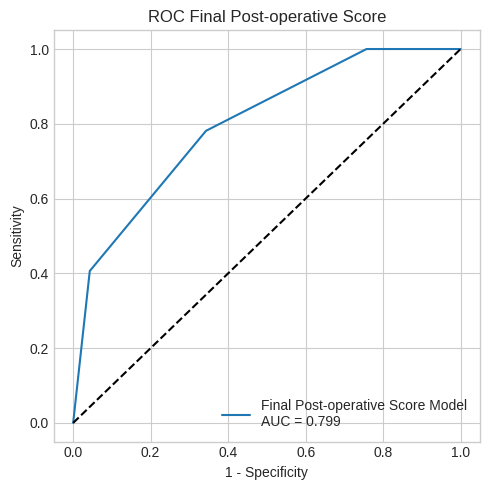


Rules for the Best Post-operative Scoring System (from Rule Set: RS128_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpre_lt5_1pt_butpost_lt5_1pt):
  - ΔMRD-1: Add 1 point(s) if ΔMRD-1 >= 2.5 mm (1pt).
  - levator_function pre: Add 1 point(s) if Levator < 9.0 mm (1pt).
  - BUT post: Add 1 point(s) if BUT post < 5.0s (1pt).

--- Overall Best Post-operative Scoring System ---
Rule Set Used: RS56_mrd1pre_le0.5_2pt_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpre_lt5_1pt_butpost_lt5_1pt
Selected Score Factors (3): ΔMRD-1, levator_function pre, BUT post
Mean 5-Fold CV AUC: 0.8179 (+/- 0.0817)
Original Training AUC of Score Model: 0.7987

--- Score Distribution and SPK Incidence for Best Post-operative Scoring System ---


final_score  Total_Cases  SPK_Positive_Cases  SPK_Rate  SPK_Rate_Percent
0            0           17                   0  0.000000               0.0
1            1           36                   7  0.194444              19.4
2            2           33                  12  0.363636              36.4
3            3           16                  13  0.812500              81.2

Plot saved: /content/super_flexible_scoring_eval_v2/Count_Post-operative.png


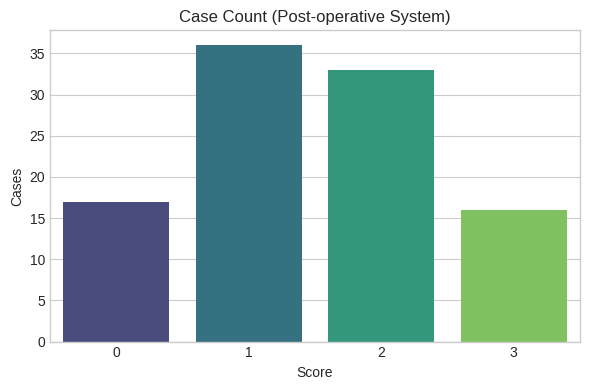

Plot saved: /content/super_flexible_scoring_eval_v2/Rate_Post-operative.png


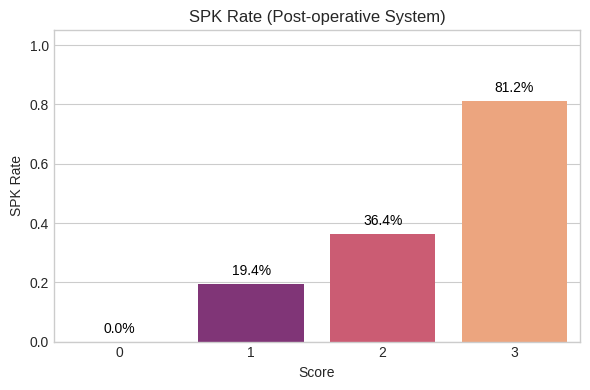


--- Summary (LogReg on Final Post-operative Score - Stored Model) ---
                           Logit Regression Results                           
Dep. Variable:               SPK post   No. Observations:                  102
Model:                          Logit   Df Residuals:                      100
Method:                           MLE   Df Model:                            1
Date:                Mon, 12 May 2025   Pseudo R-squ.:                  0.2367
Time:                        16:54:56   Log-Likelihood:                -48.429
converged:                       True   LL-Null:                       -63.449
Covariance Type:            nonrobust   LLR p-value:                 4.233e-08
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -3.3054      0.657     -5.029      0.000      -4.594      -2.017
Final Score     1.5012      0.332      4.525      0.000  

CI 2.5%  CI 97.5%  Odds Ratio
const               0.010     0.133       0.037
temp_total_score    2.342     8.597       4.487

ROC saved: /content/super_flexible_scoring_eval_v2/ROC_Post-operative.png


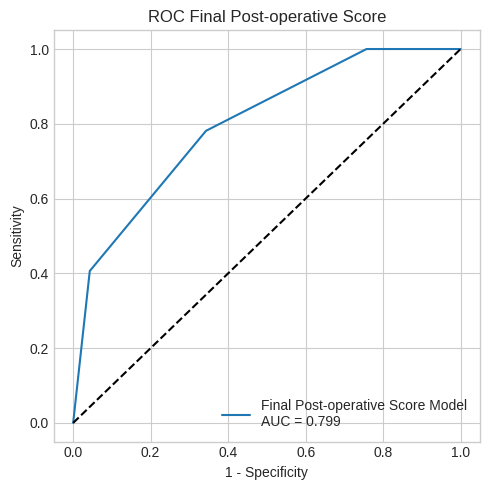


Rules for the Best Post-operative Scoring System (from Rule Set: RS56_mrd1pre_le0.5_2pt_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpre_lt5_1pt_butpost_lt5_1pt):
  - ΔMRD-1: Add 1 point(s) if ΔMRD-1 >= 2.5 mm (1pt).
  - levator_function pre: Add 1 point(s) if Levator < 9.0 mm (1pt).
  - BUT post: Add 1 point(s) if BUT post < 5.0s (1pt).

--- Overall Best Post-operative Scoring System ---
Rule Set Used: RS59_mrd1pre_le0.5_2pt_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpre_lt6_1pt_butpost_lt5_1pt
Selected Score Factors (3): ΔMRD-1, levator_function pre, BUT post
Mean 5-Fold CV AUC: 0.8179 (+/- 0.0817)
Original Training AUC of Score Model: 0.7987

--- Score Distribution and SPK Incidence for Best Post-operative Scoring System ---


final_score  Total_Cases  SPK_Positive_Cases  SPK_Rate  SPK_Rate_Percent
0            0           17                   0  0.000000               0.0
1            1           36                   7  0.194444              19.4
2            2           33                  12  0.363636              36.4
3            3           16                  13  0.812500              81.2

Plot saved: /content/super_flexible_scoring_eval_v2/Count_Post-operative.png


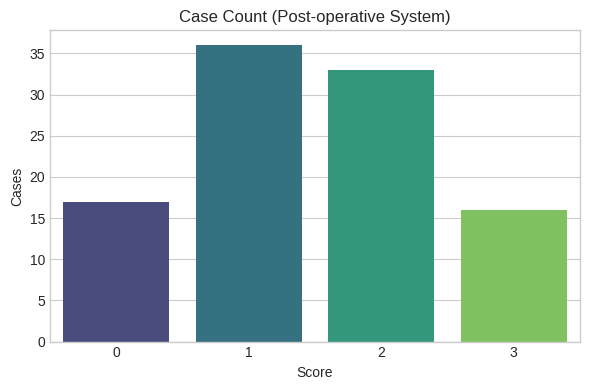

Plot saved: /content/super_flexible_scoring_eval_v2/Rate_Post-operative.png


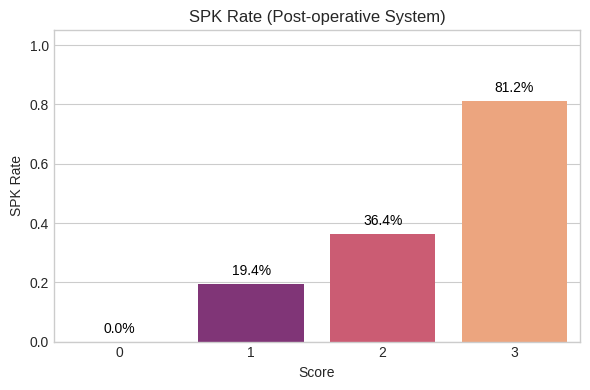


--- Summary (LogReg on Final Post-operative Score - Stored Model) ---
                           Logit Regression Results                           
Dep. Variable:               SPK post   No. Observations:                  102
Model:                          Logit   Df Residuals:                      100
Method:                           MLE   Df Model:                            1
Date:                Mon, 12 May 2025   Pseudo R-squ.:                  0.2367
Time:                        16:54:58   Log-Likelihood:                -48.429
converged:                       True   LL-Null:                       -63.449
Covariance Type:            nonrobust   LLR p-value:                 4.233e-08
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -3.3054      0.657     -5.029      0.000      -4.594      -2.017
Final Score     1.5012      0.332      4.525      0.000  

CI 2.5%  CI 97.5%  Odds Ratio
const               0.010     0.133       0.037
temp_total_score    2.342     8.597       4.487

ROC saved: /content/super_flexible_scoring_eval_v2/ROC_Post-operative.png


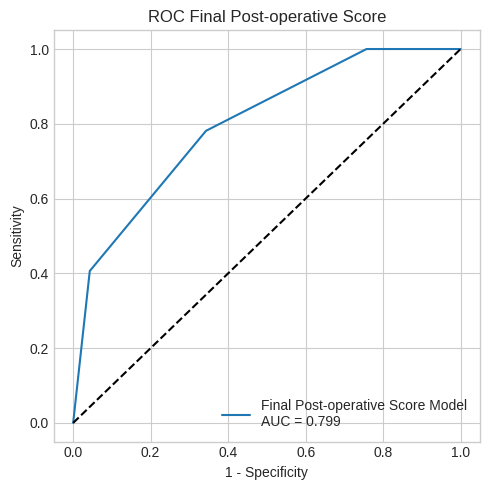


Rules for the Best Post-operative Scoring System (from Rule Set: RS59_mrd1pre_le0.5_2pt_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpre_lt6_1pt_butpost_lt5_1pt):
  - ΔMRD-1: Add 1 point(s) if ΔMRD-1 >= 2.5 mm (1pt).
  - levator_function pre: Add 1 point(s) if Levator < 9.0 mm (1pt).
  - BUT post: Add 1 point(s) if BUT post < 5.0s (1pt).

--- Overall Best Post-operative Scoring System ---
Rule Set Used: RS131_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpre_lt6_1pt_butpost_lt5_1pt
Selected Score Factors (3): ΔMRD-1, levator_function pre, BUT post
Mean 5-Fold CV AUC: 0.8179 (+/- 0.0817)
Original Training AUC of Score Model: 0.7987

--- Score Distribution and SPK Incidence for Best Post-operative Scoring System ---


final_score  Total_Cases  SPK_Positive_Cases  SPK_Rate  SPK_Rate_Percent
0            0           17                   0  0.000000               0.0
1            1           36                   7  0.194444              19.4
2            2           33                  12  0.363636              36.4
3            3           16                  13  0.812500              81.2

Plot saved: /content/super_flexible_scoring_eval_v2/Count_Post-operative.png


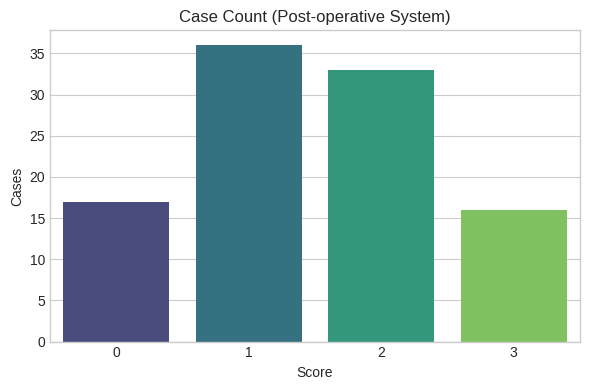

Plot saved: /content/super_flexible_scoring_eval_v2/Rate_Post-operative.png


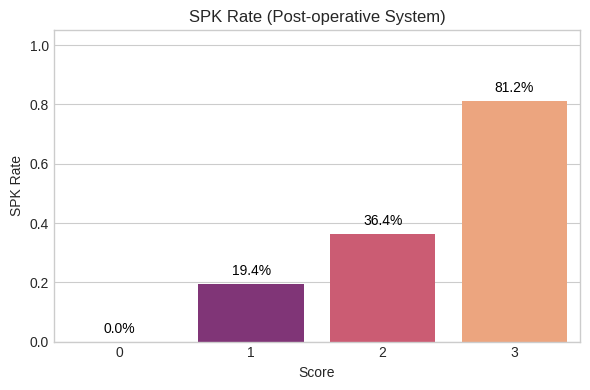


--- Summary (LogReg on Final Post-operative Score - Stored Model) ---
                           Logit Regression Results                           
Dep. Variable:               SPK post   No. Observations:                  102
Model:                          Logit   Df Residuals:                      100
Method:                           MLE   Df Model:                            1
Date:                Mon, 12 May 2025   Pseudo R-squ.:                  0.2367
Time:                        16:54:59   Log-Likelihood:                -48.429
converged:                       True   LL-Null:                       -63.449
Covariance Type:            nonrobust   LLR p-value:                 4.233e-08
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -3.3054      0.657     -5.029      0.000      -4.594      -2.017
Final Score     1.5012      0.332      4.525      0.000  

CI 2.5%  CI 97.5%  Odds Ratio
const               0.010     0.133       0.037
temp_total_score    2.342     8.597       4.487

ROC saved: /content/super_flexible_scoring_eval_v2/ROC_Post-operative.png


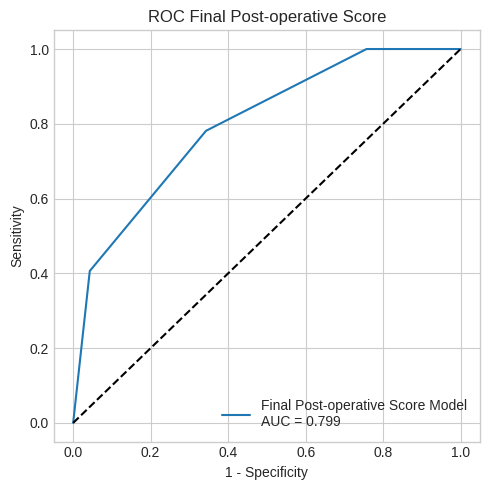


Rules for the Best Post-operative Scoring System (from Rule Set: RS131_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpre_lt6_1pt_butpost_lt5_1pt):
  - ΔMRD-1: Add 1 point(s) if ΔMRD-1 >= 2.5 mm (1pt).
  - levator_function pre: Add 1 point(s) if Levator < 9.0 mm (1pt).
  - BUT post: Add 1 point(s) if BUT post < 5.0s (1pt).

--- Overall Best Post-operative Scoring System ---
Rule Set Used: RS62_mrd1pre_le0.5_2pt_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpost_lt5_1pt
Selected Score Factors (3): ΔMRD-1, levator_function pre, BUT post
Mean 5-Fold CV AUC: 0.8179 (+/- 0.0817)
Original Training AUC of Score Model: 0.7987

--- Score Distribution and SPK Incidence for Best Post-operative Scoring System ---


final_score  Total_Cases  SPK_Positive_Cases  SPK_Rate  SPK_Rate_Percent
0            0           17                   0  0.000000               0.0
1            1           36                   7  0.194444              19.4
2            2           33                  12  0.363636              36.4
3            3           16                  13  0.812500              81.2

Plot saved: /content/super_flexible_scoring_eval_v2/Count_Post-operative.png


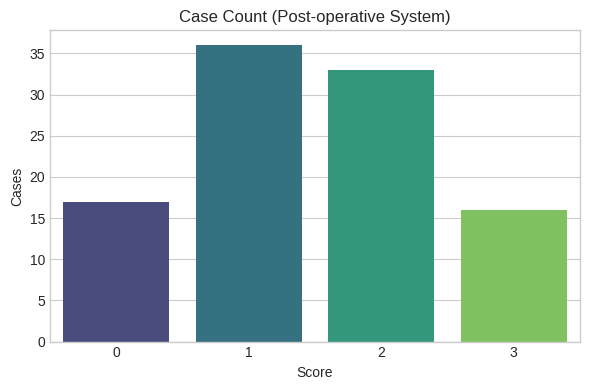

Plot saved: /content/super_flexible_scoring_eval_v2/Rate_Post-operative.png


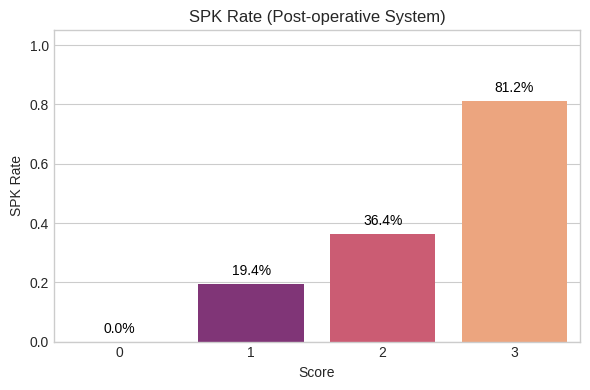


--- Summary (LogReg on Final Post-operative Score - Stored Model) ---
                           Logit Regression Results                           
Dep. Variable:               SPK post   No. Observations:                  102
Model:                          Logit   Df Residuals:                      100
Method:                           MLE   Df Model:                            1
Date:                Mon, 12 May 2025   Pseudo R-squ.:                  0.2367
Time:                        16:55:01   Log-Likelihood:                -48.429
converged:                       True   LL-Null:                       -63.449
Covariance Type:            nonrobust   LLR p-value:                 4.233e-08
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -3.3054      0.657     -5.029      0.000      -4.594      -2.017
Final Score     1.5012      0.332      4.525      0.000  

CI 2.5%  CI 97.5%  Odds Ratio
const               0.010     0.133       0.037
temp_total_score    2.342     8.597       4.487

ROC saved: /content/super_flexible_scoring_eval_v2/ROC_Post-operative.png


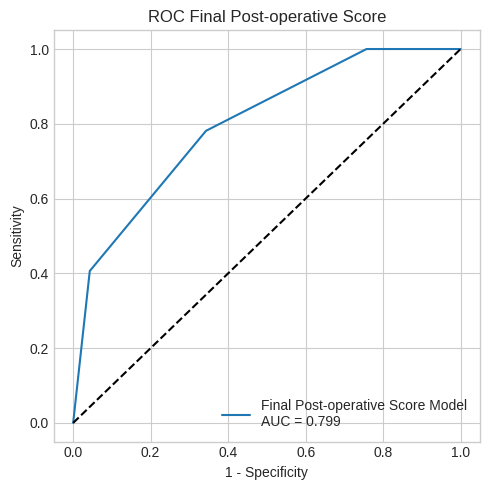


Rules for the Best Post-operative Scoring System (from Rule Set: RS62_mrd1pre_le0.5_2pt_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpost_lt5_1pt):
  - ΔMRD-1: Add 1 point(s) if ΔMRD-1 >= 2.5 mm (1pt).
  - levator_function pre: Add 1 point(s) if Levator < 9.0 mm (1pt).
  - BUT post: Add 1 point(s) if BUT post < 5.0s (1pt).


=== Overall Best Scoring Systems (Selected by Best Mean 5-Fold CV AUC across all Rule Sets) ===

--- Top 10 Scoring Systems Overall (Ranked by Mean CV AUC) ---


rule_set_name  \
793  RS134_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpost_lt5_1pt   
757  RS128_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpre_lt5_1...   
333  RS56_mrd1pre_le0.5_2pt_dmrd1_ge2.5_1pt_lev_lt9...   
351  RS59_mrd1pre_le0.5_2pt_dmrd1_ge2.5_1pt_lev_lt9...   
775  RS131_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpre_lt6_1...   
369  RS62_mrd1pre_le0.5_2pt_dmrd1_ge2.5_1pt_lev_lt9...   
225  RS38_mrd1pre_le0.5_2pt_dmrd1_ge2.5_1pt_lev_lt7...   
667  RS113_dmrd1_ge2.5_1pt_lev_lt7_1pt_butpre_lt6_1...   
685  RS116_dmrd1_ge2.5_1pt_lev_lt7_1pt_butpost_lt5_1pt   
649  RS110_dmrd1_ge2.5_1pt_lev_lt7_1pt_butpre_lt5_1...   

                              score_factors  num_score_factors  training_auc  \
793  ΔMRD-1, levator_function pre, BUT post                  3        0.7987   
757  ΔMRD-1, levator_function pre, BUT post                  3        0.7987   
333  ΔMRD-1, levator_function pre, BUT post                  3        0.7987   
351  ΔMRD-1, levator_function pre, BUT post                  3        0.7987   
775  ΔMRD-1, levator_function pre, BUT post                  3        0.7987   
369  ΔMRD-1, levator_function pre, BUT post                  3        0.7987   
225  ΔMRD-1, levator_function pre, BUT post                  3        0.8080   
667  ΔMRD-1, levator_function pre, BUT post                  3        0.8080   
685  ΔMRD-1, levator_function pre, BUT post                  3        0.8080   
649  ΔMRD-1, levator_function pre, BUT post                  3        0.8080   

     mean_cv_auc  std_cv_auc  
793       0.8179      0.0817  
757       0.8179      0.0817  
333       0.8179      0.0817  
351       0.8179      0.0817  
775       0.8179      0.0817  
369       0.8179      0.0817  
225       0.8099      0.0598  
667       0.8099      0.0598  
685       0.8099      0.0598  
649       0.8099      0.0598


--- Overall Best Pre-operative Scoring System ---
Rule Set Used: RS60_mrd1pre_le0.5_2pt_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpre_lt6_1pt
Selected Score Factors (3): ΔMRD-1, levator_function pre, BUT pre
Mean 5-Fold CV AUC: 0.7446 (+/- 0.1069)
Original Training AUC of Score Model: 0.7420

--- Score Distribution and SPK Incidence for Best Pre-operative Scoring System ---


final_score  Total_Cases  SPK_Positive_Cases  SPK_Rate  SPK_Rate_Percent
0            0           11                   2  0.181818              18.2
1            1           31                   3  0.096774               9.7
2            2           37                  12  0.324324              32.4
3            3           23                  15  0.652174              65.2

Plot saved: /content/super_flexible_scoring_eval_v2/Count_Pre-operative.png


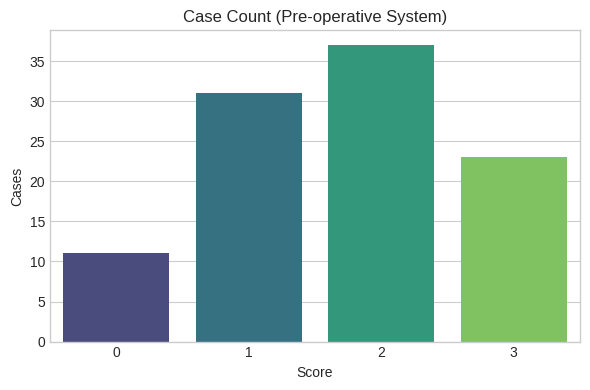

Plot saved: /content/super_flexible_scoring_eval_v2/Rate_Pre-operative.png


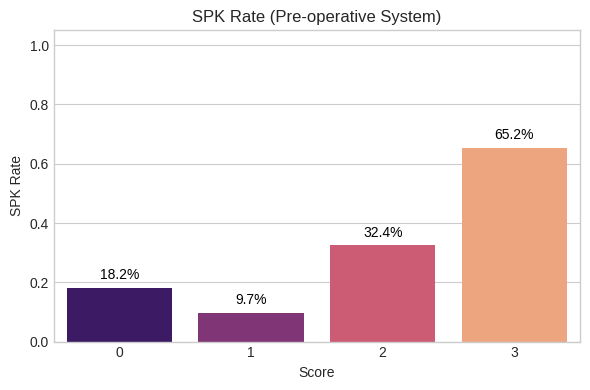


--- Summary (LogReg on Final Pre-operative Score - Stored Model) ---
                           Logit Regression Results                           
Dep. Variable:               SPK post   No. Observations:                  102
Model:                          Logit   Df Residuals:                      100
Method:                           MLE   Df Model:                            1
Date:                Mon, 12 May 2025   Pseudo R-squ.:                  0.1360
Time:                        16:55:03   Log-Likelihood:                -54.819
converged:                       True   LL-Null:                       -63.449
Covariance Type:            nonrobust   LLR p-value:                 3.261e-05
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.8023      0.631     -4.441      0.000      -4.039      -1.566
Final Score     1.0784      0.291      3.710      0.000   

CI 2.5%  CI 97.5%  Odds Ratio
const               0.018     0.209       0.061
temp_total_score    1.663     5.197       2.940

ROC saved: /content/super_flexible_scoring_eval_v2/ROC_Pre-operative.png


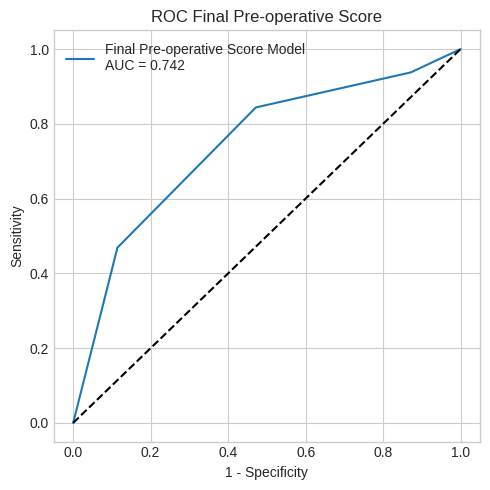


Rules for the Best Pre-operative Scoring System (from Rule Set: RS60_mrd1pre_le0.5_2pt_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpre_lt6_1pt):
  - ΔMRD-1: Add 1 point(s) if ΔMRD-1 >= 2.5 mm (1pt).
  - levator_function pre: Add 1 point(s) if Levator < 9.0 mm (1pt).
  - BUT pre: Add 1 point(s) if BUT pre < 6.0s (1pt).

--- Overall Best Post-operative Scoring System ---
Rule Set Used: RS134_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpost_lt5_1pt
Selected Score Factors (3): ΔMRD-1, levator_function pre, BUT post
Mean 5-Fold CV AUC: 0.8179 (+/- 0.0817)
Original Training AUC of Score Model: 0.7987

--- Score Distribution and SPK Incidence for Best Post-operative Scoring System ---


final_score  Total_Cases  SPK_Positive_Cases  SPK_Rate  SPK_Rate_Percent
0            0           17                   0  0.000000               0.0
1            1           36                   7  0.194444              19.4
2            2           33                  12  0.363636              36.4
3            3           16                  13  0.812500              81.2

Plot saved: /content/super_flexible_scoring_eval_v2/Count_Post-operative.png


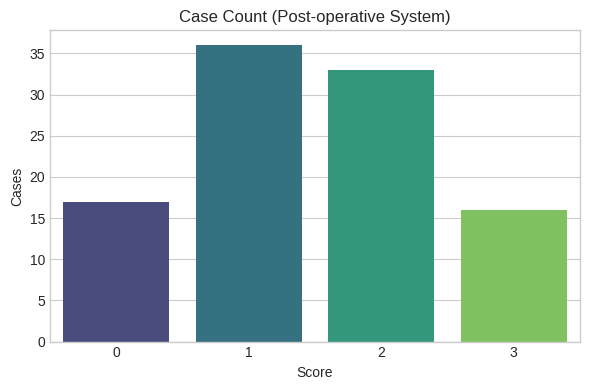

Plot saved: /content/super_flexible_scoring_eval_v2/Rate_Post-operative.png


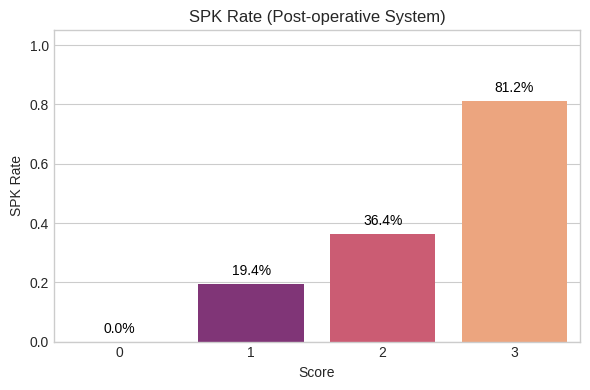


--- Summary (LogReg on Final Post-operative Score - Stored Model) ---
                           Logit Regression Results                           
Dep. Variable:               SPK post   No. Observations:                  102
Model:                          Logit   Df Residuals:                      100
Method:                           MLE   Df Model:                            1
Date:                Mon, 12 May 2025   Pseudo R-squ.:                  0.2367
Time:                        16:55:05   Log-Likelihood:                -48.429
converged:                       True   LL-Null:                       -63.449
Covariance Type:            nonrobust   LLR p-value:                 4.233e-08
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -3.3054      0.657     -5.029      0.000      -4.594      -2.017
Final Score     1.5012      0.332      4.525      0.000  

CI 2.5%  CI 97.5%  Odds Ratio
const               0.010     0.133       0.037
temp_total_score    2.342     8.597       4.487

ROC saved: /content/super_flexible_scoring_eval_v2/ROC_Post-operative.png


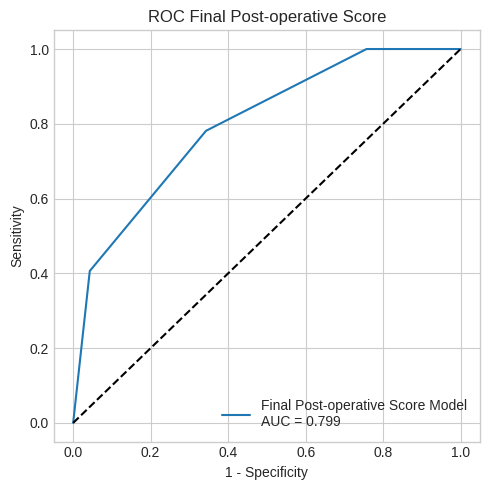


Rules for the Best Post-operative Scoring System (from Rule Set: RS134_dmrd1_ge2.5_1pt_lev_lt9_1pt_butpost_lt5_1pt):
  - ΔMRD-1: Add 1 point(s) if ΔMRD-1 >= 2.5 mm (1pt).
  - levator_function pre: Add 1 point(s) if Levator < 9.0 mm (1pt).
  - BUT post: Add 1 point(s) if BUT post < 5.0s (1pt).

Reminder: The selected scoring system's performance and rules depend on the evaluated rule sets.

Analysis Complete. Check '/content/super_flexible_scoring_eval_v2' for plots.


In [ ]:
# =============================================================
# 眼瞼下垂術後SPKリスク解析：超柔軟スコアリングルール探索と評価 Ver.2 (ルール表示修正)
# =============================================================

# -------------------------------------------------------------
# 0. ライブラリのインポートと基本設定
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations, product # product を追加
from tqdm.auto import tqdm
import joblib

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.sm_exceptions import PerfectSeparationError, ConvergenceWarning

from sklearn.metrics import roc_auc_score, roc_curve, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from IPython.display import display
import warnings
import os
import time

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', message="Maximum Likelihood optimization failed to converge")
warnings.filterwarnings('ignore', message="Method 'first' requires numeric dtype to function correctly")
print("Libraries imported.")

# -------------------------------------------------------------
# 1. Google Drive マウント と ファイル/フォルダ設定
# -------------------------------------------------------------
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    # ★★★ Google Drive内のExcelファイルのパスを指定してください ★★★
    file_path = "/content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ_kit.xlsx"
    # ★★★ 結果を出力するフォルダを指定してください ★★★
    output_dir = "/content/super_flexible_scoring_eval_v2" # 新しいフォルダ名
    print("Google Drive mounted.")
except ModuleNotFoundError:
    print("Running in a non-Colab environment.")
    # ★★★ ローカルのExcelファイルのパスを指定してください ★★★
    file_path = "眼瞼下垂★ドライアイ_kit.xlsx"; # 例
    # ★★★ 結果を出力するフォルダを指定してください ★★★
    output_dir = "./super_flexible_scoring_eval_v2"

os.makedirs(output_dir, exist_ok=True); print(f"Output directory: {output_dir}")

# -------------------------------------------------------------
# 2. データ読み込みと前処理
# -------------------------------------------------------------
print("\n--- 2. Loading and Preprocessing Data ---")
try:
    df_all = pd.read_excel(file_path, sheet_name="対象症例sides", header=0)
    print(f"Excel file loaded. Shape: {df_all.shape}")
except FileNotFoundError: print(f"Error: File not found: {file_path}"); exit()
except Exception as e: print(f"Error loading Excel: {e}"); exit()

cols_to_convert = ["MRD-1 pre", "MRD-1 3M", "MRD-2 pre", "MRD-2 3M", "levator_function pre", "BUT pre", "BUT post", "SPK pre", "SPK post"]
for col in cols_to_convert:
    if col in df_all.columns: df_all[col] = pd.to_numeric(df_all[col], errors='coerce')
    # else: print(f"Warning: Column '{col}' not found during conversion.") # メッセージ抑制
if "MRD-1 3M" in df_all.columns and "MRD-1 pre" in df_all.columns: df_all["ΔMRD-1"] = df_all["MRD-1 3M"] - df_all["MRD-1 pre"]
else: df_all["ΔMRD-1"] = np.nan; print("Warning: ΔMRD-1 could not be calculated.")
if "MRD-2 3M" in df_all.columns and "MRD-2 pre" in df_all.columns: df_all["ΔMRD-2"] = df_all["MRD-2 3M"] - df_all["MRD-2 pre"]
else: df_all["ΔMRD-2"] = np.nan; print("Warning: ΔMRD-2 could not be calculated.")

if "SPK pre" not in df_all.columns: print("Error: 'SPK pre' column not found."); exit()
df = df_all[df_all["SPK pre"] == 0].copy()
if "SPK post" not in df.columns: print("Error: 'SPK post' column not found."); exit()

df_analysis = df[df['SPK post'].isin([0, 1])].copy()
df_analysis['SPK post'] = df_analysis['SPK post'].astype(int)
target_col = 'SPK post'
if df_analysis.empty or df_analysis[target_col].nunique() < 2: print("Error: Insufficient data for analysis after filtering."); exit()
print(f"Analysis data shape: {df_analysis.shape}, Target distribution:\n{df_analysis[target_col].value_counts(normalize=True).round(3)}")


# -------------------------------------------------------------
# 3. スコアリングルール生成関数と候補変数定義
# -------------------------------------------------------------
print("\n--- 3. Generating Flexible Scoring Rule Sets ---")

def generate_flexible_scoring_rule_sets():
    all_rule_sets = {}
    rule_set_id_counter = 1

    # --- 各因子のルールバリエーションを定義 ---
    mrd1_pre_rules_options = {
        "mrd1pre_le0.5_2pt": {"MRD-1 pre": {"condition": lambda x: pd.notna(x) and x <= 0.5, "points": 2, "description": "MRD-1 pre <= 0.5 mm (2pt)"}},
        "mrd1pre_none": {}
    }
    delta_mrd1_rules_options = {
        "dmrd1_ge2.0_1pt": {"ΔMRD-1": {"condition": lambda x: pd.notna(x) and x >= 2.0, "points": 1, "description": "ΔMRD-1 >= 2.0 mm (1pt)"}},
        "dmrd1_ge2.5_1pt": {"ΔMRD-1": {"condition": lambda x: pd.notna(x) and x >= 2.5, "points": 1, "description": "ΔMRD-1 >= 2.5 mm (1pt)"}},
        #"dmrd1_ge3.0_1pt": {"ΔMRD-1": {"condition": lambda x: pd.notna(x) and x >= 3.0, "points": 1, "description": "ΔMRD-1 >= 3.0 mm (1pt)"}},
        #"dmrd1_tiered_2_3": {"ΔMRD-1": {"condition": lambda x: pd.notna(x) and x >= 2.0, "points_logic": lambda x: 2 if x >= 3.0 else 1, "points_display": "1-2", "description": "ΔMRD-1 [2-2.9mm:1pt, >=3mm:2pt]"}},
        #"dmrd1_none": {}
    }
    levator_rules_options = {
        "lev_lt7_1pt": {"levator_function pre": {"condition": lambda x: pd.notna(x) and x < 7.0, "points": 1, "description": "Levator < 7.0 mm (1pt)"}},
        "lev_lt8_1pt": {"levator_function pre": {"condition": lambda x: pd.notna(x) and x < 8.0, "points": 1, "description": "Levator < 8.0 mm (1pt)"}},
        "lev_lt9_1pt": {"levator_function pre": {"condition": lambda x: pd.notna(x) and x < 9.0, "points": 1, "description": "Levator < 9.0 mm (1pt)"}},
        "lev_none": {}
    }
    but_pre_rules_options = {
        #"butpre_lt4_1pt": {"BUT pre": {"condition": lambda x: pd.notna(x) and x < 4.0, "points": 1, "description": "BUT pre < 4.0s (1pt)"}},
        "butpre_lt5_1pt": {"BUT pre": {"condition": lambda x: pd.notna(x) and x < 5.0, "points": 1, "description": "BUT pre < 5.0s (1pt)"}},
        "butpre_lt6_1pt": {"BUT pre": {"condition": lambda x: pd.notna(x) and x < 6.0, "points": 1, "description": "BUT pre < 6.0s (1pt)"}},
        "butpre_none": {}
    }
    but_post_rules_options = {
        #"butpost_lt3_1pt": {"BUT post": {"condition": lambda x: pd.notna(x) and x < 3.0, "points": 1, "description": "BUT post < 3.0s (1pt)"}},
        "butpost_lt4_1pt": {"BUT post": {"condition": lambda x: pd.notna(x) and x < 4.0, "points": 1, "description": "BUT post < 4.0s (1pt)"}},
        "butpost_lt5_1pt": {"BUT post": {"condition": lambda x: pd.notna(x) and x < 5.0, "points": 1, "description": "BUT post < 5.0s (1pt)"}},
        "butpost_none": {}
    }

    rule_variation_source_lists = [
        list(mrd1_pre_rules_options.items()),
        list(delta_mrd1_rules_options.items()),
        list(levator_rules_options.items()),
        list(but_pre_rules_options.items()),
        list(but_post_rules_options.items())
    ]

    for rule_combination_tuple in product(*rule_variation_source_lists):
        current_ruleset_dict = {}
        ruleset_name_parts_list = []
        has_at_least_one_active_rule = False

        for name_key_str, rule_def_dict in rule_combination_tuple:
            current_ruleset_dict.update(rule_def_dict)
            if rule_def_dict: # Not an empty dict (i.e., not a '_none' option)
                ruleset_name_parts_list.append(name_key_str)
                has_at_least_one_active_rule = True

        if not has_at_least_one_active_rule: # Skip if all factors are '_none'
            continue

        ruleset_name_str = f"RS{rule_set_id_counter}_" + "_".join(ruleset_name_parts_list)
        all_rule_sets[ruleset_name_str] = current_ruleset_dict
        rule_set_id_counter += 1

    print(f"Generated {len(all_rule_sets)} flexible scoring rule sets to evaluate.")
    # Print first 3 for verification
    # for i, (name, ruleset) in enumerate(all_rule_sets.items()):
    #     if i >= 3: break
    #     print(f"\nRule Set: {name}")
    #     for factor, rule in ruleset.items():
    #          print(f"  - {factor}: {rule['description']}, Points: {rule.get('points', rule.get('points_display', 'LogicBased'))}")
    return all_rule_sets

generated_flexible_rule_sets = generate_flexible_scoring_rule_sets()
all_possible_score_factors = ["MRD-1 pre", "ΔMRD-1", "levator_function pre", "BUT pre", "BUT post"]


# -------------------------------------------------------------
# 4. スコアリングシステム評価関数 (変更なし)
# -------------------------------------------------------------
def evaluate_scoring_systems_flexible(df_input, target_variable, candidate_factors_list, rules_dict, desc_str=""):
    # (省略 - 前回のコードと同じ)
    score_system_results_list = []
    actual_candidates = [f for f in candidate_factors_list if f in rules_dict]
    if not actual_candidates : # If current ruleset makes all candidates invalid (e.g. all are _none)
        # print(f"No actual candidates to evaluate for {desc_str} based on current ruleset.")
        return pd.DataFrame()

    for k in tqdm(range(1, len(actual_candidates) + 1), desc=f"Scoring Systems ({desc_str})", leave=False):
        for current_factor_subset_tuple in combinations(actual_candidates, k):
            current_factors_in_subset = list(current_factor_subset_tuple)
            if not current_factors_in_subset: continue
            def calculate_total_score_for_row(row_data, selected_vars, defined_rules):
                total_score_val = 0
                for var_name_in_subset in selected_vars:
                    if var_name_in_subset in defined_rules and var_name_in_subset in row_data:
                        rule = defined_rules[var_name_in_subset]
                        if rule["condition"](row_data[var_name_in_subset]):
                            if "points_logic" in rule: total_score_val += rule["points_logic"](row_data[var_name_in_subset])
                            else: total_score_val += rule["points"]
                return total_score_val
            temp_df_with_score = df_input.copy(); score_col_name = "temp_total_score"
            temp_df_with_score[score_col_name] = temp_df_with_score.apply(lambda r: calculate_total_score_for_row(r, current_factors_in_subset, defined_rules=rules_dict), axis=1)
            df_model_eval_current = temp_df_with_score[[target_variable, score_col_name]].dropna()
            if df_model_eval_current.shape[0] < 10 or df_model_eval_current[target_variable].nunique() < 2 or df_model_eval_current[score_col_name].nunique() < 2:
                score_system_results_list.append({'score_factors': ', '.join(current_factors_in_subset), 'num_score_factors': len(current_factors_in_subset), 'training_auc_of_score_model': np.nan, 'model_object':None, 'error': 'Insufficient data'})
                continue
            y_eval_current = df_model_eval_current[target_variable]; X_eval_score_current = sm.add_constant(df_model_eval_current[[score_col_name]])
            auc_val_current = np.nan; error_msg_current = None; model_fit_current = None
            try:
                score_logit_model = sm.Logit(y_eval_current, X_eval_score_current); model_fit_current = score_logit_model.fit(disp=False, maxiter=100, warn_convergence=False)
                if model_fit_current.mle_retvals['converged']: y_pred_prob_score = model_fit_current.predict(X_eval_score_current); auc_val_current = roc_auc_score(y_eval_current, y_pred_prob_score)
                else: error_msg_current = "Convergence Failed"
            except Exception as e_current: error_msg_current = str(e_current)
            score_system_results_list.append({'score_factors': ', '.join(current_factors_in_subset), 'num_score_factors': len(current_factors_in_subset), 'training_auc_of_score_model': auc_val_current, 'model_object': model_fit_current, 'error': error_msg_current})
    results_df_current = pd.DataFrame(score_system_results_list).sort_values(by='training_auc_of_score_model', ascending=False, na_position='last').reset_index(drop=True)
    return results_df_current


# -------------------------------------------------------------
# 5. メイン処理: 各ルールセットでの評価と最終選択
# -------------------------------------------------------------
print("\n--- 5. Main Processing: Evaluating Flexible Rule Sets and Final Selection ---")
N_SPLITS_CV = 5
TOP_N_SCORING_SYSTEMS_PER_RULESET = 3 # 各ルールセットからCV評価する上位数 (計算時間考慮)
FINAL_TOP_N_TO_DISPLAY = 10
cv_pipeline_score = Pipeline([('scaler', StandardScaler()), ('logistic', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))])
cv_splitter_score = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=42)
all_best_systems_across_rulesets = []

# ★★★ ループ対象を generated_flexible_rule_sets に変更 ★★★
for ruleset_name, current_scoring_rules in tqdm(generated_flexible_rule_sets.items(), desc="Processing Rule Sets"):
    # --- 5a. 術前スコアリングシステム ---
    # current_preop_candidates は、current_scoring_rules に存在する因子のみで構成
    current_preop_candidates_for_ruleset = [f for f in all_possible_score_factors if f in current_scoring_rules and "BUT post" not in f and f in df_analysis.columns]
    if current_preop_candidates_for_ruleset: # このルールセットで有効な術前候補因子がある場合
        preop_scoring_results_df = evaluate_scoring_systems_flexible(df_analysis, target_col, current_preop_candidates_for_ruleset, current_scoring_rules, desc_str=f"PreOp-{ruleset_name[:15]}")
        top_n_preop_scores = preop_scoring_results_df[preop_scoring_results_df['error'].isna() & preop_scoring_results_df['training_auc_of_score_model'].notna()].head(TOP_N_SCORING_SYSTEMS_PER_RULESET)
        if not top_n_preop_scores.empty:
            for index, row_data in top_n_preop_scores.iterrows():
                current_factors_list = row_data['score_factors'].split(', '); temp_df_cv = df_analysis.copy()
                temp_df_cv['current_total_score'] = temp_df_cv.apply(lambda r_cv: sum( (current_scoring_rules[f_cv].get('points_logic')(r_cv[f_cv]) if 'points_logic' in current_scoring_rules[f_cv] else current_scoring_rules[f_cv]['points']) for f_cv in current_factors_list if f_cv in current_scoring_rules and f_cv in r_cv and current_scoring_rules[f_cv]['condition'](r_cv[f_cv])), axis=1)
                df_cv_eval_current = temp_df_cv[[target_col, 'current_total_score']].dropna(); y_cv_current = df_cv_eval_current[target_col]; X_cv_score_current = df_cv_eval_current[['current_total_score']]
                mean_auc_current = np.nan; std_auc_current = np.nan
                if X_cv_score_current.shape[0] >= N_SPLITS_CV and y_cv_current.nunique() == 2 and X_cv_score_current['current_total_score'].nunique() >=2 :
                    try:
                        cv_scores_current = cross_val_score(cv_pipeline_score, X_cv_score_current, y_cv_current, cv=cv_splitter_score, scoring='roc_auc', n_jobs=-1, error_score='raise')
                        if np.all(np.isfinite(cv_scores_current)): mean_auc_current = cv_scores_current.mean(); std_auc_current = cv_scores_current.std()
                    except Exception: pass
                all_best_systems_across_rulesets.append({'score_factors': row_data['score_factors'], 'num_score_factors': row_data['num_score_factors'], 'training_auc': row_data['training_auc_of_score_model'], 'mean_cv_auc': mean_auc_current, 'std_cv_auc': std_auc_current, 'rule_set_name': ruleset_name, 'model_type': 'Pre-operative', 'model_object_from_search': row_data['model_object']})

    # --- 5b. 術後スコアリングシステム ---
    current_postop_candidates_for_ruleset = [f for f in all_possible_score_factors if f in current_scoring_rules and f in df_analysis.columns]
    if current_postop_candidates_for_ruleset:
        postop_scoring_results_df = evaluate_scoring_systems_flexible(df_analysis, target_col, current_postop_candidates_for_ruleset, current_scoring_rules, desc_str=f"PostOp-{ruleset_name[:15]}")
        top_n_postop_scores = postop_scoring_results_df[postop_scoring_results_df['error'].isna() & postop_scoring_results_df['training_auc_of_score_model'].notna()].head(TOP_N_SCORING_SYSTEMS_PER_RULESET)
        if not top_n_postop_scores.empty:
            for index, row_data in top_n_postop_scores.iterrows():
                current_factors_list = row_data['score_factors'].split(', '); temp_df_cv = df_analysis.copy()
                temp_df_cv['current_total_score'] = temp_df_cv.apply(lambda r_cv: sum( (current_scoring_rules[f_cv].get('points_logic')(r_cv[f_cv]) if 'points_logic' in current_scoring_rules[f_cv] else current_scoring_rules[f_cv]['points']) for f_cv in current_factors_list if f_cv in current_scoring_rules and f_cv in r_cv and current_scoring_rules[f_cv]['condition'](r_cv[f_cv])), axis=1)
                df_cv_eval_current = temp_df_cv[[target_col, 'current_total_score']].dropna(); y_cv_current = df_cv_eval_current[target_col]; X_cv_score_current = df_cv_eval_current[['current_total_score']]
                mean_auc_current = np.nan; std_auc_current = np.nan
                if X_cv_score_current.shape[0] >= N_SPLITS_CV and y_cv_current.nunique() == 2 and X_cv_score_current['current_total_score'].nunique() >=2 :
                    try:
                        cv_scores_current = cross_val_score(cv_pipeline_score, X_cv_score_current, y_cv_current, cv=cv_splitter_score, scoring='roc_auc', n_jobs=-1, error_score='raise')
                        if np.all(np.isfinite(cv_scores_current)): mean_auc_current = cv_scores_current.mean(); std_auc_current = cv_scores_current.std()
                    except Exception: pass
                all_best_systems_across_rulesets.append({'score_factors': row_data['score_factors'], 'num_score_factors': row_data['num_score_factors'], 'training_auc': row_data['training_auc_of_score_model'], 'mean_cv_auc': mean_auc_current, 'std_cv_auc': std_auc_current, 'rule_set_name': ruleset_name, 'model_type': 'Post-operative', 'model_object_from_search': row_data['model_object']})

# -------------------------------------------------------------
# 6. 全ルールセットを通した最終ベストモデルの選択と評価 (★同率首位対応に修正★)
# -------------------------------------------------------------
print("\n\n======================================================")
print(f"=== Overall Best Scoring Systems (Selected by Best Mean {N_SPLITS_CV}-Fold CV AUC across all Rule Sets) ===")
print("======================================================")

if not all_best_systems_across_rulesets:
    print("No valid scoring systems found across any rule set.")
else:
    overall_best_systems_df = pd.DataFrame(all_best_systems_across_rulesets)
    overall_best_systems_df = overall_best_systems_df.dropna(subset=['mean_cv_auc'])
    overall_best_systems_df = overall_best_systems_df.sort_values(by='mean_cv_auc', ascending=False, na_position='last')

    print(f"\n--- Top {FINAL_TOP_N_TO_DISPLAY} Scoring Systems Overall (Ranked by Mean CV AUC) ---")
    display(overall_best_systems_df[['rule_set_name', 'model_type', 'score_factors', 'num_score_factors', 'training_auc', 'mean_cv_auc', 'std_cv_auc']].head(FINAL_TOP_N_TO_DISPLAY).round(4))

    # --- 術前モデルの同率首位処理 ---
    preop_systems_df = overall_best_systems_df[overall_best_systems_df['model_type'] == 'Pre-operative'].copy()
    if not preop_systems_df.empty:
        max_cv_auc_preop = preop_systems_df['mean_cv_auc'].max()
        # 浮動小数点数の比較のため、許容誤差を設定
        best_overall_preop_group = preop_systems_df[np.isclose(preop_systems_df['mean_cv_auc'], max_cv_auc_preop, atol=1e-5)] # 許容誤差1e-5
        if not best_overall_preop_group.empty:
            print(f"\n--- Displaying Details for Best Pre-operative Model(s) (Mean CV AUC ≈ {max_cv_auc_preop:.4f}) ---")
            for _, system_info_row in best_overall_preop_group.iterrows():
                display_final_system_evaluation(system_info_row.to_dict(), df_analysis, target_col, generated_flexible_rule_sets, desc_str="Pre-operative")
        else:
            print("\nNo best pre-operative model found after CV.")
    else:
        print("\nNo pre-operative models evaluated or passed CV.")


    # --- 術後モデルの同率首位処理 ---
    postop_systems_df = overall_best_systems_df[overall_best_systems_df['model_type'] == 'Post-operative'].copy()
    if not postop_systems_df.empty:
        max_cv_auc_postop = postop_systems_df['mean_cv_auc'].max()
        best_overall_postop_group = postop_systems_df[np.isclose(postop_systems_df['mean_cv_auc'], max_cv_auc_postop, atol=1e-5)]
        if not best_overall_postop_group.empty:
            print(f"\n--- Displaying Details for Best Post-operative Model(s) (Mean CV AUC ≈ {max_cv_auc_postop:.4f}) ---")
            for _, system_info_row in best_overall_postop_group.iterrows():
                display_final_system_evaluation(system_info_row.to_dict(), df_analysis, target_col, generated_flexible_rule_sets, desc_str="Post-operative")
        else:
            print("\nNo best post-operative model found after CV.")
    else:
        print("\nNo post-operative models evaluated or passed CV.")

print("\n\n======================================================")
print(f"=== Overall Best Scoring Systems (Selected by Best Mean {N_SPLITS_CV}-Fold CV AUC across all Rule Sets) ===")
print("======================================================")

if not all_best_systems_across_rulesets:
    print("No valid scoring systems found across any rule set.")
else:
    overall_best_systems_df = pd.DataFrame(all_best_systems_across_rulesets)
    overall_best_systems_df = overall_best_systems_df.dropna(subset=['mean_cv_auc']) # CV AUCがNaNのものは除外
    overall_best_systems_df = overall_best_systems_df.sort_values(by='mean_cv_auc', ascending=False, na_position='last')
    print(f"\n--- Top {FINAL_TOP_N_TO_DISPLAY} Scoring Systems Overall (Ranked by Mean CV AUC) ---")
    display(overall_best_systems_df[['rule_set_name', 'score_factors', 'num_score_factors', 'training_auc', 'mean_cv_auc', 'std_cv_auc']].head(FINAL_TOP_N_TO_DISPLAY).round(4))

    best_overall_preop = None
    preop_systems = overall_best_systems_df[overall_best_systems_df['model_type'] == 'Pre-operative']
    if not preop_systems.empty: best_overall_preop = preop_systems.iloc[0].to_dict()

    best_overall_postop = None
    postop_systems = overall_best_systems_df[overall_best_systems_df['model_type'] == 'Post-operative']
    if not postop_systems.empty: best_overall_postop = postop_systems.iloc[0].to_dict()

    display_final_system_evaluation(best_overall_preop, df_analysis, target_col, generated_flexible_rule_sets, desc_str="Pre-operative")
    display_final_system_evaluation(best_overall_postop, df_analysis, target_col, generated_flexible_rule_sets, desc_str="Post-operative")

print("\nReminder: The selected scoring system's performance and rules depend on the evaluated rule sets.")
print(f"\nAnalysis Complete. Check '{output_dir}' for plots.")

In [ ]:
# =============================================================
# 眼瞼下垂術後SPKリスク解析：超柔軟スコアリングルール探索と評価 Ver.3 (同率首位対応)
# =============================================================

# -------------------------------------------------------------
# 0. ライブラリのインポートと基本設定
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations, product # product を追加
from tqdm.auto import tqdm
import joblib

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.sm_exceptions import PerfectSeparationError, ConvergenceWarning

from sklearn.metrics import roc_auc_score, roc_curve, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from IPython.display import display
import warnings
import os
import time

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', message="Maximum Likelihood optimization failed to converge")
warnings.filterwarnings('ignore', message="Method 'first' requires numeric dtype to function correctly")
print("Libraries imported.")

# -------------------------------------------------------------
# 1. Google Drive マウント と ファイル/フォルダ設定
# -------------------------------------------------------------
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    # ★★★ Google Drive内のExcelファイルのパスを指定してください ★★★
    file_path = "/content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ_kit.xlsx"
    # ★★★ 結果を出力するフォルダを指定してください ★★★
    output_dir = "/content/super_flexible_scoring_eval_v3_ties" # 新しいフォルダ名
    print("Google Drive mounted.")
except ModuleNotFoundError:
    print("Running in a non-Colab environment.")
    file_path = "眼瞼下垂★ドライアイ_kit.xlsx"; # 例
    output_dir = "./super_flexible_scoring_eval_v3_ties"

os.makedirs(output_dir, exist_ok=True); print(f"Output directory: {output_dir}")

# -------------------------------------------------------------
# 2. データ読み込みと前処理
# -------------------------------------------------------------
print("\n--- 2. Loading and Preprocessing Data ---")
try:
    df_all = pd.read_excel(file_path, sheet_name="対象症例sides", header=0)
    print(f"Excel file loaded. Shape: {df_all.shape}")
except FileNotFoundError: print(f"Error: File not found: {file_path}"); exit()
except Exception as e: print(f"Error loading Excel: {e}"); exit()
cols_to_convert = ["MRD-1 pre", "MRD-1 3M", "MRD-2 pre", "MRD-2 3M", "levator_function pre", "BUT pre", "BUT post", "SPK pre", "SPK post"]
for col in cols_to_convert:
    if col in df_all.columns: df_all[col] = pd.to_numeric(df_all[col], errors='coerce')
if "MRD-1 3M" in df_all.columns and "MRD-1 pre" in df_all.columns: df_all["ΔMRD-1"] = df_all["MRD-1 3M"] - df_all["MRD-1 pre"]
else: df_all["ΔMRD-1"] = np.nan
if "MRD-2 3M" in df_all.columns and "MRD-2 pre" in df_all.columns: df_all["ΔMRD-2"] = df_all["MRD-2 3M"] - df_all["MRD-2 pre"]
else: df_all["ΔMRD-2"] = np.nan
if "SPK pre" not in df_all.columns: print("Error: 'SPK pre' column not found."); exit()
df = df_all[df_all["SPK pre"] == 0].copy()
if "SPK post" not in df.columns: print("Error: 'SPK post' column not found."); exit()
df_analysis = df[df['SPK post'].isin([0, 1])].copy()
df_analysis['SPK post'] = df_analysis['SPK post'].astype(int)
target_col = 'SPK post'
if df_analysis.empty or df_analysis[target_col].nunique() < 2: print("Error: Insufficient data for analysis."); exit()
print(f"Analysis data shape: {df_analysis.shape}, Target distribution:\n{df_analysis[target_col].value_counts(normalize=True).round(3)}")


# -------------------------------------------------------------
# 3. スコアリングルール生成関数と候補変数定義
# -------------------------------------------------------------
print("\n--- 3. Generating Flexible Scoring Rule Sets ---")
def generate_flexible_scoring_rule_sets():
    all_rule_sets = {}
    rule_set_id_counter = 1
    mrd1_pre_rules_options = {
        "mrd1pre_le0.5_2pt": {"MRD-1 pre": {"condition": lambda x: pd.notna(x) and x <= 0.5, "points": 2, "description": "MRD-1 pre <= 0.5 mm (2pt)"}},
        "mrd1pre_none": {}    }
    delta_mrd1_rules_options = {
        "dmrd1_ge2.0_1pt": {"ΔMRD-1": {"condition": lambda x: pd.notna(x) and x >= 2.0, "points": 1, "description": "ΔMRD-1 >= 2.0 mm (1pt)"}},
        "dmrd1_ge2.5_1pt": {"ΔMRD-1": {"condition": lambda x: pd.notna(x) and x >= 2.5, "points": 1, "description": "ΔMRD-1 >= 2.5 mm (1pt)"}},
        "dmrd1_ge3.0_1pt": {"ΔMRD-1": {"condition": lambda x: pd.notna(x) and x >= 3.0, "points": 1, "description": "ΔMRD-1 >= 3.0 mm (1pt)"}},
        "dmrd1_tiered_2_3": {"ΔMRD-1": {"condition": lambda x: pd.notna(x) and x >= 2.0, "points_logic": lambda x: 2 if x >= 3.0 else 1, "points_display": "1-2", "description": "ΔMRD-1 [2-2.9mm:1pt, >=3mm:2pt]"}},
        "dmrd1_none": {}    }
    levator_rules_options = {
        "lev_lt7_1pt": {"levator_function pre": {"condition": lambda x: pd.notna(x) and x < 7.0, "points": 1, "description": "Levator < 7.0 mm (1pt)"}},
        "lev_lt8_1pt": {"levator_function pre": {"condition": lambda x: pd.notna(x) and x < 8.0, "points": 1, "description": "Levator < 8.0 mm (1pt)"}},
        "lev_lt9_1pt": {"levator_function pre": {"condition": lambda x: pd.notna(x) and x < 9.0, "points": 1, "description": "Levator < 9.0 mm (1pt)"}},
        "lev_none": {}    }
    but_pre_rules_options = {
        "butpre_lt4_1pt": {"BUT pre": {"condition": lambda x: pd.notna(x) and x < 4.0, "points": 1, "description": "BUT pre < 4.0s (1pt)"}},
        "butpre_lt5_1pt": {"BUT pre": {"condition": lambda x: pd.notna(x) and x < 5.0, "points": 1, "description": "BUT pre < 5.0s (1pt)"}},
        "butpre_lt6_1pt": {"BUT pre": {"condition": lambda x: pd.notna(x) and x < 6.0, "points": 1, "description": "BUT pre < 6.0s (1pt)"}},
        "butpre_none": {}    }
    but_post_rules_options = {
        "butpost_lt3_1pt": {"BUT post": {"condition": lambda x: pd.notna(x) and x < 3.0, "points": 1, "description": "BUT post < 3.0s (1pt)"}},
        "butpost_lt4_1pt": {"BUT post": {"condition": lambda x: pd.notna(x) and x < 4.0, "points": 1, "description": "BUT post < 4.0s (1pt)"}},
        "butpost_lt5_1pt": {"BUT post": {"condition": lambda x: pd.notna(x) and x < 5.0, "points": 1, "description": "BUT post < 5.0s (1pt)"}},
        "butpost_none": {}    }
    rule_variation_source_lists = [list(mrd1_pre_rules_options.items()), list(delta_mrd1_rules_options.items()), list(levator_rules_options.items()), list(but_pre_rules_options.items()), list(but_post_rules_options.items())]
    for rule_combination_tuple in product(*rule_variation_source_lists):
        current_ruleset_dict = {}; ruleset_name_parts_list = []; has_at_least_one_active_rule = False
        for name_key_str, rule_def_dict in rule_combination_tuple:
            current_ruleset_dict.update(rule_def_dict)
            if rule_def_dict: ruleset_name_parts_list.append(name_key_str); has_at_least_one_active_rule = True
        if not has_at_least_one_active_rule : continue
        ruleset_name_str = f"RS{rule_set_id_counter}_" + "_".join(ruleset_name_parts_list) if ruleset_name_parts_list else f"RS{rule_set_id_counter}_NoOptionalFactors"
        has_valid_rule = any(current_ruleset_dict.get(factor) for factor in ["MRD-1 pre", "ΔMRD-1", "levator_function pre", "BUT pre", "BUT post"])
        if not has_valid_rule: continue
        all_rule_sets[ruleset_name_str] = current_ruleset_dict; rule_set_id_counter += 1
    print(f"Generated {len(all_rule_sets)} flexible scoring rule sets to evaluate.")
    return all_rule_sets
generated_flexible_rule_sets = generate_flexible_scoring_rule_sets()
all_possible_score_factors = ["MRD-1 pre", "ΔMRD-1", "levator_function pre", "BUT pre", "BUT post"]


# -------------------------------------------------------------
# 4. スコアリングシステム評価関数
# -------------------------------------------------------------
def evaluate_scoring_systems_flexible(df_input, target_variable, candidate_factors_list, rules_dict, desc_str=""):
    score_system_results_list = []
    actual_candidates = [f for f in candidate_factors_list if f in rules_dict]
    if not actual_candidates : return pd.DataFrame()
    for k in tqdm(range(1, len(actual_candidates) + 1), desc=f"Scoring Systems ({desc_str})", leave=False):
        for current_factor_subset_tuple in combinations(actual_candidates, k):
            current_factors_in_subset = list(current_factor_subset_tuple)
            if not current_factors_in_subset: continue
            def calculate_total_score_for_row(row_data, selected_vars, defined_rules):
                total_score_val = 0
                for var_name_in_subset in selected_vars:
                    if var_name_in_subset in defined_rules and var_name_in_subset in row_data:
                        rule = defined_rules[var_name_in_subset]
                        if rule["condition"](row_data[var_name_in_subset]):
                            if "points_logic" in rule: total_score_val += rule["points_logic"](row_data[var_name_in_subset])
                            else: total_score_val += rule["points"]
                return total_score_val
            temp_df_with_score = df_input.copy(); score_col_name = "temp_total_score"
            temp_df_with_score[score_col_name] = temp_df_with_score.apply(lambda r: calculate_total_score_for_row(r, current_factors_in_subset, defined_rules=rules_dict), axis=1)
            df_model_eval_current = temp_df_with_score[[target_variable, score_col_name]].dropna()
            if df_model_eval_current.shape[0] < 10 or df_model_eval_current[target_variable].nunique() < 2 or df_model_eval_current[score_col_name].nunique() < 2:
                score_system_results_list.append({'score_factors': ', '.join(current_factors_in_subset), 'num_score_factors': len(current_factors_in_subset), 'training_auc_of_score_model': np.nan, 'model_object':None, 'error': 'Insufficient data'})
                continue
            y_eval_current = df_model_eval_current[target_variable]; X_eval_score_current = sm.add_constant(df_model_eval_current[[score_col_name]])
            auc_val_current = np.nan; error_msg_current = None; model_fit_current = None
            try:
                score_logit_model = sm.Logit(y_eval_current, X_eval_score_current); model_fit_current = score_logit_model.fit(disp=False, maxiter=100, warn_convergence=False)
                if model_fit_current.mle_retvals['converged']: y_pred_prob_score = model_fit_current.predict(X_eval_score_current); auc_val_current = roc_auc_score(y_eval_current, y_pred_prob_score)
                else: error_msg_current = "Convergence Failed"
            except Exception as e_current: error_msg_current = str(e_current)
            score_system_results_list.append({'score_factors': ', '.join(current_factors_in_subset), 'num_score_factors': len(current_factors_in_subset), 'training_auc_of_score_model': auc_val_current, 'model_object': model_fit_current, 'error': error_msg_current})
    results_df_current = pd.DataFrame(score_system_results_list).sort_values(by='training_auc_of_score_model', ascending=False, na_position='last').reset_index(drop=True)
    return results_df_current


# -------------------------------------------------------------
# 5. メイン処理: 各ルールセットでの評価と最終選択
# -------------------------------------------------------------
print("\n--- 5. Main Processing: Evaluating Flexible Rule Sets and Final Selection ---")
N_SPLITS_CV = 5
TOP_N_SCORING_SYSTEMS_PER_RULESET = 3 # 計算時間短縮のため小さく設定
FINAL_TOP_N_TO_DISPLAY = 10
cv_pipeline_score = Pipeline([('scaler', StandardScaler()), ('logistic', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))])
cv_splitter_score = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=42)
all_best_systems_across_rulesets = []

for ruleset_name, current_scoring_rules in tqdm(generated_flexible_rule_sets.items(), desc="Processing Rule Sets"):
    # --- PreOp ---
    current_preop_candidates_for_ruleset = [f for f in all_possible_score_factors if f in current_scoring_rules and "BUT post" not in f and f in df_analysis.columns]
    if current_preop_candidates_for_ruleset:
        preop_scoring_results_df = evaluate_scoring_systems_flexible(df_analysis, target_col, current_preop_candidates_for_ruleset, current_scoring_rules, desc_str=f"PreOp-{ruleset_name[:15]}")
        top_n_preop_scores = preop_scoring_results_df[preop_scoring_results_df['error'].isna() & preop_scoring_results_df['training_auc_of_score_model'].notna()].head(TOP_N_SCORING_SYSTEMS_PER_RULESET)
        if not top_n_preop_scores.empty:
            for index, row_data in top_n_preop_scores.iterrows():
                current_factors_list = row_data['score_factors'].split(', '); temp_df_cv = df_analysis.copy()
                temp_df_cv['current_total_score'] = temp_df_cv.apply(lambda r_cv: sum( (current_scoring_rules[f_cv].get('points_logic')(r_cv[f_cv]) if 'points_logic' in current_scoring_rules[f_cv] else current_scoring_rules[f_cv]['points']) for f_cv in current_factors_list if f_cv in current_scoring_rules and f_cv in r_cv and current_scoring_rules[f_cv]['condition'](r_cv[f_cv])), axis=1)
                df_cv_eval_current = temp_df_cv[[target_col, 'current_total_score']].dropna(); y_cv_current = df_cv_eval_current[target_col]; X_cv_score_current = df_cv_eval_current[['current_total_score']]
                mean_auc_current = np.nan; std_auc_current = np.nan
                if X_cv_score_current.shape[0] >= N_SPLITS_CV and y_cv_current.nunique() == 2 and X_cv_score_current['current_total_score'].nunique() >=2 :
                    try:
                        cv_scores_current = cross_val_score(cv_pipeline_score, X_cv_score_current, y_cv_current, cv=cv_splitter_score, scoring='roc_auc', n_jobs=-1, error_score='raise')
                        if np.all(np.isfinite(cv_scores_current)): mean_auc_current = cv_scores_current.mean(); std_auc_current = cv_scores_current.std()
                    except Exception: pass
                all_best_systems_across_rulesets.append({'score_factors': row_data['score_factors'], 'num_score_factors': row_data['num_score_factors'], 'training_auc': row_data['training_auc_of_score_model'], 'mean_cv_auc': mean_auc_current, 'std_cv_auc': std_auc_current, 'rule_set_name': ruleset_name, 'model_type': 'Pre-operative', 'model_object_from_search': row_data['model_object']})
    # --- PostOp ---
    current_postop_candidates_for_ruleset = [f for f in all_possible_score_factors if f in current_scoring_rules and f in df_analysis.columns]
    if current_postop_candidates_for_ruleset:
        postop_scoring_results_df = evaluate_scoring_systems_flexible(df_analysis, target_col, current_postop_candidates_for_ruleset, current_scoring_rules, desc_str=f"PostOp-{ruleset_name[:15]}")
        top_n_postop_scores = postop_scoring_results_df[postop_scoring_results_df['error'].isna() & postop_scoring_results_df['training_auc_of_score_model'].notna()].head(TOP_N_SCORING_SYSTEMS_PER_RULESET)
        if not top_n_postop_scores.empty:
            for index, row_data in top_n_postop_scores.iterrows():
                current_factors_list = row_data['score_factors'].split(', '); temp_df_cv = df_analysis.copy()
                temp_df_cv['current_total_score'] = temp_df_cv.apply(lambda r_cv: sum( (current_scoring_rules[f_cv].get('points_logic')(r_cv[f_cv]) if 'points_logic' in current_scoring_rules[f_cv] else current_scoring_rules[f_cv]['points']) for f_cv in current_factors_list if f_cv in current_scoring_rules and f_cv in r_cv and current_scoring_rules[f_cv]['condition'](r_cv[f_cv])), axis=1)
                df_cv_eval_current = temp_df_cv[[target_col, 'current_total_score']].dropna(); y_cv_current = df_cv_eval_current[target_col]; X_cv_score_current = df_cv_eval_current[['current_total_score']]
                mean_auc_current = np.nan; std_auc_current = np.nan
                if X_cv_score_current.shape[0] >= N_SPLITS_CV and y_cv_current.nunique() == 2 and X_cv_score_current['current_total_score'].nunique() >=2 :
                    try:
                        cv_scores_current = cross_val_score(cv_pipeline_score, X_cv_score_current, y_cv_current, cv=cv_splitter_score, scoring='roc_auc', n_jobs=-1, error_score='raise')
                        if np.all(np.isfinite(cv_scores_current)): mean_auc_current = cv_scores_current.mean(); std_auc_current = cv_scores_current.std()
                    except Exception: pass
                all_best_systems_across_rulesets.append({'score_factors': row_data['score_factors'], 'num_score_factors': row_data['num_score_factors'], 'training_auc': row_data['training_auc_of_score_model'], 'mean_cv_auc': mean_auc_current, 'std_cv_auc': std_auc_current, 'rule_set_name': ruleset_name, 'model_type': 'Post-operative', 'model_object_from_search': row_data['model_object']})


# -------------------------------------------------------------
# 6. 全ルールセットを通した最終ベストモデルの選択と評価 (同率首位対応修正済み)
# -------------------------------------------------------------
print("\n\n======================================================")
print(f"=== Overall Best Scoring Systems (Selected by Best Mean {N_SPLITS_CV}-Fold CV AUC across all Rule Sets) ===")
print("======================================================")

# display_final_system_evaluation 関数 (変更なし、前回の修正版)
def display_final_system_evaluation(system_info, df_analysis_data, target_col_name, all_rulesets_dict, desc_str=""):
    # (省略 - 前回のコードと同じ)
    if system_info is None: print(f"\nNo overall best {desc_str} scoring system selected."); return
    if not isinstance(system_info, dict) or 'score_factors' not in system_info or 'rule_set_name' not in system_info:
        print(f"Warning: Invalid system_info provided for {desc_str}. Skipping display."); return
    print(f"\n--- Overall Best {desc_str} Scoring System ---")
    final_selected_score_factors = system_info['score_factors'].split(', ')
    if system_info['rule_set_name'] not in all_rulesets_dict:
        print(f"Error: Rule set '{system_info['rule_set_name']}' not found. Cannot display rules."); final_rules = {}
    else: final_rules = all_rulesets_dict[system_info['rule_set_name']]
    print(f"Rule Set Used: {system_info['rule_set_name']}")
    print(f"Selected Score Factors ({system_info.get('num_score_factors', len(final_selected_score_factors))}): {', '.join(final_selected_score_factors)}")
    print(f"Mean {N_SPLITS_CV}-Fold CV AUC: {system_info.get('mean_cv_auc', np.nan):.4f} (+/- {system_info.get('std_cv_auc', np.nan):.4f})")
    print(f"Original Training AUC of Score Model: {system_info.get('training_auc', np.nan):.4f}")
    final_df_display = df_analysis_data.copy()
    final_df_display['final_score'] = final_df_display.apply(lambda r_disp: sum( (final_rules[f_disp].get('points_logic')(r_disp[f_disp]) if 'points_logic' in final_rules.get(f_disp,{}) else final_rules.get(f_disp,{}).get('points',0)) for f_disp in final_selected_score_factors if f_disp in final_rules and f_disp in r_disp and final_rules[f_disp]['condition'](r_disp[f_disp])), axis=1)
    df_final_model_eval_disp = final_df_display[[target_col_name, 'final_score']].dropna()
    if not df_final_model_eval_disp.empty and df_final_model_eval_disp['final_score'].nunique() > 0:
        print(f"\n--- Score Distribution and SPK Incidence for Best {desc_str} Scoring System ---")
        score_summary_disp = df_final_model_eval_disp.groupby('final_score')[target_col_name].agg(Total_Cases='count', SPK_Positive_Cases='sum', SPK_Rate='mean').reset_index()
        score_summary_disp['SPK_Rate_Percent'] = (score_summary_disp['SPK_Rate'] * 100).round(1); display(score_summary_disp)
        plt.figure(figsize=(max(6, score_summary_disp['final_score'].nunique() * 0.8), 4)); sns.countplot(x='final_score', data=df_final_model_eval_disp, palette="viridis", order = sorted(df_final_model_eval_disp['final_score'].unique()))
        plt.title(f"Case Count ({desc_str} System)"); plt.xlabel("Score"); plt.ylabel("Cases"); plt.tight_layout(); count_fig_path_disp = os.path.join(output_dir, f"Count_{desc_str.replace(' ','_')}_{system_info['rule_set_name']}.png"); plt.savefig(count_fig_path_disp, dpi=300); print(f"Plot saved: {count_fig_path_disp}"); plt.show()
        if not score_summary_disp.empty:
            plt.figure(figsize=(max(6, score_summary_disp['final_score'].nunique() * 0.8), 4)); barplot = sns.barplot(x='final_score', y='SPK_Rate', data=score_summary_disp, palette="magma", order = sorted(score_summary_disp['final_score'].unique()))
            plt.title(f"SPK Rate ({desc_str} System)"); plt.xlabel("Score"); plt.ylabel("SPK Rate"); plt.ylim(0, max(1.05, score_summary_disp['SPK_Rate'].max() * 1.1 if not score_summary_disp['SPK_Rate'].empty else 1.05))
            for i_disp, patch_disp in enumerate(barplot.patches):
                 try:
                     current_score_val_disp = sorted(score_summary_disp['final_score'].unique())[i_disp]; rate_percent_disp = score_summary_disp[score_summary_disp['final_score'] == current_score_val_disp]['SPK_Rate_Percent'].iloc[0]
                     bar_x_pos_disp = patch_disp.get_x() + patch_disp.get_width() / 2; barplot.text(bar_x_pos_disp, patch_disp.get_height() + 0.02, f"{rate_percent_disp:.1f}%", color='black', ha="center", va="bottom")
                 except (IndexError, KeyError): print(f"Warning: Could not annotate bar for score (index {i_disp}).")
            plt.tight_layout(); rate_fig_path_disp = os.path.join(output_dir, f"Rate_{desc_str.replace(' ','_')}_{system_info['rule_set_name']}.png"); plt.savefig(rate_fig_path_disp, dpi=300); print(f"Plot saved: {rate_fig_path_disp}"); plt.show()
    if df_final_model_eval_disp.shape[0] > 10 and df_final_model_eval_disp[target_col_name].nunique() == 2 and df_final_model_eval_disp['final_score'].nunique() >=2 :
        y_final_disp = df_final_model_eval_disp[target_col_name]; X_final_score_disp = sm.add_constant(df_final_model_eval_disp[['final_score']])
        final_model_to_show = None;
        if 'model_object_from_search' in system_info and system_info['model_object_from_search'] is not None: final_model_to_show = system_info['model_object_from_search']
        elif 'model_object' in system_info and system_info['model_object'] is not None: final_model_to_show = system_info['model_object']
        try:
            if final_model_to_show and hasattr(final_model_to_show, 'mle_retvals') and final_model_to_show.mle_retvals['converged']: print(f"\n--- Summary (LogReg on Final {desc_str} Score - Stored Model) ---")
            else: print(f"\n--- Summary (LogReg on Final {desc_str} Score - Refitting) ---"); final_model_to_show = sm.Logit(y_final_disp, X_final_score_disp).fit(disp=False, maxiter=100, warn_convergence=False)
            print(final_model_to_show.summary(xname=['Intercept', 'Final Score'])); print("\nOdds Ratios (per 1 point score increase):"); conf_final_disp = final_model_to_show.conf_int(); conf_final_disp['Odds Ratio'] = final_model_to_show.params; conf_final_disp.columns = ['CI 2.5%', 'CI 97.5%', 'Odds Ratio']; display(np.exp(conf_final_disp).round(3))
            y_prob_final_disp = final_model_to_show.predict(X_final_score_disp); fpr_disp, tpr_disp, _ = roc_curve(y_final_disp, y_prob_final_disp); auc_val_disp = roc_auc_score(y_final_disp, y_prob_final_disp); plt.figure(figsize=(5,5))
            plt.plot(fpr_disp, tpr_disp, label=f"Final {desc_str} Score Model\nAUC = {auc_val_disp:.3f}"); plt.plot([0,1],[0,1],'k--'); plt.xlabel("1 - Specificity"); plt.ylabel("Sensitivity"); plt.title(f"ROC Final {desc_str} Score"); plt.legend(); plt.grid(True); plt.tight_layout(); roc_fig_path_disp = os.path.join(output_dir, f"ROC_{desc_str.replace(' ','_')}_{system_info['rule_set_name']}.png"); plt.savefig(roc_fig_path_disp, dpi=300); print(f"ROC saved: {roc_fig_path_disp}"); plt.show()
        except Exception as e_final_disp: print(f"Error displaying final {desc_str} score model summary/ROC: {e_final_disp}")
    print(f"\nRules for the Best {desc_str} Scoring System (from Rule Set: {system_info['rule_set_name']}):")
    for factor_name_disp in final_selected_score_factors:
        if final_rules and factor_name_disp in final_rules:
            rule_detail_disp = final_rules[factor_name_disp]
            if 'description' in rule_detail_disp:
                points_val_disp = rule_detail_disp.get('points', rule_detail_disp.get('points_display', 'LogicBased'))
                print(f"  - {factor_name_disp}: Add {points_val_disp} point(s) if {rule_detail_disp['description']}.")
            else: print(f"  - {factor_name_disp}: Add {rule_detail_disp.get('points', 'N/A')} point(s) if condition met.")
        else: print(f"  - {factor_name_disp}: Not included in this specific rule set for scoring (or rule missing).")


if not all_best_systems_across_rulesets:
    print("No valid scoring systems found across any rule set.")
else:
    overall_best_systems_df = pd.DataFrame(all_best_systems_across_rulesets)
    overall_best_systems_df = overall_best_systems_df.dropna(subset=['mean_cv_auc'])
    overall_best_systems_df = overall_best_systems_df.sort_values(by=['mean_cv_auc', 'num_score_factors'], ascending=[False, True]) # CV AUCで降順、同率なら因子数で昇順

    print(f"\n--- Top {FINAL_TOP_N_TO_DISPLAY} Scoring Systems Overall (Ranked by Mean CV AUC, then by num_score_factors) ---")
    display(overall_best_systems_df[['rule_set_name', 'model_type', 'score_factors', 'num_score_factors', 'training_auc', 'mean_cv_auc', 'std_cv_auc']].head(FINAL_TOP_N_TO_DISPLAY).round(4))

    # --- 術前モデルの同率首位処理 ---
    preop_systems_df = overall_best_systems_df[overall_best_systems_df['model_type'] == 'Pre-operative'].copy()
    if not preop_systems_df.empty:
        max_cv_auc_preop = preop_systems_df['mean_cv_auc'].max()
        best_overall_preop_group = preop_systems_df[np.isclose(preop_systems_df['mean_cv_auc'], max_cv_auc_preop, atol=1e-5)]
        # 同率首位の中で最も因子数が少ないものを優先 (既にソート済みなので先頭)
        best_overall_preop_group = best_overall_preop_group.sort_values(by='num_score_factors', ascending=True)
        if not best_overall_preop_group.empty:
            print(f"\n--- Displaying Details for Best Pre-operative Model(s) (Mean CV AUC ≈ {max_cv_auc_preop:.4f}) ---")
            # 上位数件、または同率首位全て（ここでは同率首位全てを表示する）
            for _, system_info_row in best_overall_preop_group.iterrows(): # 全ての同率首位を表示
                display_final_system_evaluation(system_info_row.to_dict(), df_analysis, target_col, generated_flexible_rule_sets, desc_str="Pre-operative")
        else: print("\nNo best pre-operative model found after CV.")
    else: print("\nNo pre-operative models evaluated or passed CV.")

    # --- 術後モデルの同率首位処理 ---
    postop_systems_df = overall_best_systems_df[overall_best_systems_df['model_type'] == 'Post-operative'].copy()
    if not postop_systems_df.empty:
        max_cv_auc_postop = postop_systems_df['mean_cv_auc'].max()
        best_overall_postop_group = postop_systems_df[np.isclose(postop_systems_df['mean_cv_auc'], max_cv_auc_postop, atol=1e-5)]
        best_overall_postop_group = best_overall_postop_group.sort_values(by='num_score_factors', ascending=True)
        if not best_overall_postop_group.empty:
            print(f"\n--- Displaying Details for Best Post-operative Model(s) (Mean CV AUC ≈ {max_cv_auc_postop:.4f}) ---")
            for _, system_info_row in best_overall_postop_group.iterrows():
                display_final_system_evaluation(system_info_row.to_dict(), df_analysis, target_col, generated_flexible_rule_sets, desc_str="Post-operative")
        else: print("\nNo best post-operative model found after CV.")
    else: print("\nNo post-operative models evaluated or passed CV.")

print("\nReminder: The selected scoring system's performance and rules depend on the evaluated rule sets.")
print(f"\nAnalysis Complete. Check '{output_dir}' for plots.")

Libraries imported.


KeyboardInterrupt: 